<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

#Knowledge Entities Formation

In [15]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re

nlp = spacy.load("en_core_web_sm")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return "No summary found"

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return "No infobox data found"
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.coarse_graph = nx.Graph()
            return

        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.fine_graph = nx.Graph()
            return

        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|]'

        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        if not self.coarse_graph or not self.fine_graph:
            return None, None

        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        if edge_list_coarse:
            edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        else:
            edge_index_coarse = torch.empty((2, 0), dtype=torch.long)
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        if edge_list_fine:
            edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        else:
            edge_index_fine = torch.empty((2, 0), dtype=torch.long)
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=20, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    if data_coarse is None or data_fine is None:
        print("Graph data is not available due to lack of entities.")
        return None, None

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=20, lr=0.001)
    model = train_gat_model(model, data_fine, epochs=20, lr=0.001)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_representations_coarse = model(data_coarse)
        contextual_representations_fine = model(data_fine)

    return contextual_representations_coarse, contextual_representations_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Model Architecture

In [16]:
from keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    class_ids = K.arange(0, K.max(y_true) + 1, dtype='int32')
    true_positives = K.sum(K.cast(K.equal(y_true, y_pred), 'float32'), axis=0)
    false_positives = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.equal(y_pred, class_ids[:, None]), 'float32'), axis=1)
    false_negatives = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.equal(y_true, class_ids[:, None]), 'float32'), axis=1)

    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    f1_score_mean = K.mean(f1)
    return f1_score_mean

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_with_adapter_1 (Ro  (None, None, 768)            1247447   ['input_ids[0][0]',           
 bertaWithAdapter)                                        68         'attention_mask[0][0]']      
                                                                                            

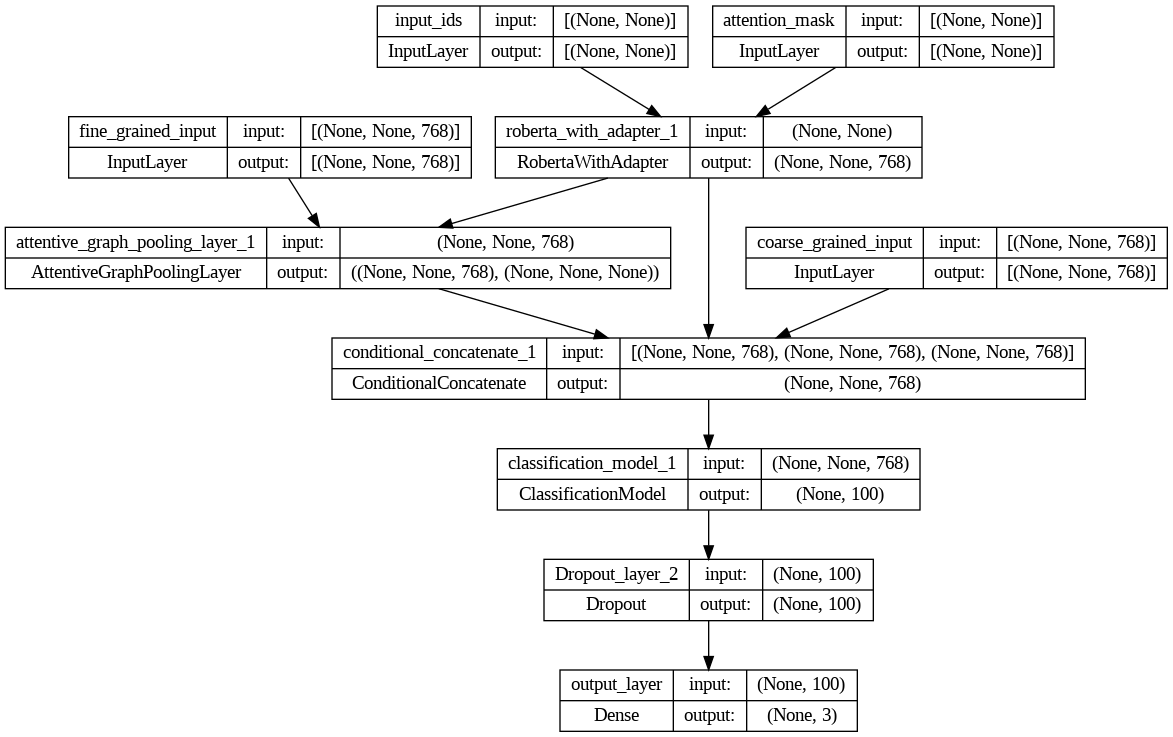

In [17]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import plot_model

model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class ClassificationModel(tf.keras.Model):
    def __init__(self, max_sequence_length, combined_embedding_dim):
        super(ClassificationModel, self).__init__()
        self.conv1d = Conv1D(filters=512, kernel_size=5, activation='relu', name='Conv1D_layer')
        self.max_pooling = MaxPooling1D(pool_size=2, name='MaxPooling_layer')
        self.bilstm = Bidirectional(LSTM(100, return_sequences=True), name='BiLSTM_layer')
        self.attention = tf.keras.layers.Attention(name='Attention_layer')
        self.global_max_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')
        self.dense1 = Dense(200, activation='relu', name='Dense_layer_1')
        self.dropout1 = Dropout(0.6, name='Dropout_layer_1')
        self.dense2 = Dense(100, activation='relu', name='Dense_layer_2')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.max_pooling(x)
        x = self.bilstm(x)
        attention_output = self.attention([x, x])
        x = self.global_max_pooling(attention_output)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        adapter_output = self.adapter(sequence_output)
        return adapter_output

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        Q = self.WQ(h)
        K = self.WK(c)
        V = self.WV(c)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attended_values = tf.matmul(attn_weights, V)

        return attended_values, attn_weights

class CheckAllZero(Layer):
    def __init__(self, **kwargs):
        super(CheckAllZero, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_all(tf.equal(inputs, 0), axis=None, keepdims=False)

class ConditionalConcatenate(Layer):
    def __init__(self, **kwargs):
        super(ConditionalConcatenate, self).__init__(**kwargs)

    def call(self, tensors):
        tensor_to_concatenate = []
        for tensor in tensors:
            all_zero = CheckAllZero()(tensor)
            if not tf.reduce_any(all_zero):
                tensor_to_concatenate.append(tensor)

        if len(tensor_to_concatenate) == 0:
            raise ValueError("No tensors to concatenate. Ensure at least one tensor is non-zero.")

        return Concatenate(axis=1)(tensor_to_concatenate)

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
fine_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='fine_grained_input')
coarse_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='coarse_grained_input')

roberta_with_adapter = RobertaWithAdapter(model_name, adapter_dim=64)
attention_layer = AttentiveGraphPoolingLayer(hidden_dim=768)
max_seq = roberta_with_adapter.roberta.config.max_position_embeddings
class_model = ClassificationModel(max_sequence_length=max_seq, combined_embedding_dim=768)

roberta_output = roberta_with_adapter(input_ids=input_ids, attention_mask=attention_mask)
attention_output, _ = attention_layer(fine_grained_input, roberta_output)

# Use the custom ConditionalConcatenate layer
concatenated_input = ConditionalConcatenate()([roberta_output, attention_output, coarse_grained_input])

# Define the output layer
output_layer = class_model(concatenated_input)
dropout2 = Dropout(0.5, name='Dropout_layer_2')(output_layer)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

# Define and compile the final model
final_model = Model(inputs=[input_ids, attention_mask, fine_grained_input, coarse_grained_input], outputs=output_layer)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
final_model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss_fn, metrics=[f1_score])

final_model.summary()
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/UBC_project/cleaned_data_no_special_characters.csv' ,encoding='utf-8')
df.sample(10)

,claims,claims_labels
415,the Clean Power Plan a major component of fulf...,REFUTES
2141,this last phenomenon be know as the greenhouse...,NOT_ENOUGH_INFO
4265,the southern polar cap have a diameter of 350 ...,NOT_ENOUGH_INFO
2776,the work of the Intergovernmental Panel on Cli...,NOT_ENOUGH_INFO
4246,rise sea level threaten small Pacific island n...,SUPPORTS
3619,an article by Herald Traufetter for Spiegel On...,NOT_ENOUGH_INFO
3194,an Iceberg 30 Times the Size of Manhattan be a...,SUPPORTS
8769,number of Australians concern about impact of ...,SUPPORTS
8483,the country be roll out a progressive ban on p...,SUPPORTS
8115,a company that make packing out of plant finer...,SUPPORTS


In [19]:
df = df[(df['claims'].str.split().str.len() > 3) & (df['claims'].str.split().str.len() < 20)]
df.shape

(3850, 2)

Balanced Class Distribution:
claims_labels
SUPPORTS           1099
NOT_ENOUGH_INFO    1099
REFUTES            1099
Name: count, dtype: int64


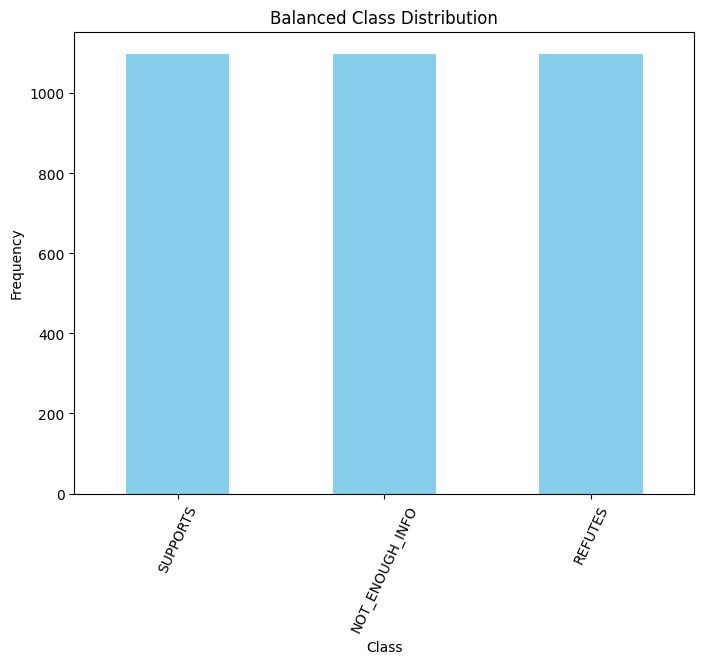

In [20]:
import matplotlib.pyplot as plt
min_class_size = min(df['claims_labels'].value_counts())

balanced_train_data = pd.DataFrame(columns=['claims','claims_labels'])

class_distribution = df['claims_labels'].value_counts()

for genre, count in class_distribution.items():
  class_data = df[df['claims_labels'] == genre].sample(n=min_class_size, random_state=22)
  balanced_train_data = pd.concat([balanced_train_data, class_data], ignore_index=True)

balanced_train_data.describe()
balanced_class_distribution = balanced_train_data['claims_labels'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)

plt.figure(figsize=(8, 6))
balanced_class_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

#df = balanced_train_data


In [21]:
def ohe(text):

    if text=='SUPPORTS':
         return 2
    elif text=='NOT_ENOUGH_INFO':
         return 1
    elif text=='REFUTES' :
          return 0
    return 0

df['claims_labels']=df['claims_labels'].apply(lambda x:ohe(x))

df=df.sample(n=3500,random_state=22)
df.shape

(3500, 2)

In [22]:
df

,claims,claims_labels
2694,the term climate change be often use to refer ...,2
8339,new of report warn the world will surplus 15c ...,2
91,without carbon dioxide all life on Earth would...,2
1155,Arctic sea ice have be retreat over the past 3...,2
1179,Greenland on the whole be lose ice as confirm ...,2
...,...,...
9650,the warm Arctic winter fit an increasingly com...,2
8172,calling and loss of morand in favour of confer...,2
85,it have never be show that human emission of c...,0
499,marine life have nothing whatsoever to fear fr...,0


In [ ]:
import numpy as np

input_ids = []
attention_masks = []
fine_grained_inputs = []
coarse_grained_inputs = []
labels = []
def generate_model_input(df, tokenizer):

  count = 0
  for index, row in df.iterrows():

    text = row['claims']
    label = row['claims_labels']
    count += 1
    print(count)

    roberta_input = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    contextual_vectors_coarse, contextual_vectors_fine = get_contextual_representations(text)


    input_ids.append(roberta_input['input_ids'].numpy()[0])
    attention_masks.append(roberta_input['attention_mask'].numpy()[0])

    if contextual_vectors_fine is not None:
      fine_grained_inputs.append(contextual_vectors_fine.numpy())
    else:
      fine_grained_inputs.append(np.empty((0, 768)))

    if contextual_vectors_coarse is not None:
      coarse_grained_inputs.append(contextual_vectors_coarse.numpy())
    else:
      coarse_grained_inputs.append(np.empty((0, 768)))

    labels.append(label)


generate_model_input(df, tokenizer)


1
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
2


en.wikipedia.org (parse) 15c
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) just 20 year


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=15c


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=just%2020%20year
Epoch 10/20, Loss: 0.5436675548553467
Epoch 20/20, Loss: 0.2932550311088562
Epoch 10/20, Loss: 0.15538732707500458
Epoch 20/20, Loss: 0.15494735538959503
3


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.7664374709129333
Epoch 20/20, Loss: 0.5448542237281799
Epoch 10/20, Loss: 0.18652230501174927
Epoch 20/20, Loss: 0.3273818790912628
4


en.wikipedia.org (parse) Arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the past 30 year


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20sea


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%2030%20year
Epoch 10/20, Loss: 0.1702430695295334
Epoch 20/20, Loss: 0.8328826427459717
Epoch 10/20, Loss: 13.699344635009766
Epoch 20/20, Loss: 9.617575645446777
5
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
6
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
7


en.wikipedia.org (parse) the 1980s
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%201980s
Epoch 10/20, Loss: 0.18138264119625092
Epoch 20/20, Loss: 0.18075448274612427
Epoch 10/20, Loss: 0.17472104728221893
Epoch 20/20, Loss: 0.17409615218639374
8


en.wikipedia.org (parse) 16 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=16%20year
Epoch 10/20, Loss: 14.440055847167969
Epoch 20/20, Loss: 0.16932906210422516
Epoch 10/20, Loss: 0.1685151308774948
Epoch 20/20, Loss: 1.4590401649475098
9
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
10


en.wikipedia.org (parse) the autumn month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) winter


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20autumn%20month


en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Winter
  wikibase: Q1311
  wikidata_url: https://www.wikidata.org/wiki/Q1311
  wikitext: <str(35301)> {{short description|Coldest of the four t...
}


Epoch 10/20, Loss: 0.9420866966247559
Epoch 20/20, Loss: 0.6856915950775146
Epoch 10/20, Loss: 0.24877560138702393
Epoch 20/20, Loss: 0.8383601307868958
11
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
12


en.wikipedia.org (parse) NDAA
NDAA (en) data
{
  pageid: 17585285
  parsetree: <str(536)> <root>'''NDAA''' may refer to:*[[National ...
  requests: <list(1)> parse
  title: NDAA
  wikibase: Q18142681
  wikidata_url: https://www.wikidata.org/wiki/Q18142681
  wikitext: <str(467)> '''NDAA''' may refer to:*[[National Defense...
}
en.wikipedia.org (parse) Pentagon
en.wikipedia.org (imageinfo) File:5-gon cyclic 01.svg
Pentagon (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:5-gon cyc...
  infobox: <dict(4)> name, image, caption, edges
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 20741014
  parsetree: <str(30882)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pentagon
  wikibase: Q127840
  wikidata_url: https://www.wikidata.org/wiki/Q127840
  wikitext: <str(23468)> {{Short description|Shape with five sides...
}


Epoch 10/20, Loss: 0.39293649792671204
Epoch 20/20, Loss: 0.2116726040840149
Epoch 10/20, Loss: 0.1670561581850052
Epoch 20/20, Loss: 0.41062620282173157
13


en.wikipedia.org (parse) 114 million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=114%20million
Epoch 10/20, Loss: 0.15504498779773712
Epoch 20/20, Loss: 0.15461871027946472
Epoch 10/20, Loss: 7.735544681549072
Epoch 20/20, Loss: 0.15368938446044922
14


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 3.1213080883026123
Epoch 20/20, Loss: 1.8857778310775757
Epoch 10/20, Loss: 0.1459711790084839
Epoch 20/20, Loss: 0.14555349946022034
15


en.wikipedia.org (parse) many century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=many%20century
Epoch 10/20, Loss: 2.8918676376342773
Epoch 20/20, Loss: 6.459567546844482
Epoch 10/20, Loss: 10.828410148620605
Epoch 20/20, Loss: 1.9834431409835815
16
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
17
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
18


en.wikipedia.org (parse) the 1970s
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%201970s
Epoch 10/20, Loss: 1.883323311805725
Epoch 20/20, Loss: 0.1693858951330185
Epoch 10/20, Loss: 0.16844363510608673
Epoch 20/20, Loss: 0.16774141788482666
19
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
20
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
21
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
22


en.wikipedia.org (parse) Line Island
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Smith


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Line%20Island


Smith (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Smith, https:/...
  pageid: 28224
  parsetree: <str(4571)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Smith
  wikibase: Q217465
  wikidata_url: https://www.wikidata.org/wiki/Q217465
  wikitext: <str(3734)> {{Wiktionary|Smith|smith}}'''Smith''' may ...
}
en.wikipedia.org (parse) Toller
Toller (en) data
{
  infobox: <dict(22)> static_image_name, static_image_caption, cou...
  pageid: 1967465
  parsetree: <str(14649)> <root><template><title>other uses</title...
  requests: <list(1)> parse
  title: Toller
  wikibase: Q7814379
  wikidata_url: https://www.wikidata.org/wiki/Q7814379
  wikitext: <str(8821)> {{other uses}}{{Update|date=March 2020|rea...
}
en.wikipedia.org (parse) West Antarctica
West Antarctica (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2151659
  parsetree: <str(6032)> <root><template><title>Coord</title><part...
  request

Epoch 10/20, Loss: 0.3195231854915619
Epoch 20/20, Loss: 0.3952166438102722
Epoch 10/20, Loss: 0.17769479751586914
Epoch 20/20, Loss: 0.4580869674682617
23
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
24
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
25


en.wikipedia.org (parse) Bikinians
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Bikinians
Epoch 10/20, Loss: 3.718252420425415
Epoch 20/20, Loss: 0.1520443707704544
Epoch 10/20, Loss: 25.22797966003418
Epoch 20/20, Loss: 0.15233784914016724
26


en.wikipedia.org (parse) North Sole
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) washingtonpostcom


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=North%20Sole


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=washingtonpostcom
Epoch 10/20, Loss: 0.15967309474945068
Epoch 20/20, Loss: 0.1591813713312149
Epoch 10/20, Loss: 0.16669391095638275
Epoch 20/20, Loss: 0.16611222922801971
27


en.wikipedia.org (parse) Baseload Power and Reducing Transmission
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Mind Arms PDF


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Baseload%20Power%20and%20Reducing%20Transmission


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Mind%20Arms%20PDF
Epoch 10/20, Loss: 0.28169047832489014
Epoch 20/20, Loss: 0.3330436050891876
Epoch 10/20, Loss: 0.5347023010253906
Epoch 20/20, Loss: 0.7448686957359314
28
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
29
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
30


en.wikipedia.org (parse) John Solemn
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=John%20Solemn
Epoch 10/20, Loss: 0.1495160609483719
Epoch 20/20, Loss: 0.14899688959121704
Epoch 10/20, Loss: 14.798417091369629
Epoch 20/20, Loss: 0.14794480800628662
31
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
32


en.wikipedia.org (parse) Aridity
Aridity (en) data
{
  iwlinks: <list(2)> https://en.wikivoyage.org/wiki/Arid_region_sa...
  pageid: 560009
  parsetree: <str(4240)> <root><template><title>Short description<...
  requests: <list(1)> parse
  title: Aridity
  wikibase: Q1330709
  wikidata_url: https://www.wikidata.org/wiki/Q1330709
  wikitext: <str(2945)> {{Short description|Term for regions chara...
}
en.wikipedia.org (parse) Tea Life
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Tea%20Life
Epoch 10/20, Loss: 1.6346570253372192
Epoch 20/20, Loss: 0.9202792048454285
Epoch 10/20, Loss: 0.16207784414291382
Epoch 20/20, Loss: 0.1757451891899109
33
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
34


en.wikipedia.org (parse) post1980
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=post1980
Epoch 10/20, Loss: 13.26675033569336
Epoch 20/20, Loss: 1.5691800117492676
Epoch 10/20, Loss: 0.7523839473724365
Epoch 20/20, Loss: 2.5918314456939697
35


en.wikipedia.org (parse) Less than half
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) publish


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Less%20than%20half


Publishing (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/category:P...
  pageid: 68761
  parsetree: <str(49691)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Publishing
  wikibase: Q3972943
  wikidata_url: https://www.wikidata.org/wiki/Q3972943
  wikitext: <str(42667)> {{Short description|Process of production...
}


Epoch 10/20, Loss: 1.1423817873001099
Epoch 20/20, Loss: 0.5898322463035583
Epoch 10/20, Loss: 0.6333793997764587
Epoch 20/20, Loss: 0.1673220843076706
36


en.wikipedia.org (parse) early with century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=early%20with%20century
Epoch 10/20, Loss: 39.748958587646484
Epoch 20/20, Loss: 0.17384791374206543
Epoch 10/20, Loss: 0.17233838140964508
Epoch 20/20, Loss: 0.17151086032390594
37


en.wikipedia.org (parse) Sonya Reveal Domestic Radicalization
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Sonya%20Reveal%20Domestic%20Radicalization
Epoch 10/20, Loss: 0.17551569640636444
Epoch 20/20, Loss: 2.673919677734375
Epoch 10/20, Loss: 17.22263526916504
Epoch 20/20, Loss: 1.1814156770706177
38


en.wikipedia.org (parse) as much as 10
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Fahrenheit


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=as%20much%20as%2010


en.wikipedia.org (imageinfo) File:Raumthermometer Fahrenheit+Cels...
Fahrenheit (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Raumtherm...
  infobox: <dict(14)> name, image, caption, standard, quantity, sy...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 11524
  parsetree: <str(45866)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Fahrenheit
  wikibase: Q42289
  wikidata_url: https://www.wikidata.org/wiki/Q42289
  wikitext: <str(31332)> {{Short description|Temperature scale}}{{...
}


Epoch 10/20, Loss: 0.587673544883728
Epoch 20/20, Loss: 0.36577945947647095
Epoch 10/20, Loss: 0.4203025698661804
Epoch 20/20, Loss: 0.30538707971572876
39
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
40


en.wikipedia.org (parse) IPCC
en.wikipedia.org (imageinfo) File:Intergovernmental Panel on Clim...
Intergovernmental Panel on Climate Change (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Intergove...
  infobox: <dict(12)> name, image, type, abbreviation, leader_titl...
  iwlinks: <list(1)> https://en.wikisource.org/wiki/Al_Gore%27s_No...
  pageid: 15030
  parsetree: <str(103292)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Intergovernmental Panel on Climate Change
  wikibase: Q171183
  wikidata_url: https://www.wikidata.org/wiki/Q171183
  wikitext: <str(88132)> {{short description|Scientific intergover...
}


Epoch 10/20, Loss: 1.8101755380630493
Epoch 20/20, Loss: 1.22400963306427
Epoch 10/20, Loss: 0.5372303128242493
Epoch 20/20, Loss: 4.537876129150391
41
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
42
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
43


en.wikipedia.org (parse) 1950
1950 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1950
  pageid: 19283873
  parsetree: <str(103445)> <root><template><title>pp-pc</title><pa...
  requests: <list(1)> parse
  title: 1950
  wikibase: Q18597
  wikidata_url: https://www.wikidata.org/wiki/Q18597
  wikitext: <str(91019)> {{pp-pc|small=yes}}{{Use mdy dates|date=A...
}


Epoch 10/20, Loss: 0.3930218815803528
Epoch 20/20, Loss: 0.25127777457237244
Epoch 10/20, Loss: 1.8635791540145874
Epoch 20/20, Loss: 0.15730786323547363
44
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
45


en.wikipedia.org (parse) 97 Percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) July


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=97%20Percent


July (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 15786
  parsetree: <str(18654)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: July
  wikibase: Q121
  wikidata_url: https://www.wikidata.org/wiki/Q121
  wikitext: <str(16691)> {{About|the month}}{{Redirect|Jul.||Jul (...
}


Epoch 10/20, Loss: 0.7304275035858154
Epoch 20/20, Loss: 0.4121563732624054
Epoch 10/20, Loss: 0.16387782990932465
Epoch 20/20, Loss: 7.608560562133789
46
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
47
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
48
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
49
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
50


en.wikipedia.org (parse) ten of million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=ten%20of%20million
Epoch 10/20, Loss: 6.766538143157959
Epoch 20/20, Loss: 0.6930666565895081
Epoch 10/20, Loss: 0.1776803582906723
Epoch 20/20, Loss: 0.1772444248199463
51
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
52
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
53


en.wikipedia.org (parse) Canada
Canada (en) data
{
  infobox: <dict(72)> conventional_long_name, image_flag, alt_flag...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Canada, ht...
  pageid: 5042916
  parsetree: <str(354402)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Canada
  wikibase: Q16
  wikidata_url: https://www.wikidata.org/wiki/Q16
  wikitext: <str(278040)> {{Short description|Country in North Ame...
}
en.wikipedia.org (parse) Ontario
Ontario (en) data
{
  infobox: <dict(64)> name, settlement_type, image_flag, flag_alt,...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Ontario, h...
  pageid: 22218
  parsetree: <str(206670)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Ontario
  wikibase: Q1904
  wikidata_url: https://www.wikidata.org/wiki/Q1904
  wikitext: <str(165739)> {{Short description|Province of Canada}}...
}
en.wikipedia.org (parse) Forget
Forget (en) data
{
  iwlinks: <list(1)> h

Epoch 10/20, Loss: 1.3312151432037354
Epoch 20/20, Loss: 0.8085251450538635
Epoch 10/20, Loss: 0.4769180119037628
Epoch 20/20, Loss: 0.10959208011627197
54
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
55
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
56


en.wikipedia.org (parse) 14 million year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=14%20million%20year
Epoch 10/20, Loss: 0.1629095822572708
Epoch 20/20, Loss: 1.8914433717727661
Epoch 10/20, Loss: 0.1614624559879303
Epoch 20/20, Loss: 0.16083739697933197
57


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}


Epoch 10/20, Loss: 0.6862738728523254
Epoch 20/20, Loss: 0.4788077473640442
Epoch 10/20, Loss: 0.20471131801605225
Epoch 20/20, Loss: 0.231247216463089
58


en.wikipedia.org (parse) Arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20sea
Epoch 10/20, Loss: 11.541226387023926
Epoch 20/20, Loss: 0.162482351064682
Epoch 10/20, Loss: 12.58749008178711
Epoch 20/20, Loss: 0.16272248327732086
59


en.wikipedia.org (parse) 13
13 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/thirteen
  pageid: 6785516
  parsetree: <str(6142)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 13
  wikibase: Q186642
  wikidata_url: https://www.wikidata.org/wiki/Q186642
  wikitext: <str(5626)> {{wiktionary|thirteen}}'''Thirteen''' or '...
}


Epoch 10/20, Loss: 2.684264659881592
Epoch 20/20, Loss: 0.4431389272212982
Epoch 10/20, Loss: 0.2512485384941101
Epoch 20/20, Loss: 14.564342498779297
60


en.wikipedia.org (parse) Forest Service
Forest service (en) data
{
  pageid: 72605
  parsetree: <str(378)> <root>'''Forest Service''' may refer to:* ...
  requests: <list(1)> parse
  title: Forest service
  wikibase: Q5469196
  wikidata_url: https://www.wikidata.org/wiki/Q5469196
  wikitext: <str(319)> '''Forest Service''' may refer to:* [[Canad...
}
en.wikipedia.org (parse) United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 1.099549651145935
Epoch 20/20, Loss: 0.5620184540748596
Epoch 10/20, Loss: 0.19308960437774658
Epoch 20/20, Loss: 0.3617757260799408
61


en.wikipedia.org (parse) Supreme Court
Supreme court (en) data
{
  pageid: 4913027
  parsetree: <str(61578)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Supreme court
  wikibase: Q190752
  wikidata_url: https://www.wikidata.org/wiki/Q190752
  wikitext: <str(53550)> {{short description|Highest court in a ju...
}


Epoch 10/20, Loss: 0.7100858688354492
Epoch 20/20, Loss: 0.49060216546058655
Epoch 10/20, Loss: 3.112602472305298
Epoch 20/20, Loss: 0.1624060422182083
62


en.wikipedia.org (parse) REDD
en.wikipedia.org (imageinfo) File:UN-REDD-logo.gif
REDD and REDD+ (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:UN-REDD-l...
  infobox: <dict(12)> image, alt, map, headquarters, leader_title,...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 73776850
  parsetree: <str(119671)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: REDD and REDD+
  wikibase: Q77630
  wikidata_url: https://www.wikidata.org/wiki/Q77630
  wikitext: <str(97743)> {{Short description|Climate change mitiga...
}


Epoch 10/20, Loss: 1.599253535270691
Epoch 20/20, Loss: 2.5219998359680176
Epoch 10/20, Loss: 0.7472264766693115
Epoch 20/20, Loss: 0.3864326775074005
63


en.wikipedia.org (parse) America
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}
en.wikipedia.org (parse) 131
131 (en) data
{
  pageid: 63304476
  parsetree: <str(467)> <root>'''131''' may refer to:*[[131 (numbe...
  requests: <list(1)> parse
  title: 131
  wikibase: Q395788
  wikidata_url: https://www.wikidata.org/wiki/Q395788
  wikitext: <str(408)> '''131''' may refer to:*[[131 (number)]]*[[...
}
en.wikipedia.org (parse) F
en.wikipedia.org (imageinfo) File:Latin_letter_F.svg
F (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Latin_let...
  infobox: <dict(18)> name, letter, scr

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20come%20decade
Epoch 10/20, Loss: 1.563295602798462
Epoch 20/20, Loss: 0.6294337511062622
Epoch 10/20, Loss: 0.16634222865104675
Epoch 20/20, Loss: 0.40284886956214905
64
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
65
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
66


en.wikipedia.org (parse) Models
Model (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 263343
  parsetree: <str(17036)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Model
  wikibase: Q1979154
  wikidata_url: https://www.wikidata.org/wiki/Q1979154
  wikitext: <str(14499)> {{Short description|Informative represent...
}


Epoch 10/20, Loss: 0.6329622268676758
Epoch 20/20, Loss: 0.591943621635437
Epoch 10/20, Loss: 0.1659824252128601
Epoch 20/20, Loss: 0.16551685333251953
67


en.wikipedia.org (parse) Weather Channel
The Weather Channel (en) data
{
  infobox: <dict(17)> logo, logo_size, logo_alt, launch_date, owne...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 77832
  parsetree: <str(95138)> <root><template><title>short description...
  requests: <list(1)> parse
  title: The Weather Channel
  wikibase: Q2043935
  wikidata_url: https://www.wikidata.org/wiki/Q2043935
  wikitext: <str(81422)> {{short description|American  TV channel}...
}


Epoch 10/20, Loss: 0.6025616526603699
Epoch 20/20, Loss: 1.0691546201705933
Epoch 10/20, Loss: 0.30978482961654663
Epoch 20/20, Loss: 0.35274365544319153
68


en.wikipedia.org (parse) New Hampshire
New Hampshire (en) data
{
  infobox: <dict(66)> name, image_flag, flag_link, image_seal, sea...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:N...
  pageid: 21134
  parsetree: <str(161661)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: New Hampshire
  wikibase: Q759
  wikidata_url: https://www.wikidata.org/wiki/Q759
  wikitext: <str(128879)> {{short description|U.S. state}}{{about|...
}


Epoch 10/20, Loss: 1.097470998764038
Epoch 20/20, Loss: 0.5199216604232788
Epoch 10/20, Loss: 1.6574925184249878
Epoch 20/20, Loss: 0.18646661937236786
69
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
70


en.wikipedia.org (parse) Drums
Drum (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 7950
  parsetree: <str(22990)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Drum
  wikibase: Q11404
  wikidata_url: https://www.wikidata.org/wiki/Q11404
  wikitext: <str(19220)> {{Short description|Type of musical instr...
}


Epoch 10/20, Loss: 1.3872674703598022
Epoch 20/20, Loss: 1.0239439010620117
Epoch 10/20, Loss: 0.1649596095085144
Epoch 20/20, Loss: 0.16455410420894623
71


en.wikipedia.org (parse) Missouri
Missouri (en) data
{
  infobox: <dict(61)> image_flag, name, image_seal, nicknames, mot...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 19571
  parsetree: <str(209705)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Missouri
  wikibase: Q1581
  wikidata_url: https://www.wikidata.org/wiki/Q1581
  wikitext: <str(154943)> {{short description|U.S. state}}{{about|...
}


Epoch 10/20, Loss: 0.8010958433151245
Epoch 20/20, Loss: 0.4776902198791504
Epoch 10/20, Loss: 0.2970311641693115
Epoch 20/20, Loss: 0.2007177770137787
72


en.wikipedia.org (parse) at least a decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=at%20least%20a%20decade
Epoch 10/20, Loss: 0.16792477667331696
Epoch 20/20, Loss: 0.16739521920681
Epoch 10/20, Loss: 0.16656394302845
Epoch 20/20, Loss: 13.644843101501465
73


en.wikipedia.org (parse) 25 billion
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=25%20billion
Epoch 10/20, Loss: 0.15295888483524323
Epoch 20/20, Loss: 0.15255825221538544
Epoch 10/20, Loss: 0.15200407803058624
Epoch 20/20, Loss: 1.2074264287948608
74


en.wikipedia.org (parse) the Preindustrial Period
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Preindustrial%20Period
Epoch 10/20, Loss: 0.18346184492111206
Epoch 20/20, Loss: 1.6375116109848022
Epoch 10/20, Loss: 0.18010126054286957
Epoch 20/20, Loss: 0.17956644296646118
75
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
76


en.wikipedia.org (parse) next 30 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=next%2030%20year
Epoch 10/20, Loss: 0.18108443915843964
Epoch 20/20, Loss: 0.18053728342056274
Epoch 10/20, Loss: 0.17904607951641083
Epoch 20/20, Loss: 19.838472366333008
77


en.wikipedia.org (parse) 2014
2014 (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/hard_pass, htt...
  pageid: 48630
  parsetree: <str(56998)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2014
  wikibase: Q1999
  wikidata_url: https://www.wikidata.org/wiki/Q1999
  wikitext: <str(49790)> {{See also|2010s political history}}{{pp-...
}


Epoch 10/20, Loss: 1.3628132343292236
Epoch 20/20, Loss: 0.46462282538414
Epoch 10/20, Loss: 0.757976770401001
Epoch 20/20, Loss: 0.17342038452625275
78
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
79


en.wikipedia.org (parse) this century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20century
Epoch 10/20, Loss: 22.107301712036133
Epoch 20/20, Loss: 13.782090187072754
Epoch 10/20, Loss: 0.16372434794902802
Epoch 20/20, Loss: 1.1260164976119995
80
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
81
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
82


en.wikipedia.org (parse) first
First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3922)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(3056)> {{wiktionary|first}}'''First''' or '''1st'...
}


Epoch 10/20, Loss: 1.3413448333740234
Epoch 20/20, Loss: 0.8357174396514893
Epoch 10/20, Loss: 0.14982673525810242
Epoch 20/20, Loss: 1.5000509023666382
83


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}
en.wikipedia.org (parse) about 40
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%2040
Epoch 10/20, Loss: 0.16953574120998383
Epoch 20/20, Loss: 1.724376916885376
Epoch 10/20, Loss: 0.39147111773490906
Epoch 20/20, Loss: 0.33437347412109375
84


en.wikipedia.org (parse) 2000
2000 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2000
  pageid: 34548
  parsetree: <str(40670)> <root><template><title>pp-pc</title><par...
  requests: <list(1)> parse
  title: 2000
  wikibase: Q1985
  wikidata_url: https://www.wikidata.org/wiki/Q1985
  wikitext: <str(34738)> {{pp-pc|small=yes}}{{About year|2000}}{{m...
}
en.wikipedia.org (parse) about 29
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%2029
Epoch 10/20, Loss: 0.4499344825744629
Epoch 20/20, Loss: 0.3891959488391876
Epoch 10/20, Loss: 0.1626080423593521
Epoch 20/20, Loss: 0.48723629117012024
85
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
86
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
87


en.wikipedia.org (parse) annually
Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}
en.wikipedia.org (parse) winter
en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Winter
  wikibase: Q1311
  wikidata_url: https://www.wikidata.org/wiki/Q1311
  wikitext: <str(35301)> {{short description|Coldest of the four t...

Epoch 10/20, Loss: 0.623155415058136
Epoch 20/20, Loss: 0.4439813494682312
Epoch 10/20, Loss: 0.2146654576063156
Epoch 20/20, Loss: 0.1448645293712616
88
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
89


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}
en.wikipedia.org (parse) month
Month (en) data
{
  iwlinks: <list(14)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 20354
  parsetree: <str(66827)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Month
  wikibase: Q5151
  wikidata_url: https://www.wikidata.org/w

Epoch 10/20, Loss: 1.1007870435714722
Epoch 20/20, Loss: 0.848561704158783
Epoch 10/20, Loss: 0.5855976343154907
Epoch 20/20, Loss: 0.36140188574790955
90


en.wikipedia.org (parse) a million year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=a%20million%20year
Epoch 10/20, Loss: 0.8937892913818359
Epoch 20/20, Loss: 0.16768045723438263
Epoch 10/20, Loss: 14.672870635986328
Epoch 20/20, Loss: 0.1665717512369156
91


en.wikipedia.org (parse) the Arctic Ocean
Arctic Ocean (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 18951556
  parsetree: <str(89663)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Arctic Ocean
  wikibase: Q788
  wikidata_url: https://www.wikidata.org/wiki/Q788
  wikitext: <str(66168)> {{short description|Ocean in the north po...
}


Epoch 10/20, Loss: 0.7137486934661865
Epoch 20/20, Loss: 0.5112012624740601
Epoch 10/20, Loss: 0.1783486157655716
Epoch 20/20, Loss: 0.17735128104686737
92


en.wikipedia.org (parse) american
American (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/American, http...
  pageid: 33775421
  parsetree: <str(6378)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: American
  wikibase: Q463180
  wikidata_url: https://www.wikidata.org/wiki/Q463180
  wikitext: <str(5690)> {{wiktionary|American|american}}<!--== NOT...
}


Epoch 10/20, Loss: 0.46568357944488525
Epoch 20/20, Loss: 0.6193796396255493
Epoch 10/20, Loss: 0.15609197318553925
Epoch 20/20, Loss: 0.155796080827713
93


en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 3.826040267944336
Epoch 20/20, Loss: 0.44013264775276184
Epoch 10/20, Loss: 0.3282177448272705
Epoch 20/20, Loss: 1.7066514492034912
94


en.wikipedia.org (parse) 40
40 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/forty
  pageid: 38345637
  parsetree: <str(1881)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 40
  wikibase: Q411346
  wikidata_url: https://www.wikidata.org/wiki/Q411346
  wikitext: <str(1442)> {{wiktionary|forty}}{{technical reasons|40...
}
en.wikipedia.org (parse) the last century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%20century
Epoch 10/20, Loss: 0.4721151888370514
Epoch 20/20, Loss: 0.2720995843410492
Epoch 10/20, Loss: 0.582129716873169
Epoch 20/20, Loss: 1.6213504076004028
95
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
96


en.wikipedia.org (parse) 1231
1231 (en) data
{
  pageid: 40063
  parsetree: <str(9840)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 1231
  wikibase: Q5417
  wikidata_url: https://www.wikidata.org/wiki/Q5417
  wikitext: <str(8433)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 0.16718874871730804
Epoch 20/20, Loss: 7.473752975463867
Epoch 10/20, Loss: 0.15617439150810242
Epoch 20/20, Loss: 0.15580110251903534
97


en.wikipedia.org (parse) Scott Fruits
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Scott%20Fruits
Epoch 10/20, Loss: 2.025714874267578
Epoch 20/20, Loss: 0.18927331268787384
Epoch 10/20, Loss: 14.130719184875488
Epoch 20/20, Loss: 0.1555836796760559
98


en.wikipedia.org (parse) many century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=many%20century
Epoch 10/20, Loss: 6.812714099884033
Epoch 20/20, Loss: 0.1909501552581787
Epoch 10/20, Loss: 0.1718505173921585
Epoch 20/20, Loss: 1.1367473602294922
99
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
100
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
101
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
102
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
103


en.wikipedia.org (parse) India
India (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, native_...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Atlas_of_I...
  pageid: 14533
  parsetree: <str(527914)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: India
  wikibase: Q668
  wikidata_url: https://www.wikidata.org/wiki/Q668
  wikitext: <str(308598)> {{Short description|Country in South Asi...
}


Epoch 10/20, Loss: 0.6080728769302368
Epoch 20/20, Loss: 0.6907960176467896
Epoch 10/20, Loss: 0.13030998408794403
Epoch 20/20, Loss: 0.10684540867805481
104
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
105


en.wikipedia.org (parse) today
Today (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/today, https:/...
  pageid: 206960
  parsetree: <str(8263)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Today
  wikibase: Q348420
  wikidata_url: https://www.wikidata.org/wiki/Q348420
  wikitext: <str(6841)> {{wiktionary|today}}'''Today''' (archaical...
}
en.wikipedia.org (parse) Solar
Solar (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/solar
  pageid: 5433384
  parsetree: <str(2961)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Solar
  wikibase: Q438246
  wikidata_url: https://www.wikidata.org/wiki/Q438246
  wikitext: <str(2468)> {{wiktionary|solar}}'''Solar'''  may refer...
}
en.wikipedia.org (parse) Coal
en.wikipedia.org (imageinfo) File:Bituminous Coal.JPG
Coal (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Bituminou...
  infobox: <dict(6)> name, type, image, image_capt

Epoch 10/20, Loss: 0.7758268117904663
Epoch 20/20, Loss: 0.3324004113674164
Epoch 10/20, Loss: 0.49670472741127014
Epoch 20/20, Loss: 2.2051663398742676
106
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
107
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
108


en.wikipedia.org (parse) Democrat
Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}
en.wikipedia.org (parse) Alexandria OcasioCortez
en.wikipedia.org (imageinfo) File:Alexandria Ocasio-Cortez Offici...
Alexandria Ocasio-Cortez (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Alexandri...
  infobox: <dict(14)> name, image, caption, state, district, term_...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 54885332
  parsetree: <str(336826)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Alexandria Ocasio-Cortez
  wikibase: Q55223040
  wikidata_url: https://www.wikidata.org/wiki/Q55

Epoch 10/20, Loss: 0.5311459302902222
Epoch 20/20, Loss: 0.30351021885871887
Epoch 10/20, Loss: 0.5806244611740112
Epoch 20/20, Loss: 0.24373699724674225
109
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
110
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
111
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
112


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 0.26358914375305176
Epoch 20/20, Loss: 0.40801355242729187
Epoch 10/20, Loss: 19.454021453857422
Epoch 20/20, Loss: 0.14543373882770538
113
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
114


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) winter
en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>

Epoch 10/20, Loss: 0.46522998809814453
Epoch 20/20, Loss: 0.45516449213027954
Epoch 10/20, Loss: 0.1532890498638153
Epoch 20/20, Loss: 0.18596670031547546
115


en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397256)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(250818)> {{Short description|Capital and largest ...
}


Epoch 10/20, Loss: 0.7224500179290771
Epoch 20/20, Loss: 0.40280500054359436
Epoch 10/20, Loss: 0.6033021807670593
Epoch 20/20, Loss: 0.1542314738035202
116


en.wikipedia.org (parse) 70 percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=70%20percent
Epoch 10/20, Loss: 0.16383665800094604
Epoch 20/20, Loss: 0.9661445617675781
Epoch 10/20, Loss: 0.16239206492900848
Epoch 20/20, Loss: 0.16194698214530945
117
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
118
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
119


en.wikipedia.org (parse) the Patient Protection and Unfordable
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Patient%20Protection%20and%20Unfordable
Epoch 10/20, Loss: 0.18331266939640045
Epoch 20/20, Loss: 1.3080697059631348
Epoch 10/20, Loss: 0.1821829080581665
Epoch 20/20, Loss: 0.18168561160564423
120
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
121


en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 0.7505871057510376
Epoch 20/20, Loss: 0.3949921131134033
Epoch 10/20, Loss: 0.23166440427303314
Epoch 20/20, Loss: 0.21866552531719208
122
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
123
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
124


en.wikipedia.org (parse) recent year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=recent%20year
Epoch 10/20, Loss: 0.17905868589878082
Epoch 20/20, Loss: 0.178664430975914
Epoch 10/20, Loss: 0.17753662168979645
Epoch 20/20, Loss: 20.293066024780273
125


en.wikipedia.org (parse) National Oceanic and Atmospheric Adminis...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=National%20Oceanic%20and%20Atmospheric%20Administration%20NOAA
Epoch 10/20, Loss: 6.069746494293213
Epoch 20/20, Loss: 0.1798383742570877
Epoch 10/20, Loss: 0.17968325316905975
Epoch 20/20, Loss: 0.1790311336517334
126


en.wikipedia.org (parse) 2007
2007 (en) data
{
  pageid: 36165
  parsetree: <str(42109)> <root><template><title>Events by month</...
  requests: <list(1)> parse
  title: 2007
  wikibase: Q2024
  wikidata_url: https://www.wikidata.org/wiki/Q2024
  wikitext: <str(35908)> {{Events by month|2007|prefix=Portal:Curr...
}


Epoch 10/20, Loss: 0.4490175247192383
Epoch 20/20, Loss: 0.3300020694732666
Epoch 10/20, Loss: 1.7994858026504517
Epoch 20/20, Loss: 0.17237740755081177
127
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
128


en.wikipedia.org (parse) Netherlands
Netherlands (en) data
{
  infobox: <dict(94)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 21148
  parsetree: <str(269598)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Netherlands
  wikibase: Q55
  wikidata_url: https://www.wikidata.org/wiki/Q55
  wikitext: <str(211999)> {{Short description|Country in northwest...
}
en.wikipedia.org (parse) June and July
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=June%20and%20July
Epoch 10/20, Loss: 1.2472018003463745
Epoch 20/20, Loss: 0.29438352584838867
Epoch 10/20, Loss: 0.5927958488464355
Epoch 20/20, Loss: 0.17601099610328674
129


en.wikipedia.org (parse) Antarctic
Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}


Epoch 10/20, Loss: 0.5696220993995667
Epoch 20/20, Loss: 0.6303535103797913
Epoch 10/20, Loss: 0.16980676352977753
Epoch 20/20, Loss: 0.16932718455791473
130


en.wikipedia.org (parse) IPCC
en.wikipedia.org (imageinfo) File:Intergovernmental Panel on Clim...
Intergovernmental Panel on Climate Change (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Intergove...
  infobox: <dict(12)> name, image, type, abbreviation, leader_titl...
  iwlinks: <list(1)> https://en.wikisource.org/wiki/Al_Gore%27s_No...
  pageid: 15030
  parsetree: <str(103292)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Intergovernmental Panel on Climate Change
  wikibase: Q171183
  wikidata_url: https://www.wikidata.org/wiki/Q171183
  wikitext: <str(88132)> {{short description|Scientific intergover...
}


Epoch 10/20, Loss: 1.1222469806671143
Epoch 20/20, Loss: 1.369794487953186
Epoch 10/20, Loss: 0.30647411942481995
Epoch 20/20, Loss: 0.46835336089134216
131
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
132


en.wikipedia.org (parse) second
en.wikipedia.org (imageinfo) File:Clock-pendulum.gif
Second (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Clock-pen...
  infobox: <dict(7)> name, image, caption, standard, quantity, sym...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 26873
  parsetree: <str(43289)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Second
  wikibase: Q11574
  wikidata_url: https://www.wikidata.org/wiki/Q11574
  wikitext: <str(34709)> {{Short description|SI unit of time}}{{Ab...
}


Epoch 10/20, Loss: 0.6145253777503967
Epoch 20/20, Loss: 0.470701664686203
Epoch 10/20, Loss: 0.34632813930511475
Epoch 20/20, Loss: 0.37260112166404724
133
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
134


en.wikipedia.org (parse) five year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=five%20year
Epoch 10/20, Loss: 0.1696779727935791
Epoch 20/20, Loss: 0.6586525440216064
Epoch 10/20, Loss: 0.16852806508541107
Epoch 20/20, Loss: 0.1679476648569107
135


en.wikipedia.org (parse) February
February (en) data
{
  iwlinks: <list(2)> https://en.wikiquote.org/wiki/Special:Search/...
  pageid: 10845
  parsetree: <str(32807)> <root><template><title>short description...
  requests: <list(1)> parse
  title: February
  wikibase: Q109
  wikidata_url: https://www.wikidata.org/wiki/Q109
  wikitext: <str(25698)> {{short description|Second month in the J...
}


Epoch 10/20, Loss: 0.48929068446159363
Epoch 20/20, Loss: 0.9702871441841125
Epoch 10/20, Loss: 0.16701184213161469
Epoch 20/20, Loss: 10.738848686218262
136
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
137


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}
en.wikipedia.org (parse) 2700 later
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 25 year


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=2700%20later


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=25%20year
Epoch 10/20, Loss: 0.7706946134567261
Epoch 20/20, Loss: 0.7165605425834656
Epoch 10/20, Loss: 0.22592014074325562
Epoch 20/20, Loss: 0.44557610154151917
138


en.wikipedia.org (parse) coming century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=coming%20century
Epoch 10/20, Loss: 0.1715507060289383
Epoch 20/20, Loss: 0.9692385196685791
Epoch 10/20, Loss: 15.118995666503906
Epoch 20/20, Loss: 0.17033495008945465
139
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
140
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
141
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
142


en.wikipedia.org (parse) GMSL
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=GMSL
Epoch 10/20, Loss: 16.952970504760742
Epoch 20/20, Loss: 0.1530170440673828
Epoch 10/20, Loss: 0.15234771370887756
Epoch 20/20, Loss: 0.151908740401268
143
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
144


en.wikipedia.org (parse) 26 million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2016


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=26%20million


2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}


Epoch 10/20, Loss: 0.8458786606788635
Epoch 20/20, Loss: 0.5135610103607178
Epoch 10/20, Loss: 0.37532666325569153
Epoch 20/20, Loss: 4.901583194732666
145
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
146
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
147
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
148
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
149
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
150


en.wikipedia.org (parse) North America
en.wikipedia.org (imageinfo) File:Location North America.svg
North America (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Location ...
  infobox: <dict(17)> title, image, area, population, density, GDP...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/North_Amer...
  pageid: 21139
  parsetree: <str(253015)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: North America
  wikibase: Q49
  wikidata_url: https://www.wikidata.org/wiki/Q49
  wikitext: <str(168990)> {{Short description|Continent in the Nor...
}
en.wikipedia.org (parse) Europe
Europe (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, image, area, population, density, GDP...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 9239
  parsetree: <str(336617)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Europe
  wikibase: Q46
  wikidata_url: https:

Epoch 10/20, Loss: 0.5372209548950195
Epoch 20/20, Loss: 0.4856664836406708
Epoch 10/20, Loss: 0.09716890007257462
Epoch 20/20, Loss: 0.1720542013645172
151


en.wikipedia.org (parse) IPCC
en.wikipedia.org (imageinfo) File:Intergovernmental Panel on Clim...
Intergovernmental Panel on Climate Change (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Intergove...
  infobox: <dict(12)> name, image, type, abbreviation, leader_titl...
  iwlinks: <list(1)> https://en.wikisource.org/wiki/Al_Gore%27s_No...
  pageid: 15030
  parsetree: <str(103292)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Intergovernmental Panel on Climate Change
  wikibase: Q171183
  wikidata_url: https://www.wikidata.org/wiki/Q171183
  wikitext: <str(88132)> {{short description|Scientific intergover...
}
en.wikipedia.org (parse) 5298 cm
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=5298%20cm


2030s (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 36447
  parsetree: <str(17906)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2030s
  wikibase: Q713789
  wikidata_url: https://www.wikidata.org/wiki/Q713789
  wikitext: <str(14443)> {{Short description|Decade of the Gregori...
}


Epoch 10/20, Loss: 1.3651328086853027
Epoch 20/20, Loss: 1.2520822286605835
Epoch 10/20, Loss: 0.6720890998840332
Epoch 20/20, Loss: 1.1851125955581665
152


en.wikipedia.org (parse) Run
Run (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/run, https://e...
  pageid: 355367
  parsetree: <str(9832)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Run
  wikibase: Q234328
  wikidata_url: https://www.wikidata.org/wiki/Q234328
  wikitext: <str(8536)> {{wiktionary|run|runs}}'''Run'''('''s''') ...
}


Epoch 10/20, Loss: 0.11067336797714233
Epoch 20/20, Loss: 0.24010729789733887
Epoch 10/20, Loss: 1.0088589191436768
Epoch 20/20, Loss: 0.1551230102777481
153
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
154


en.wikipedia.org (parse) the House Committee on Science Space and...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Thursday


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20House%20Committee%20on%20Science%20Space%20and%20Technology


Thursday (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 54633
  parsetree: <str(27038)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Thursday
  wikibase: Q129
  wikidata_url: https://www.wikidata.org/wiki/Q129
  wikitext: <str(22245)> {{short description|Day of the week}}{{ot...
}
en.wikipedia.org (parse) Russia
Russia (en) data
{
  infobox: <dict(83)> conventional_long_name, common_name, linking...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/%D0%A0%D0...
  pageid: 25391
  parsetree: <str(458053)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Russia
  wikibase: Q159
  wikidata_url: https://www.wikidata.org/wiki/Q159
  wikitext: <str(374280)> {{Short description|Country spanning Eur...
}


Epoch 10/20, Loss: 1.28195321559906
Epoch 20/20, Loss: 0.5291891694068909
Epoch 10/20, Loss: 1.0150926113128662
Epoch 20/20, Loss: 0.25890713930130005
155


en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}
en.wikipedia.org (parse) last week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) EPA


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=last%20week


en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}


Epoch 10/20, Loss: 1.1815482378005981
Epoch 20/20, Loss: 2.3348448276519775
Epoch 10/20, Loss: 0.17740875482559204
Epoch 20/20, Loss: 0.21784095466136932
156


en.wikipedia.org (parse) 17201800
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=17201800
Epoch 10/20, Loss: 1.0260165929794312
Epoch 20/20, Loss: 0.15077988803386688
Epoch 10/20, Loss: 0.15007628500461578
Epoch 20/20, Loss: 0.14950048923492432
157


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 0.6964950561523438
Epoch 20/20, Loss: 0.8997412323951721
Epoch 10/20, Loss: 0.4526975452899933
Epoch 20/20, Loss: 0.18531760573387146
158
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
159
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
160


en.wikipedia.org (parse) about 248 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20248%20year
Epoch 10/20, Loss: 0.16152481734752655
Epoch 20/20, Loss: 0.1608603447675705
Epoch 10/20, Loss: 0.16003167629241943
Epoch 20/20, Loss: 0.15951323509216309
161
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
162
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
163
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
164


en.wikipedia.org (parse) southern sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=southern%20sea
Epoch 10/20, Loss: 2.820488214492798
Epoch 20/20, Loss: 0.1641370803117752
Epoch 10/20, Loss: 0.1636030524969101
Epoch 20/20, Loss: 2.287508964538574
165


en.wikipedia.org (parse) Solve Ocean
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Solve%20Ocean
Epoch 10/20, Loss: 0.15698231756687164
Epoch 20/20, Loss: 0.5250193476676941
Epoch 10/20, Loss: 8.34726619720459
Epoch 20/20, Loss: 25.1588191986084
166
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
167


en.wikipedia.org (parse) year
Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...
}


Epoch 10/20, Loss: 0.8971500992774963
Epoch 20/20, Loss: 0.617219090461731
Epoch 10/20, Loss: 9.812922477722168
Epoch 20/20, Loss: 0.15320634841918945
168
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
169


en.wikipedia.org (parse) Tibia Server
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) jewish week


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Tibia%20Server


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=jewish%20week
Epoch 10/20, Loss: 2.7057533264160156
Epoch 20/20, Loss: 0.4545072019100189
Epoch 10/20, Loss: 2.080012321472168
Epoch 20/20, Loss: 0.1596359759569168
170
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
171


en.wikipedia.org (parse) ten
Ten (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/A-ten, https:/...
  pageid: 478470
  parsetree: <str(7661)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Ten
  wikibase: Q3841617
  wikidata_url: https://www.wikidata.org/wiki/Q3841617
  wikitext: <str(6437)> {{wiktionary|Ten|ten|A-ten}}'''Ten''', '''...
}
en.wikipedia.org (parse) only three
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=only%20three
Epoch 10/20, Loss: 0.17812995612621307
Epoch 20/20, Loss: 0.28200891613960266
Epoch 10/20, Loss: 0.6165700554847717
Epoch 20/20, Loss: 0.630021870136261
172
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
173
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
174


en.wikipedia.org (parse) Southeast
Points of the compass (en) data
{
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Compass_ro...
  pageid: 339183
  parsetree: <str(125057)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Points of the compass
  wikibase: Q11114344
  wikidata_url: https://www.wikidata.org/wiki/Q11114344
  wikitext: <str(43030)> {{Short description|Directional divisions...
}
en.wikipedia.org (parse) Mississippi River
en.wikipedia.org (imageinfo) File:Efmo View from Fire Point.jpg
Mississippi River (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Efmo View...
  infobox: <dict(35)> name, name_etymology, nickname, image, image...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Mississipp...
  pageid: 19579
  parsetree: <str(184105)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Mississippi River
  wikibase: Q1497
  wikidata_url: https://www.wikidata.org/wiki/Q1

Epoch 10/20, Loss: 0.7310898303985596
Epoch 20/20, Loss: 0.5546956658363342
Epoch 10/20, Loss: 0.3947606086730957
Epoch 20/20, Loss: 0.491398423910141
175


en.wikipedia.org (parse) March 24 2014
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=March%2024%202014
Epoch 10/20, Loss: 28.264610290527344
Epoch 20/20, Loss: 0.16345931589603424
Epoch 10/20, Loss: 0.16238726675510406
Epoch 20/20, Loss: 2.1032826900482178
176


en.wikipedia.org (parse) 1888 1888
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the Pacific Northwest


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=1888%201888


Pacific Northwest (en) data
{
  infobox: <dict(12)> name, settlement_type, image_skyline, subdiv...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 78147
  parsetree: <str(189357)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Pacific Northwest
  wikibase: Q12603
  wikidata_url: https://www.wikidata.org/wiki/Q12603
  wikitext: <str(143283)> {{Short description|Region of northweste...
}


Epoch 10/20, Loss: 0.5638731718063354
Epoch 20/20, Loss: 0.8637767434120178
Epoch 10/20, Loss: 0.223610520362854
Epoch 20/20, Loss: 0.22693945467472076
177
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
178
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
179
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
180
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
181


en.wikipedia.org (parse) african
African (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/African
  pageid: 99229
  parsetree: <str(2105)> <root><template><title>pp-vandalism</titl...
  requests: <list(1)> parse
  title: African
  wikibase: Q385848
  wikidata_url: https://www.wikidata.org/wiki/Q385848
  wikitext: <str(1590)> {{pp-vandalism|small=yes}}{{wiktionary|Afr...
}
en.wikipedia.org (parse) Hurricane Strength
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Hurricane%20Strength
Epoch 10/20, Loss: 0.6462921500205994
Epoch 20/20, Loss: 0.7416291236877441
Epoch 10/20, Loss: 0.16523954272270203
Epoch 20/20, Loss: 0.164800763130188
182


en.wikipedia.org (parse) Warringah
Warringah (en) data
{
  pageid: 2575349
  parsetree: <str(1568)> <root>'''Warringah'''  (<template><title>...
  requests: <list(1)> parse
  title: Warringah
  wikibase: Q92767465
  wikidata_url: https://www.wikidata.org/wiki/Q92767465
  wikitext: <str(917)> '''Warringah'''  ({{IPAc-en|w|ə|ˈ|r|ɪ|ŋ|g|ə...
}
en.wikipedia.org (parse) Abbott
Abbott (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Abbott
  pageid: 520596
  parsetree: <str(1549)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Abbott
  wikibase: Q2699646
  wikidata_url: https://www.wikidata.org/wiki/Q2699646
  wikitext: <str(1099)> {{wiktionary|Abbott}}'''Abbott''' may refe...
}


Epoch 10/20, Loss: 0.1795671582221985
Epoch 20/20, Loss: 0.5875673294067383
Epoch 10/20, Loss: 2.672748565673828
Epoch 20/20, Loss: 0.14559881389141083
183
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
184


en.wikipedia.org (parse) annually
Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}
en.wikipedia.org (parse) winter
en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Winter
  wikibase: Q1311
  wikidata_url: https://www.wikidata.org/wiki/Q1311
  wikitext: <str(35301)> {{short description|Coldest of the four t...

Epoch 10/20, Loss: 0.59406977891922
Epoch 20/20, Loss: 0.44663214683532715
Epoch 10/20, Loss: 0.2885989844799042
Epoch 20/20, Loss: 0.31072351336479187
185


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}
en.wikipedia.org (parse) Harvey
Harvey (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Harvey
  pageid: 61294
  parsetree: <str(5343)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Harvey
  wikibase: Q230871
  wikidata_url: https://www.wikidata.org/wiki/Q2

Epoch 10/20, Loss: 0.5002297163009644
Epoch 20/20, Loss: 0.9305660128593445
Epoch 10/20, Loss: 0.304537296295166
Epoch 20/20, Loss: 0.23694172501564026
186
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
187
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
188
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
189
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
190
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
191


en.wikipedia.org (parse) CO
CO (en) data
{
  iwlinks: <list(5)> https://en.wiktionary.org/wiki/-co, https://e...
  pageid: 234610
  parsetree: <str(3751)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: CO
  wikibase: Q210804
  wikidata_url: https://www.wikidata.org/wiki/Q210804
  wikitext: <str(2933)> {{wiktionary|co|-co|c/o|care of|co-}}'''CO...
}
en.wikipedia.org (parse) as much as half
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) today


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=as%20much%20as%20half


Today (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/today, https:/...
  pageid: 206960
  parsetree: <str(8263)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Today
  wikibase: Q348420
  wikidata_url: https://www.wikidata.org/wiki/Q348420
  wikitext: <str(6841)> {{wiktionary|today}}'''Today''' (archaical...
}


Epoch 10/20, Loss: 0.5989742875099182
Epoch 20/20, Loss: 0.5876364707946777
Epoch 10/20, Loss: 0.3507286310195923
Epoch 20/20, Loss: 0.6600447297096252
192


en.wikipedia.org (parse) 2016
2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}


Epoch 10/20, Loss: 0.5108066201210022
Epoch 20/20, Loss: 0.4832206070423126
Epoch 10/20, Loss: 1.391561508178711
Epoch 20/20, Loss: 0.4817439615726471
193


en.wikipedia.org (parse) hundred
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}
en.wikipedia.org (parse) 66
66 (en) data
{
  pageid: 9109170
  parsetree: <str(902)> <root>'''66''' may refer to:*[[66 (number)...
  requests: <list(1)> parse
  title: 66
  wikibase: Q4642187
  wikidata_url: https://www.wikidata.org/wiki/Q4642187
  wikitext: <str(800)> '''66''' may refer to:*[[66 (number)]]*One ...
}


Epoch 10/20, Loss: 1.46395742893219
Epoch 20/20, Loss: 0.5065412521362305
Epoch 10/20, Loss: 0.5543546080589294
Epoch 20/20, Loss: 0.7501851916313171
194
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
195


en.wikipedia.org (parse) 51
51 (en) data
{
  pageid: 38345648
  parsetree: <str(556)> <root>'''51''' may refer to:* [[51 (number...
  requests: <list(1)> parse
  title: 51
  wikibase: Q242253
  wikidata_url: https://www.wikidata.org/wiki/Q242253
  wikitext: <str(477)> '''51''' may refer to:* [[51 (number)]]* Th...
}


Epoch 10/20, Loss: 0.23181337118148804
Epoch 20/20, Loss: 0.35130321979522705
Epoch 10/20, Loss: 0.1452828198671341
Epoch 20/20, Loss: 0.1449439972639084
196
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
197
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
198


en.wikipedia.org (parse) Decadal Climate Amiability
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the Interdecadal Pacific Oscillation


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Decadal%20Climate%20Amiability


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Interdecadal%20Pacific%20Oscillation
Epoch 10/20, Loss: 8.155097007751465
Epoch 20/20, Loss: 0.19530010223388672
Epoch 10/20, Loss: 16.21720314025879
Epoch 20/20, Loss: 0.19369465112686157
199
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
200
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
201


en.wikipedia.org (parse) albert
Albert (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Albert, https:...
  pageid: 1504
  parsetree: <str(3370)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Albert
  wikibase: Q2637730
  wikidata_url: https://www.wikidata.org/wiki/Q2637730
  wikitext: <str(2828)> {{wiktionary|Albert|Altti}}'''Albert''' ma...
}


Epoch 10/20, Loss: 0.20675186812877655
Epoch 20/20, Loss: 0.12640820443630219
Epoch 10/20, Loss: 0.14634378254413605
Epoch 20/20, Loss: 0.1460268646478653
202


en.wikipedia.org (parse) the Global Climate Action Summit
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Global%20Climate%20Action%20Summit
Epoch 10/20, Loss: 0.974511444568634
Epoch 20/20, Loss: 0.19819076359272003
Epoch 10/20, Loss: 7.212497234344482
Epoch 20/20, Loss: 0.19704987108707428
203


en.wikipedia.org (parse) Australia
Australia (en) data
{
  infobox: <dict(77)> conventional_long_name, common_name, image_f...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 4689264
  parsetree: <str(334639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Australia
  wikibase: Q408
  wikidata_url: https://www.wikidata.org/wiki/Q408
  wikitext: <str(273343)> {{Short description|Country in Oceania}}...
}


Epoch 10/20, Loss: 2.0346617698669434
Epoch 20/20, Loss: 0.4576902985572815
Epoch 10/20, Loss: 0.2348109781742096
Epoch 20/20, Loss: 0.15924493968486786
204


en.wikipedia.org (parse) IPCC
en.wikipedia.org (imageinfo) File:Intergovernmental Panel on Clim...
Intergovernmental Panel on Climate Change (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Intergove...
  infobox: <dict(12)> name, image, type, abbreviation, leader_titl...
  iwlinks: <list(1)> https://en.wikisource.org/wiki/Al_Gore%27s_No...
  pageid: 15030
  parsetree: <str(103292)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Intergovernmental Panel on Climate Change
  wikibase: Q171183
  wikidata_url: https://www.wikidata.org/wiki/Q171183
  wikitext: <str(88132)> {{short description|Scientific intergover...
}
en.wikipedia.org (parse) 5298 cm
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=5298%20cm


2030s (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 36447
  parsetree: <str(17906)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2030s
  wikibase: Q713789
  wikidata_url: https://www.wikidata.org/wiki/Q713789
  wikitext: <str(14443)> {{Short description|Decade of the Gregori...
}


Epoch 10/20, Loss: 1.200360655784607
Epoch 20/20, Loss: 1.1427156925201416
Epoch 10/20, Loss: 0.3594993054866791
Epoch 20/20, Loss: 0.2750466763973236
205
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
206
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
207
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
208
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
209
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
210
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
211


en.wikipedia.org (parse) 2001
2001 (en) data
{
  iwlinks: <list(1)> https://de.wikipedia.org/wiki/SEG_Apartment_Tower
  pageid: 34551
  parsetree: <str(221885)> <root><template><title>pp-move</title><...
  requests: <list(1)> parse
  title: 2001
  wikibase: Q1988
  wikidata_url: https://www.wikidata.org/wiki/Q1988
  wikitext: <str(177009)> {{pp-move}}{{good article}}{{pp-pc|small...
}
en.wikipedia.org (parse) Medieval Arm
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Medieval%20Arm
Epoch 10/20, Loss: 0.948710024356842
Epoch 20/20, Loss: 0.9036021828651428
Epoch 10/20, Loss: 0.7397100329399109
Epoch 20/20, Loss: 0.16697631776332855
212
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
213
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
214
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
215
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
216
No entities found in the news text.
No entities found in the news text.
Graph data i

en.wikipedia.org (parse) the must century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20must%20century
Epoch 10/20, Loss: 0.1822327971458435
Epoch 20/20, Loss: 0.181773841381073
Epoch 10/20, Loss: 0.18096500635147095
Epoch 20/20, Loss: 0.18023037910461426
221


en.wikipedia.org (parse) 1998
1998 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1998
  pageid: 34647
  parsetree: <str(118928)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1998
  wikibase: Q2089
  wikidata_url: https://www.wikidata.org/wiki/Q2089
  wikitext: <str(103304)> {{Use mdy dates|date=August 2019}}{{pp-p...
}


Epoch 10/20, Loss: 2.635235071182251
Epoch 20/20, Loss: 0.547204315662384
Epoch 10/20, Loss: 0.16497363150119781
Epoch 20/20, Loss: 0.16462452709674835
222


en.wikipedia.org (parse) 2010
2010 (en) data
{
  pageid: 43226
  parsetree: <str(84961)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2010
  wikibase: Q1995
  wikidata_url: https://www.wikidata.org/wiki/Q1995
  wikitext: <str(74004)> {{See also|2010s in political history}}{{...
}
en.wikipedia.org (parse) 2005
2005 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2005
  pageid: 35984
  parsetree: <str(51744)> <root><template><title>pp-move</title></...
  requests: <list(1)> parse
  title: 2005
  wikibase: Q2019
  wikidata_url: https://www.wikidata.org/wiki/Q2019
  wikitext: <str(43890)> {{pp-move}}{{pp-pc|small=yes}}{{Use mdy d...
}


Epoch 10/20, Loss: 0.7195477485656738
Epoch 20/20, Loss: 0.5106422901153564
Epoch 10/20, Loss: 0.19734592735767365
Epoch 20/20, Loss: 0.8722855448722839
223
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
224
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
225


en.wikipedia.org (parse) mid 1970
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Celsus


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=mid%201970


Celsus (en) data
{
  infobox: <dict(10)> other_names, name, occupation, language, nat...
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/%CE%B3%CE%BF%C...
  pageid: 787323
  parsetree: <str(51235)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Celsus
  wikibase: Q315370
  wikidata_url: https://www.wikidata.org/wiki/Q315370
  wikitext: <str(27450)> {{Short description|2nd-century Greek phi...
}


Epoch 10/20, Loss: 0.34459519386291504
Epoch 20/20, Loss: 1.4578967094421387
Epoch 10/20, Loss: 3.6712231636047363
Epoch 20/20, Loss: 7.130837440490723
226


en.wikipedia.org (parse) 97
97 (en) data
{
  pageid: 15294594
  parsetree: <str(857)> <root>'''97''' may refer to: * [[97 (numbe...
  requests: <list(1)> parse
  title: 97
  wikibase: Q1166421
  wikidata_url: https://www.wikidata.org/wiki/Q1166421
  wikitext: <str(569)> '''97''' may refer to: * [[97 (number)]]==Y...
}


Epoch 10/20, Loss: 0.2905827462673187
Epoch 20/20, Loss: 0.37889406085014343
Epoch 10/20, Loss: 0.15463873744010925
Epoch 20/20, Loss: 0.8016734719276428
227
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
228


en.wikipedia.org (parse) More than 71000
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=More%20than%2071000
Epoch 10/20, Loss: 16.210752487182617
Epoch 20/20, Loss: 0.15769930183887482
Epoch 10/20, Loss: 0.8102458119392395
Epoch 20/20, Loss: 13.833111763000488
229
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
230
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
231
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
232
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
233


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) Victoria Australia
Victoria (state) (en) data
{
  infobox: <dict(79)> name, settlement_type, image_flag, flag_size...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:V...
  pageid: 4689460
  parsetree: <str(166824)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Victoria (state)
  wikibase: Q36687
  wikidata_

Epoch 10/20, Loss: 0.7511090636253357
Epoch 20/20, Loss: 0.4347636103630066
Epoch 10/20, Loss: 0.14120472967624664
Epoch 20/20, Loss: 0.18465840816497803
234


en.wikipedia.org (parse) almost half
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=almost%20half
Epoch 10/20, Loss: 0.15696834027767181
Epoch 20/20, Loss: 5.1153950691223145
Epoch 10/20, Loss: 0.1557110697031021
Epoch 20/20, Loss: 0.15524600446224213
235
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
236
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
237
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
238
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
239
No entities found in the news text.
No entities found in the news text.
Graph data 

en.wikipedia.org (parse) first
First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3922)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(3056)> {{wiktionary|first}}'''First''' or '''1st'...
}


Epoch 10/20, Loss: 2.058753490447998
Epoch 20/20, Loss: 4.336637496948242
Epoch 10/20, Loss: 0.14992870390415192
Epoch 20/20, Loss: 0.149603933095932
241


en.wikipedia.org (parse) 2016
2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}
en.wikipedia.org (parse) about 10
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 1901


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%2010


1901 (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34618
  parsetree: <str(66320)> <root><template><title>Use mdy dates</ti...
  requests: <list(1)> parse
  title: 1901
  wikibase: Q2035
  wikidata_url: https://www.wikidata.org/wiki/Q2035
  wikitext: <str(59019)> {{Use mdy dates|date=March 2011}}{{Year d...
}


Epoch 10/20, Loss: 0.6799340844154358
Epoch 20/20, Loss: 0.4485897719860077
Epoch 10/20, Loss: 0.8086549639701843
Epoch 20/20, Loss: 2.3358888626098633
242
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
243


en.wikipedia.org (parse) Ll
Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 1.0993590354919434
Epoch 20/20, Loss: 4.126709461212158
Epoch 10/20, Loss: 12.800238609313965
Epoch 20/20, Loss: 3.7928054332733154
244


en.wikipedia.org (parse) Europe
Europe (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, image, area, population, density, GDP...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 9239
  parsetree: <str(336617)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Europe
  wikibase: Q46
  wikidata_url: https://www.wikidata.org/wiki/Q46
  wikitext: <str(246481)> {{Short description|Continent}}{{About|t...
}


Epoch 10/20, Loss: 1.4555668830871582
Epoch 20/20, Loss: 0.6375775337219238
Epoch 10/20, Loss: 0.17488183081150055
Epoch 20/20, Loss: 0.27973243594169617
245


en.wikipedia.org (parse) State
State (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/State, https:/...
  pageid: 290282
  parsetree: <str(6785)> <root><template><title>redirect</title><p...
  requests: <list(1)> parse
  title: State
  wikibase: Q12251220
  wikidata_url: https://www.wikidata.org/wiki/Q12251220
  wikitext: <str(5767)> {{redirect|States|the disambiguation page ...
}


Epoch 10/20, Loss: 0.15930327773094177
Epoch 20/20, Loss: 0.388746440410614
Epoch 10/20, Loss: 0.15739493072032928
Epoch 20/20, Loss: 1.0542179346084595
246


en.wikipedia.org (parse) 1463
1463 (en) data
{
  pageid: 39505
  parsetree: <str(6582)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 1463
  wikibase: Q6549
  wikidata_url: https://www.wikidata.org/wiki/Q6549
  wikitext: <str(5353)> {{Use mdy dates|date=March 2011}}{{Year da...
}
en.wikipedia.org (parse) between 2010 and 2016
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=between%202010%20and%202016
Epoch 10/20, Loss: 3.4874908924102783
Epoch 20/20, Loss: 0.7514356970787048
Epoch 10/20, Loss: 1.063590407371521
Epoch 20/20, Loss: 0.49374738335609436
247


en.wikipedia.org (parse) LGBT
LGBT (en) data
{
  infobox: <dict(1)> list
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Category:L...
  pageid: 66936
  parsetree: <str(107392)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: LGBT
  wikibase: Q17884
  wikidata_url: https://www.wikidata.org/wiki/Q17884
  wikitext: <str(88475)> {{Short description|Initialism for "lesbi...
}


Epoch 10/20, Loss: 4.8316192626953125
Epoch 20/20, Loss: 4.691745758056641
Epoch 10/20, Loss: 6.182055950164795
Epoch 20/20, Loss: 2.1198465824127197
248
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
249


en.wikipedia.org (parse) the Scene Arctic Ocean
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Scene%20Arctic%20Ocean
Epoch 10/20, Loss: 0.17227308452129364
Epoch 20/20, Loss: 0.1717161387205124
Epoch 10/20, Loss: 0.17115934193134308
Epoch 20/20, Loss: 10.279340744018555
250


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}
en.wikipedia.org (parse) more than 60
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) F


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=more%20than%2060


en.wikipedia.org (imageinfo) File:Latin_letter_F.svg
F (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Latin_let...
  infobox: <dict(18)> name, letter, script, type, typedesc, langua...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/F, https:...
  pageid: 10831
  parsetree: <str(27955)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: F
  wikibase: Q9765
  wikidata_url: https://www.wikidata.org/wiki/Q9765
  wikitext: <str(15027)> {{Short description|6th letter of the Lat...
}
en.wikipedia.org (parse) February
February (en) data
{
  iwlinks: <list(2)> https://en.wikiquote.org/wiki/Special:Search/...
  pageid: 10845
  parsetree: <str(32807)> <root><template><title>short description...
  requests: <list(1)> parse
  title: February
  wikibase: Q109
  wikidata_url: https://www.wikidata.org/wiki/Q109
  wikitext: <str(25698)> {{short description|Second month in the J...
}


Epoch 10/20, Loss: 0.7632482051849365
Epoch 20/20, Loss: 0.40205472707748413
Epoch 10/20, Loss: 0.38680723309516907
Epoch 20/20, Loss: 0.21564023196697235
251


en.wikipedia.org (parse) Chinese
Chinese (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Chinese
  pageid: 5347
  parsetree: <str(2463)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Chinese
  wikibase: Q122171651
  wikidata_url: https://www.wikidata.org/wiki/Q122171651
  wikitext: <str(2194)> {{Wiktionary|Chinese}} '''Chinese''' may r...
}


Epoch 10/20, Loss: 0.35806185007095337
Epoch 20/20, Loss: 0.20575964450836182
Epoch 10/20, Loss: 0.7881763577461243
Epoch 20/20, Loss: 0.1597956269979477
252


en.wikipedia.org (parse) Florida
Florida (en) data
{
  infobox: <dict(70)> name, image_flag, image_seal, nickname, mott...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 18933066
  parsetree: <str(319322)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Florida
  wikibase: Q812
  wikidata_url: https://www.wikidata.org/wiki/Q812
  wikitext: <str(256769)> {{Short description|U.S. state}}{{About|...
}
en.wikipedia.org (parse) 17 percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=17%20percent
Epoch 10/20, Loss: 0.43124619126319885
Epoch 20/20, Loss: 0.38974520564079285
Epoch 10/20, Loss: 0.12291660904884338
Epoch 20/20, Loss: 0.3706032633781433
253


en.wikipedia.org (parse) CO2
Carbon dioxide (en) data
{
  infobox: <dict(15)> Verifiedfields, Watchedfields, verifiedrevid...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5906
  parsetree: <str(149998)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Carbon dioxide
  wikibase: Q1997
  wikidata_url: https://www.wikidata.org/wiki/Q1997
  wikitext: <str(113939)> {{Short description|Chemical compound wi...
}


Epoch 10/20, Loss: 0.3099611699581146
Epoch 20/20, Loss: 1.6003137826919556
Epoch 10/20, Loss: 1.1927491426467896
Epoch 20/20, Loss: 2.674703598022461
254
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
255


en.wikipedia.org (parse) 150000
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=150000
Epoch 10/20, Loss: 5.9869513511657715
Epoch 20/20, Loss: 0.1510230451822281
Epoch 10/20, Loss: 9.62711238861084
Epoch 20/20, Loss: 0.929862916469574
256
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
257
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
258
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
259


en.wikipedia.org (parse) 50
50 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/50, https://en...
  pageid: 19485536
  parsetree: <str(1458)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 50
  wikibase: Q1166460
  wikidata_url: https://www.wikidata.org/wiki/Q1166460
  wikitext: <str(1226)> {{wiktionary|50|fifty}}'''50''' may refer ...
}
en.wikipedia.org (parse) Transportation
Transport (en) data
{
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 18580879
  parsetree: <str(79852)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Transport
  wikibase: Q7590
  wikidata_url: https://www.wikidata.org/wiki/Q7590
  wikitext: <str(61361)> {{Short description|Movement of goods or ...
}


Epoch 10/20, Loss: 0.2916587293148041
Epoch 20/20, Loss: 0.20497141778469086
Epoch 10/20, Loss: 7.370937824249268
Epoch 20/20, Loss: 3.6137216091156006
260


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.680686354637146
Epoch 20/20, Loss: 0.43531516194343567
Epoch 10/20, Loss: 0.6148383617401123
Epoch 20/20, Loss: 0.43321871757507324
261


en.wikipedia.org (parse) Gape Down
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Gape%20Down
Epoch 10/20, Loss: 0.15220002830028534
Epoch 20/20, Loss: 0.1517709195613861
Epoch 10/20, Loss: 0.15113790333271027
Epoch 20/20, Loss: 0.15061058104038239
262
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
263
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
264
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
265
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
266
No entities found in the news text.
No entities found in the news text.
Graph data i

en.wikipedia.org (parse) the Energy Policy Act
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2005


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Energy%20Policy%20Act


2005 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2005
  pageid: 35984
  parsetree: <str(51744)> <root><template><title>pp-move</title></...
  requests: <list(1)> parse
  title: 2005
  wikibase: Q2019
  wikidata_url: https://www.wikidata.org/wiki/Q2019
  wikitext: <str(43890)> {{pp-move}}{{pp-pc|small=yes}}{{Use mdy d...
}
en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}
en.wikipedia.org (parse) 2007
2007 (en) data
{
  pageid: 36165
  parsetree: <str(42109)> <root><template><title>Events by month</...
  requests: <list(1)> pa

Epoch 10/20, Loss: 0.8871156573295593
Epoch 20/20, Loss: 0.44133731722831726
Epoch 10/20, Loss: 0.3519039452075958
Epoch 20/20, Loss: 0.16246432065963745
268
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
269


en.wikipedia.org (parse) the last 11000 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%2011000%20year
Epoch 10/20, Loss: 0.8125119805335999
Epoch 20/20, Loss: 0.17515182495117188
Epoch 10/20, Loss: 23.73128318786621
Epoch 20/20, Loss: 0.1737440675497055
270


en.wikipedia.org (parse) the past 1000 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%201000%20year
Epoch 10/20, Loss: 0.1735776662826538
Epoch 20/20, Loss: 0.17314352095127106
Epoch 10/20, Loss: 0.17248184978961945
Epoch 20/20, Loss: 1.3819659948349
271


en.wikipedia.org (parse) 2016
2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}


Epoch 10/20, Loss: 0.803713321685791
Epoch 20/20, Loss: 0.42160508036613464
Epoch 10/20, Loss: 0.174588143825531
Epoch 20/20, Loss: 0.6977185606956482
272


en.wikipedia.org (parse) Australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}


Epoch 10/20, Loss: 0.9081810712814331
Epoch 20/20, Loss: 0.32242369651794434
Epoch 10/20, Loss: 0.1533331722021103
Epoch 20/20, Loss: 13.800957679748535
273


en.wikipedia.org (parse) 1950
1950 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1950
  pageid: 19283873
  parsetree: <str(103445)> <root><template><title>pp-pc</title><pa...
  requests: <list(1)> parse
  title: 1950
  wikibase: Q18597
  wikidata_url: https://www.wikidata.org/wiki/Q18597
  wikitext: <str(91019)> {{pp-pc|small=yes}}{{Use mdy dates|date=A...
}


Epoch 10/20, Loss: 0.3041905462741852
Epoch 20/20, Loss: 0.19268718361854553
Epoch 10/20, Loss: 4.5197434425354
Epoch 20/20, Loss: 5.367202281951904
274


en.wikipedia.org (parse) five year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=five%20year
Epoch 10/20, Loss: 3.3235063552856445
Epoch 20/20, Loss: 2.327695369720459
Epoch 10/20, Loss: 0.1678735613822937
Epoch 20/20, Loss: 0.16677993535995483
275
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
276


en.wikipedia.org (parse) June 8  July 8
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=June%208%20%20July%208
Epoch 10/20, Loss: 0.17428316175937653
Epoch 20/20, Loss: 0.17364861071109772
Epoch 10/20, Loss: 1.233838438987732
Epoch 20/20, Loss: 26.67669677734375
277
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
278
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
279


en.wikipedia.org (parse) Democrats
Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}


Epoch 10/20, Loss: 0.7938584089279175
Epoch 20/20, Loss: 1.3643648624420166
Epoch 10/20, Loss: 0.1670917272567749
Epoch 20/20, Loss: 0.16681475937366486
280


en.wikipedia.org (parse) a year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=a%20year
Epoch 10/20, Loss: 6.472246170043945
Epoch 20/20, Loss: 0.1744210124015808
Epoch 10/20, Loss: 0.173508420586586
Epoch 20/20, Loss: 0.1730145812034607
281


en.wikipedia.org (parse) the University of Virginia
University of Virginia (en) data
{
  infobox: <dict(34)> name, image_name, image_upright, founder, es...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 59801
  parsetree: <str(224225)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: University of Virginia
  wikibase: Q213439
  wikidata_url: https://www.wikidata.org/wiki/Q213439
  wikitext: <str(183433)> {{Short description|Public university in...
}


Epoch 10/20, Loss: 0.8575501441955566
Epoch 20/20, Loss: 0.8708235025405884
Epoch 10/20, Loss: 3.2043867111206055
Epoch 20/20, Loss: 0.3072390854358673
282
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
283
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
284
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
285
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
286


en.wikipedia.org (parse) the come 25 or 30 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20come%2025%20or%2030%20year
Epoch 10/20, Loss: 0.17256028950214386
Epoch 20/20, Loss: 8.273552894592285
Epoch 10/20, Loss: 4.741532802581787
Epoch 20/20, Loss: 0.16693519055843353
287


en.wikipedia.org (parse) the day
The Day (en) data
{
  pageid: 24756943
  parsetree: <str(1863)> <root>'''The Day''' may refer to:<templat...
  requests: <list(1)> parse
  title: The Day
  wikibase: Q2124895
  wikidata_url: https://www.wikidata.org/wiki/Q2124895
  wikitext: <str(1483)> '''The Day''' may refer to:{{TOC right}}==...
}


Epoch 10/20, Loss: 0.20074953138828278
Epoch 20/20, Loss: 0.19999189674854279
Epoch 10/20, Loss: 0.1978427916765213
Epoch 20/20, Loss: 0.19690753519535065
288


en.wikipedia.org (parse) Barrier Beef
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) half


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Barrier%20Beef


One half (en) data
{
  infobox: <dict(10)> number, cardinal, ordinal, lang1, lang2, lan...
  pageid: 464963
  parsetree: <str(16540)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: One half
  wikibase: Q2114394
  wikidata_url: https://www.wikidata.org/wiki/Q2114394
  wikitext: <str(9331)> {{for|the computer virus|OneHalf}}{{Hatnot...
}
en.wikipedia.org (parse) 1985
1985 (en) data
{
  iwlinks: <list(2)> https://bg.wikipedia.org/wiki/%D0%92%D0%B0%D1...
  pageid: 34846
  parsetree: <str(45920)> <root><template><title>pp-pc</title><par...
  requests: <list(1)> parse
  title: 1985
  wikibase: Q2431
  wikidata_url: https://www.wikidata.org/wiki/Q2431
  wikitext: <str(38892)> {{pp-pc|small=yes}}{{Use mdy dates|date=D...
}


Epoch 10/20, Loss: 0.46028372645378113
Epoch 20/20, Loss: 0.5445494651794434
Epoch 10/20, Loss: 6.431547164916992
Epoch 20/20, Loss: 2.391378402709961
289
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
290
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
291


en.wikipedia.org (parse) second
en.wikipedia.org (imageinfo) File:Clock-pendulum.gif
Second (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Clock-pen...
  infobox: <dict(7)> name, image, caption, standard, quantity, sym...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 26873
  parsetree: <str(43289)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Second
  wikibase: Q11574
  wikidata_url: https://www.wikidata.org/wiki/Q11574
  wikitext: <str(34709)> {{Short description|SI unit of time}}{{Ab...
}
en.wikipedia.org (parse) Delhi
Delhi (en) data
{
  infobox: <dict(62)> name, official_name, image_skyline, image_ca...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 37756
  parsetree: <str(285364)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Delhi
  wikibase: Q1353
  wikidata_url: https://www.wikidata.org/wiki/Q1353
  wikitext: <

Epoch 10/20, Loss: 0.7484931945800781
Epoch 20/20, Loss: 0.6657231450080872
Epoch 10/20, Loss: 0.13639646768569946
Epoch 20/20, Loss: 0.12593337893486023
292


en.wikipedia.org (parse) John Roberts
en.wikipedia.org (imageinfo) File:Official roberts CJ.jpg
John Roberts (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Official ...
  infobox: <dict(35)> name, image, alt, caption, office, appointer...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 1928850
  parsetree: <str(204193)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: John Roberts
  wikibase: Q11153
  wikidata_url: https://www.wikidata.org/wiki/Q11153
  wikitext: <str(146259)> {{Short description|Chief Justice of the...
}
en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 0.7775471210479736
Epoch 20/20, Loss: 0.3446313440799713
Epoch 10/20, Loss: 0.7182829976081848
Epoch 20/20, Loss: 0.17036302387714386
293


en.wikipedia.org (parse) Tories
Tory (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 30980
  parsetree: <str(40570)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Tory
  wikibase: Q3433953
  wikidata_url: https://www.wikidata.org/wiki/Q3433953
  wikitext: <str(33920)> {{short description|Conservative politica...
}


Epoch 10/20, Loss: 1.2330046892166138
Epoch 20/20, Loss: 0.5403692126274109
Epoch 10/20, Loss: 0.16245868802070618
Epoch 20/20, Loss: 1.0762606859207153
294


en.wikipedia.org (parse) SAC
SAC (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/SAC, https://e...
  pageid: 28117
  parsetree: <str(6011)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: SAC
  wikibase: Q350554
  wikidata_url: https://www.wikidata.org/wiki/Q350554
  wikitext: <str(5359)> {{Wiktionary|sac|SAC}}'''SAC''' or '''Sac'...
}
en.wikipedia.org (parse) 217220
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=217220
Epoch 10/20, Loss: 0.15517263114452362
Epoch 20/20, Loss: 7.82672643661499
Epoch 10/20, Loss: 0.7453562617301941
Epoch 20/20, Loss: 0.15387360751628876
295
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
296


en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.9277695417404175
Epoch 20/20, Loss: 0.5391941070556641
Epoch 10/20, Loss: 1.6457972526550293
Epoch 20/20, Loss: 0.1582331508398056
297


en.wikipedia.org (parse) Elizabeth Rush
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Elizabeth%20Rush
Epoch 10/20, Loss: 0.14707323908805847
Epoch 20/20, Loss: 0.14674347639083862
Epoch 10/20, Loss: 1.3673295974731445
Epoch 20/20, Loss: 0.14284750819206238
298
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
299


en.wikipedia.org (parse) the Transantarctic Mountains
Transantarctic Mountains (en) data
{
  infobox: <dict(12)> name, photo, photo_caption, country, country...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 971889
  parsetree: <str(17930)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Transantarctic Mountains
  wikibase: Q319671
  wikidata_url: https://www.wikidata.org/wiki/Q319671
  wikitext: <str(12905)> {{Short description|Mountain range in Ant...
}
en.wikipedia.org (parse) the West Antarctic Ice Sheet
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20West%20Antarctic%20Ice%20Sheet
Epoch 10/20, Loss: 0.8939883708953857
Epoch 20/20, Loss: 0.6378721594810486
Epoch 10/20, Loss: 0.415855348110199
Epoch 20/20, Loss: 0.3323100507259369
300


en.wikipedia.org (parse) last year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=last%20year
Epoch 10/20, Loss: 1.7606840133666992
Epoch 20/20, Loss: 0.17131482064723969
Epoch 10/20, Loss: 0.17089642584323883
Epoch 20/20, Loss: 0.1704544574022293
301


en.wikipedia.org (parse) More than 32bn
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=More%20than%2032bn
Epoch 10/20, Loss: 0.16702383756637573
Epoch 20/20, Loss: 23.155839920043945
Epoch 10/20, Loss: 1.6326955556869507
Epoch 20/20, Loss: 0.16531312465667725
302
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
303


en.wikipedia.org (parse) Jakobshavn
Ilulissat (en) data
{
  infobox: <dict(40)> official_name, other_name, image_skyline, im...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:I...
  pageid: 295704
  parsetree: <str(44624)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Ilulissat
  wikibase: Q191047
  wikidata_url: https://www.wikidata.org/wiki/Q191047
  wikitext: <str(26014)> {{Short description|City in Greenland}}{{...
}
en.wikipedia.org (parse) Kangerlussuaq Glacier
Kangerlussuaq Glacier (en) data
{
  infobox: <dict(10)> name, photo, photo_caption, location, map, m...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:K...
  pageid: 24003831
  parsetree: <str(4535)> <root><template><title>Short description<...
  requests: <list(1)> parse
  title: Kangerlussuaq Glacier
  wikibase: Q224374
  wikidata_url: https://www.wikidata.org/wiki/Q224374
  wikitext: <str(2442)> {{Short description|Glacier in Greenland}}...
}


Epoch 10/20, Loss: 0.9278413653373718
Epoch 20/20, Loss: 0.39865612983703613
Epoch 10/20, Loss: 0.2801125645637512
Epoch 20/20, Loss: 0.5598726272583008
304


en.wikipedia.org (parse) April 2008
2008 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/adorbs, https:...
  pageid: 35825
  parsetree: <str(67510)> <root><template><title>More citations ne...
  requests: <list(1)> parse
  title: 2008
  wikibase: Q2004
  wikidata_url: https://www.wikidata.org/wiki/Q2004
  wikitext: <str(55376)> {{More citations needed|date=March 2024}}...
}
en.wikipedia.org (parse) 10
10 (en) data
{
  infobox: <dict(30)> number, numeral, divisor, roman unicode, gre...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 208151
  parsetree: <str(35420)> <root><template><title>Hatnote</title><p...
  requests: <list(1)> parse
  title: 10
  wikibase: Q23806
  wikidata_url: https://www.wikidata.org/wiki/Q23806
  wikitext: <str(25930)> {{Hatnote|This article is about the numbe...
}
en.wikipedia.org (parse) million
1,000,000 (en) data
{
  infobox: <dict(3)> number, lang1, lang1 symbol
  iwlinks: <list(4)> https://en.wiktionary.org/wi

Epoch 10/20, Loss: 0.3072611391544342
Epoch 20/20, Loss: 0.14866405725479126
Epoch 10/20, Loss: 0.16373121738433838
Epoch 20/20, Loss: 0.16709250211715698
305


en.wikipedia.org (parse) Surface
Surface (en) data
{
  pageid: 50328015
  parsetree: <str(10544)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Surface
  wikibase: Q3783831
  wikidata_url: https://www.wikidata.org/wiki/Q3783831
  wikitext: <str(8596)> {{Short description|Outermost or uppermost...
}
en.wikipedia.org (parse) 1918
1918 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1918
  pageid: 34594
  parsetree: <str(110759)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1918
  wikibase: Q2094
  wikidata_url: https://www.wikidata.org/wiki/Q2094
  wikitext: <str(100455)> {{Short description|Calendar year}}{{Glo...
}


Epoch 10/20, Loss: 0.8460783362388611
Epoch 20/20, Loss: 0.48691412806510925
Epoch 10/20, Loss: 0.16574247181415558
Epoch 20/20, Loss: 0.16651736199855804
306
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
307


en.wikipedia.org (parse) 338 degree
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Fahrenheit


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=338%20degree


en.wikipedia.org (imageinfo) File:Raumthermometer Fahrenheit+Cels...
Fahrenheit (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Raumtherm...
  infobox: <dict(14)> name, image, caption, standard, quantity, sy...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 11524
  parsetree: <str(45866)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Fahrenheit
  wikibase: Q42289
  wikidata_url: https://www.wikidata.org/wiki/Q42289
  wikitext: <str(31332)> {{Short description|Temperature scale}}{{...
}
en.wikipedia.org (parse) the morning
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20morning
Epoch 10/20, Loss: 1.4199331998825073
Epoch 20/20, Loss: 0.6467775106430054
Epoch 10/20, Loss: 0.25412920117378235
Epoch 20/20, Loss: 0.1741902083158493
308


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) Southeast Asia
en.wikipedia.org (imageinfo) File:Southeast Asia (orthographic pr...
Southeast Asia (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Southeast...
  infobox: <dict(22)> title, image, area, elevation_max_ft, elevat...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Southeast...
  pageid: 28741
  parsetree: <str(23958

Epoch 10/20, Loss: 0.5311890244483948
Epoch 20/20, Loss: 0.453728049993515
Epoch 10/20, Loss: 0.19151394069194794
Epoch 20/20, Loss: 0.14494246244430542
309
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
310


en.wikipedia.org (parse) Drums
Drum (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 7950
  parsetree: <str(22990)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Drum
  wikibase: Q11404
  wikidata_url: https://www.wikidata.org/wiki/Q11404
  wikitext: <str(19220)> {{Short description|Type of musical instr...
}


Epoch 10/20, Loss: 2.219216823577881
Epoch 20/20, Loss: 1.0051482915878296
Epoch 10/20, Loss: 0.16400553286075592
Epoch 20/20, Loss: 0.16345180571079254
311
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
312


en.wikipedia.org (parse) 2030s
2030s (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 36447
  parsetree: <str(17906)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2030s
  wikibase: Q713789
  wikidata_url: https://www.wikidata.org/wiki/Q713789
  wikitext: <str(14443)> {{Short description|Decade of the Gregori...
}


Epoch 10/20, Loss: 5.462859630584717
Epoch 20/20, Loss: 0.8537986874580383
Epoch 10/20, Loss: 0.4991186559200287
Epoch 20/20, Loss: 0.16603797674179077
313


en.wikipedia.org (parse) Greenland
Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}
en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.

Epoch 10/20, Loss: 0.525276780128479
Epoch 20/20, Loss: 0.4146142899990082
Epoch 10/20, Loss: 0.29795196652412415
Epoch 20/20, Loss: 0.28581222891807556
314
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
315


en.wikipedia.org (parse) House
House (en) data
{
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:H...
  pageid: 13590
  parsetree: <str(34533)> <root><template><title>short description...
  requests: <list(1)> parse
  title: House
  wikibase: Q3947
  wikidata_url: https://www.wikidata.org/wiki/Q3947
  wikitext: <str(28665)> {{short description|Building comprising a...
}
en.wikipedia.org (parse) Senate
Senate (en) data
{
  iwlinks: <list(3)> https://en.wikisource.org/wiki/1911_Encyclop%...
  pageid: 44417
  parsetree: <str(27847)> <root><comment>&lt;!--Do NOT insert preq...
  requests: <list(1)> parse
  title: Senate
  wikibase: Q2570643
  wikidata_url: https://www.wikidata.org/wiki/Q2570643
  wikitext: <str(23991)> <!--Do NOT insert prequel memes here, esp...
}


Epoch 10/20, Loss: 0.8070724606513977
Epoch 20/20, Loss: 0.5254858136177063
Epoch 10/20, Loss: 0.15211713314056396
Epoch 20/20, Loss: 0.19163553416728973
316


en.wikipedia.org (parse) Jupiter
en.wikipedia.org (imageinfo) File:Jupiter New Horizons.jpg
Jupiter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Jupiter N...
  infobox: <dict(55)> minorplanet, name, symbol, image, image_alt,...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Jupiter, ...
  pageid: 38930
  parsetree: <str(238040)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Jupiter
  wikibase: Q319
  wikidata_url: https://www.wikidata.org/wiki/Q319
  wikitext: <str(181029)> {{Short description|Fifth planet from th...
}


Epoch 10/20, Loss: 0.6367781162261963
Epoch 20/20, Loss: 0.44509419798851013
Epoch 10/20, Loss: 0.13232924044132233
Epoch 20/20, Loss: 0.21743974089622498
317


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}
en.wikipedia.org (parse) West Virginia
West Virginia (en) data
{
  infobox: <dict(65)> name, image_flag, flag_link, image_seal, sea...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/West_Virgi...
  pageid: 32905
  parsetree: <str(255552)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: West Virginia
  wikibase: Q1371
  wikidata_url: https://www.wikidata.org/wiki/Q1371
  wikitext: <str(186808)> {{short description|U.S. state}}{{redire...
}


Epoch 10/20, Loss: 0.6083278656005859
Epoch 20/20, Loss: 0.36967119574546814
Epoch 10/20, Loss: 0.12023624032735825
Epoch 20/20, Loss: 0.12473075836896896
318
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
319


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.3523389399051666
Epoch 20/20, Loss: 0.3495631515979767
Epoch 10/20, Loss: 2.47441029548645
Epoch 20/20, Loss: 0.2574220299720764
320


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6362010836601257
Epoch 20/20, Loss: 0.8915810585021973
Epoch 10/20, Loss: 0.6047074794769287
Epoch 20/20, Loss: 0.15715771913528442
321
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
322


en.wikipedia.org (parse) about 001
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20001
Epoch 10/20, Loss: 0.15890361368656158
Epoch 20/20, Loss: 0.1584826111793518
Epoch 10/20, Loss: 0.15776635706424713
Epoch 20/20, Loss: 0.1572529524564743
323


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 0.919001579284668
Epoch 20/20, Loss: 0.5614540576934814
Epoch 10/20, Loss: 1.6082788705825806
Epoch 20/20, Loss: 0.7385464310646057
324


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}


Epoch 10/20, Loss: 0.6714481115341187
Epoch 20/20, Loss: 0.5042264461517334
Epoch 10/20, Loss: 0.3316177427768707
Epoch 20/20, Loss: 0.14994555711746216
325


en.wikipedia.org (parse) the National Science Foundation
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 955300


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20National%20Science%20Foundation


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the United States


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=955300


United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}
en.wikipedia.org (parse) 1999
1999 (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34553
  parsetree: <str(32335)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: 1999
  wikibase: Q2091
  wikidata_url: https://www.wikidata.org/wiki/Q2091
  wikitext: <str(28234)> {{pp-semi-indef}}{{Use mdy dates|date=Aug...
}


Epoch 10/20, Loss: 0.6846140027046204
Epoch 20/20, Loss: 0.5426796078681946
Epoch 10/20, Loss: 0.4038904905319214
Epoch 20/20, Loss: 0.38239985704421997
326
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
327
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
328


en.wikipedia.org (parse) 2019
2019 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2019
  pageid: 51391
  parsetree: <str(236935)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 2019
  wikibase: Q25274
  wikidata_url: https://www.wikidata.org/wiki/Q25274
  wikitext: <str(211377)> {{Use mdy dates|date=April 2020}}{{Event...
}


Epoch 10/20, Loss: 0.734139084815979
Epoch 20/20, Loss: 0.5066766142845154
Epoch 10/20, Loss: 0.18024682998657227
Epoch 20/20, Loss: 2.002192735671997
329


en.wikipedia.org (parse) Princeton
en.wikipedia.org (imageinfo) File:Princeton seal.svg
Princeton University (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Princeton...
  infobox: <dict(38)> name, image, image_upright, image_alt, latin...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 23922
  parsetree: <str(367304)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Princeton University
  wikibase: Q21578
  wikidata_url: https://www.wikidata.org/wiki/Q21578
  wikitext: <str(261308)> {{Short description|Private university i...
}


Epoch 10/20, Loss: 0.4523017108440399
Epoch 20/20, Loss: 0.7189391255378723
Epoch 10/20, Loss: 0.7205023765563965
Epoch 20/20, Loss: 0.8856317400932312
330


en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402509)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294989)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 1.1676591634750366
Epoch 20/20, Loss: 0.406564325094223
Epoch 10/20, Loss: 0.37958985567092896
Epoch 20/20, Loss: 0.19329655170440674
331
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
332
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
333
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
334


en.wikipedia.org (parse) eight
8 (disambiguation) (en) data
{
  iwlinks: <list(6)> https://en.wiktionary.org/wiki/%DB%B8, https:...
  pageid: 7362222
  parsetree: <str(5745)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 8 (disambiguation)
  wikibase: Q3600097
  wikidata_url: https://www.wikidata.org/wiki/Q3600097
  wikitext: <str(4853)> {{wiktionary|8|8.|eight|eighth|۸|৮}}'''[[8...
}


Epoch 10/20, Loss: 0.15738102793693542
Epoch 20/20, Loss: 0.6139251589775085
Epoch 10/20, Loss: 0.15217019617557526
Epoch 20/20, Loss: 17.72272491455078
335


en.wikipedia.org (parse) the Global Farming Pledge
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Global%20Farming%20Pledge
Epoch 10/20, Loss: 0.19875526428222656
Epoch 20/20, Loss: 0.19607889652252197
Epoch 10/20, Loss: 0.19771023094654083
Epoch 20/20, Loss: 0.19715893268585205
336
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
337


en.wikipedia.org (parse) Pacific Ocean
en.wikipedia.org (imageinfo) File:Pacific Ocean - en.png
Pacific Ocean (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pacific O...
  infobox: <dict(10)> name, image, alt, coords, area, depth, max-d...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 23070
  parsetree: <str(124005)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Pacific Ocean
  wikibase: Q98
  wikidata_url: https://www.wikidata.org/wiki/Q98
  wikitext: <str(83478)> {{Short description|Ocean between Asia, A...
}
en.wikipedia.org (parse) Ll
Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 0.9906073808670044
Epoch 20/20, Loss: 0.6385837197303772
Epoch 10/20, Loss: 0.7945882678031921
Epoch 20/20, Loss: 0.21483616530895233
338
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
339
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
340
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
341


en.wikipedia.org (parse) 152
152 (en) data
{
  pageid: 35482
  parsetree: <str(2171)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 152
  wikibase: Q30023
  wikidata_url: https://www.wikidata.org/wiki/Q30023
  wikitext: <str(1196)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 1.5976481437683105
Epoch 20/20, Loss: 0.46947282552719116
Epoch 10/20, Loss: 0.15128646790981293
Epoch 20/20, Loss: 22.484498977661133
342


en.wikipedia.org (parse) canadian
Canadians (en) data
{
  infobox: <dict(33)> group, flag, flag_caption, pop, regions, reg...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 19851291
  parsetree: <str(184198)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Canadians
  wikibase: Q1196645
  wikidata_url: https://www.wikidata.org/wiki/Q1196645
  wikitext: <str(95926)> {{Short description|Citizens and national...
}
en.wikipedia.org (parse) 19812010
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19812010
Epoch 10/20, Loss: 0.6368495225906372
Epoch 20/20, Loss: 0.3100258409976959
Epoch 10/20, Loss: 0.10904795676469803
Epoch 20/20, Loss: 0.10074267536401749
343


en.wikipedia.org (parse) Southwest Florida
Southwest Florida (en) data
{
  iwlinks: <list(1)> https://en.wikivoyage.org/wiki/Southwest_Florida
  pageid: 2525542
  parsetree: <str(24655)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Southwest Florida
  wikibase: Q2902384
  wikidata_url: https://www.wikidata.org/wiki/Q2902384
  wikitext: <str(19961)> {{short description|Region in Florida}}{{...
}
en.wikipedia.org (parse) the past 1000 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%201000%20year
Epoch 10/20, Loss: 2.464733600616455
Epoch 20/20, Loss: 0.9612827897071838
Epoch 10/20, Loss: 0.7162570953369141
Epoch 20/20, Loss: 0.3887590169906616
344
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
345


en.wikipedia.org (parse) Democrats
Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}
en.wikipedia.org (parse) House
House (en) data
{
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:H...
  pageid: 13590
  parsetree: <str(34533)> <root><template><title>short description...
  requests: <list(1)> parse
  title: House
  wikibase: Q3947
  wikidata_url: https://www.wikidata.org/wiki/Q3947
  wikitext: <str(28665)> {{short description|Building comprising a...
}


Epoch 10/20, Loss: 0.9988411664962769
Epoch 20/20, Loss: 0.6483885049819946
Epoch 10/20, Loss: 0.5885652899742126
Epoch 20/20, Loss: 0.15864038467407227
346
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
347


en.wikipedia.org (parse) almost 20 percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2007


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=almost%2020%20percent


2007 (en) data
{
  pageid: 36165
  parsetree: <str(42109)> <root><template><title>Events by month</...
  requests: <list(1)> parse
  title: 2007
  wikibase: Q2024
  wikidata_url: https://www.wikidata.org/wiki/Q2024
  wikitext: <str(35908)> {{Events by month|2007|prefix=Portal:Curr...
}


Epoch 10/20, Loss: 0.2422463297843933
Epoch 20/20, Loss: 0.6422924399375916
Epoch 10/20, Loss: 0.16895222663879395
Epoch 20/20, Loss: 0.16852903366088867
348


en.wikipedia.org (parse) 19 month of 19 day
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 361 day


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19%20month%20of%2019%20day


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=361%20day
Epoch 10/20, Loss: 2.910278081893921
Epoch 20/20, Loss: 1.752464771270752
Epoch 10/20, Loss: 3.2790777683258057
Epoch 20/20, Loss: 11.984358787536621
349


en.wikipedia.org (parse) decade
Decade (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 695530
  parsetree: <str(10649)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Decade
  wikibase: Q39911
  wikidata_url: https://www.wikidata.org/wiki/Q39911
  wikitext: <str(8096)> {{short description|Period of 10 years}}{{...
}


Epoch 10/20, Loss: 0.5972554683685303
Epoch 20/20, Loss: 0.6235705018043518
Epoch 10/20, Loss: 0.15829122066497803
Epoch 20/20, Loss: 7.4637451171875
350
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
351


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}


Epoch 10/20, Loss: 3.206204414367676
Epoch 20/20, Loss: 2.388347864151001
Epoch 10/20, Loss: 0.2943482995033264
Epoch 20/20, Loss: 0.3888079822063446
352
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
353
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
354


en.wikipedia.org (parse) 1990
1990 (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34635
  parsetree: <str(84676)> <root><template><title>redirect</title><...
  requests: <list(1)> parse
  title: 1990
  wikibase: Q2064
  wikidata_url: https://www.wikidata.org/wiki/Q2064
  wikitext: <str(76979)> {{redirect|MCMXC|the album by Enigma|MCMX...
}
en.wikipedia.org (parse) 15 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) mid 1970


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=15%20year


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=mid%201970
Epoch 10/20, Loss: 0.6377623081207275
Epoch 20/20, Loss: 0.7838640809059143
Epoch 10/20, Loss: 0.6094420552253723
Epoch 20/20, Loss: 0.24283474683761597
355


en.wikipedia.org (parse) March 28 2017
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Plump


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=March%2028%202017


Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 1.0716376304626465
Epoch 20/20, Loss: 0.27099335193634033
Epoch 10/20, Loss: 1.052842617034912
Epoch 20/20, Loss: 6.371056079864502
356
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
357
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
358


en.wikipedia.org (parse) the All Street Journal
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20All%20Street%20Journal
Epoch 10/20, Loss: 1.8174448013305664
Epoch 20/20, Loss: 0.16751587390899658
Epoch 10/20, Loss: 0.16687478125095367
Epoch 20/20, Loss: 16.856678009033203
359
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
360


en.wikipedia.org (parse) Less than half
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) publish


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Less%20than%20half


Publishing (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/category:P...
  pageid: 68761
  parsetree: <str(49691)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Publishing
  wikibase: Q3972943
  wikidata_url: https://www.wikidata.org/wiki/Q3972943
  wikitext: <str(42667)> {{Short description|Process of production...
}


Epoch 10/20, Loss: 0.7961685657501221
Epoch 20/20, Loss: 0.793883740901947
Epoch 10/20, Loss: 0.8074398040771484
Epoch 20/20, Loss: 2.0372252464294434
361


en.wikipedia.org (parse) GWP
GWP (en) data
{
  pageid: 891208
  parsetree: <str(729)> <root>'''GWP''' may refer to:<h level="2" ...
  requests: <list(1)> parse
  title: GWP
  wikibase: Q591563
  wikidata_url: https://www.wikidata.org/wiki/Q591563
  wikitext: <str(566)> '''GWP''' may refer to:==Places==* [[Galbre...
}


Epoch 10/20, Loss: 0.4021076560020447
Epoch 20/20, Loss: 2.0481786727905273
Epoch 10/20, Loss: 0.782387912273407
Epoch 20/20, Loss: 0.701098620891571
362


en.wikipedia.org (parse) twentieth century
20th century (en) data
{
  infobox: <dict(3)> title, state, list
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:2...
  pageid: 34558
  parsetree: <str(89361)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 20th century
  wikibase: Q6927
  wikidata_url: https://www.wikidata.org/wiki/Q6927
  wikitext: <str(78055)> {{Short description|One hundred years, fr...
}
en.wikipedia.org (parse) January 1 1901
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) December 31 2000


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=January%201%201901


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=December%2031%202000
Epoch 10/20, Loss: 1.6204991340637207
Epoch 20/20, Loss: 1.0528615713119507
Epoch 10/20, Loss: 0.7521616220474243
Epoch 20/20, Loss: 1.766089916229248
363


en.wikipedia.org (parse) year
Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...
}
en.wikipedia.org (parse) Ice
en.wikipedia.org (imageinfo) File:Ice Block, Canal Park, Duluth (...
Ice (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Ice Block...
  infobox: <dict(15)> name, image, alt, caption, density, refracti...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:I...
  pageid: 14946
  parsetree: <str(152647)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Ice
  wikibase: Q23392
  wikidata_url: https://www.wikidata.org/wiki/Q23392
  wikitext: <str(118582)> {{Short description|Frozen water: the so...
}


Epoch 10/20, Loss: 0.7314804196357727
Epoch 20/20, Loss: 0.4604991674423218
Epoch 10/20, Loss: 0.15801475942134857
Epoch 20/20, Loss: 0.34214332699775696
364
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
365


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}


Epoch 10/20, Loss: 0.6847336888313293
Epoch 20/20, Loss: 0.482664555311203
Epoch 10/20, Loss: 0.43489527702331543
Epoch 20/20, Loss: 0.4575183689594269
366


en.wikipedia.org (parse) Ll
Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 1.4785642623901367
Epoch 20/20, Loss: 0.7069692611694336
Epoch 10/20, Loss: 1.5246386528015137
Epoch 20/20, Loss: 1.0644303560256958
367


en.wikipedia.org (parse) about 165
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Fahrenheit


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20165


en.wikipedia.org (imageinfo) File:Raumthermometer Fahrenheit+Cels...
Fahrenheit (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Raumtherm...
  infobox: <dict(14)> name, image, caption, standard, quantity, sy...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 11524
  parsetree: <str(45866)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Fahrenheit
  wikibase: Q42289
  wikidata_url: https://www.wikidata.org/wiki/Q42289
  wikitext: <str(31332)> {{Short description|Temperature scale}}{{...
}


Epoch 10/20, Loss: 1.0862488746643066
Epoch 20/20, Loss: 0.5096110701560974
Epoch 10/20, Loss: 0.2755858600139618
Epoch 20/20, Loss: 0.23225156962871552
368
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
369


en.wikipedia.org (parse) this summer
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20summer
Epoch 10/20, Loss: 18.724502563476562
Epoch 20/20, Loss: 0.16660597920417786
Epoch 10/20, Loss: 1.3813239336013794
Epoch 20/20, Loss: 0.1654403656721115
370


en.wikipedia.org (parse) Southern Alps
Southern Alps (en) data
{
  infobox: <dict(9)> name, photo, photo_caption, location, length_...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:S...
  pageid: 141974
  parsetree: <str(20483)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Southern Alps
  wikibase: Q206650
  wikidata_url: https://www.wikidata.org/wiki/Q206650
  wikitext: <str(14586)> {{short description|Mountain range on the...
}
en.wikipedia.org (parse) 19762014
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 34 percent


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19762014


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=34%20percent
Epoch 10/20, Loss: 0.8850893378257751
Epoch 20/20, Loss: 0.5006384253501892
Epoch 10/20, Loss: 0.46792668104171753
Epoch 20/20, Loss: 0.21399907767772675
371
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
372
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
373
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
374
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
375
No entities found in the news text.
No entities found in the news text.
Graph data i

en.wikipedia.org (parse) 66 km
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the Arctic Ocean


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=66%20km


Arctic Ocean (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 18951556
  parsetree: <str(89663)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Arctic Ocean
  wikibase: Q788
  wikidata_url: https://www.wikidata.org/wiki/Q788
  wikitext: <str(66168)> {{short description|Ocean in the north po...
}


Epoch 10/20, Loss: 0.5340521335601807
Epoch 20/20, Loss: 0.43592569231987
Epoch 10/20, Loss: 2.3273706436157227
Epoch 20/20, Loss: 0.5926256775856018
377
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
378
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
379


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}
en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.7395522594451904
Epoch 20/20, Loss: 0.45752349495887756
Epoch 10/20, Loss: 0.3102264702320099
Epoch 20/20, Loss: 0.31244486570358276
380
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
381


en.wikipedia.org (parse) 535
535 (en) data
{
  pageid: 35766
  parsetree: <str(7381)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 535
  wikibase: Q31019
  wikidata_url: https://www.wikidata.org/wiki/Q31019
  wikitext: <str(6253)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) five
5 (disambiguation) (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/5, https://en....
  pageid: 1878794
  parsetree: <str(7268)> <root><template><title>distinguish</title...
  requests: <list(1)> parse
  title: 5 (disambiguation)
  wikibase: Q1918148
  wikidata_url: https://www.wikidata.org/wiki/Q1918148
  wikitext: <str(6339)> {{distinguish|text=[[Ƽ]], an obsolete lett...
}


Epoch 10/20, Loss: 1.655672311782837
Epoch 20/20, Loss: 0.3180042803287506
Epoch 10/20, Loss: 0.5174321532249451
Epoch 20/20, Loss: 0.26722854375839233
382


en.wikipedia.org (parse) Roger Pielke
Roger Pielke (en) data
{
  pageid: 1282376
  parsetree: <str(511)> <root>'''Roger Pielke''' may refer to:* [[...
  requests: <list(1)> parse
  title: Roger Pielke
  wikibase: Q7358787
  wikidata_url: https://www.wikidata.org/wiki/Q7358787
  wikitext: <str(383)> '''Roger Pielke''' may refer to:* [[Roger A...
}


Epoch 10/20, Loss: 0.3216433525085449
Epoch 20/20, Loss: 0.3775171637535095
Epoch 10/20, Loss: 13.92306900024414
Epoch 20/20, Loss: 0.13399538397789001
383


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6544057726860046
Epoch 20/20, Loss: 0.4462299048900604
Epoch 10/20, Loss: 0.32323166728019714
Epoch 20/20, Loss: 0.5813008546829224
384
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
385
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
386


en.wikipedia.org (parse) about 200
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) only one


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20200


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=only%20one
Epoch 10/20, Loss: 0.44167235493659973
Epoch 20/20, Loss: 11.472580909729004
Epoch 10/20, Loss: 4.965101718902588
Epoch 20/20, Loss: 2.1370933055877686
387
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
388
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
389
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
390


en.wikipedia.org (parse) Gronewold
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Gronewold
Epoch 10/20, Loss: 2.2394859790802
Epoch 20/20, Loss: 0.13908205926418304
Epoch 10/20, Loss: 0.13828693330287933
Epoch 20/20, Loss: 0.13767170906066895
391
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
392


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.6197907328605652
Epoch 20/20, Loss: 0.5435424447059631
Epoch 10/20, Loss: 0.1548677384853363
Epoch 20/20, Loss: 0.15456454455852509
393


en.wikipedia.org (parse) 80
80 (en) data
{
  pageid: 38345690
  parsetree: <str(878)> <root>'''80''' may refer to: * [[80 (numbe...
  requests: <list(1)> parse
  title: 80
  wikibase: Q4644413
  wikidata_url: https://www.wikidata.org/wiki/Q4644413
  wikitext: <str(619)> '''80''' may refer to: * [[80 (number)]]* o...
}
en.wikipedia.org (parse) Indiacitation
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Indiacitation
Epoch 10/20, Loss: 0.7512555718421936
Epoch 20/20, Loss: 6.062203407287598
Epoch 10/20, Loss: 0.6821053624153137
Epoch 20/20, Loss: 0.8637927174568176
394


en.wikipedia.org (parse) 1977
1977 (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34549
  parsetree: <str(103084)> <root><template><title>pp-semi-indef</t...
  requests: <list(1)> parse
  title: 1977
  wikibase: Q2481
  wikidata_url: https://www.wikidata.org/wiki/Q2481
  wikitext: <str(88938)> {{pp-semi-indef|small=yes}}{{Use mdy date...
}


Epoch 10/20, Loss: 0.49922049045562744
Epoch 20/20, Loss: 0.34749463200569153
Epoch 10/20, Loss: 1.2303255796432495
Epoch 20/20, Loss: 1.4935011863708496
395


en.wikipedia.org (parse) Bonne Back
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Chevron


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Bonne%20Back


Chevron (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/chevron
  pageid: 3406958
  parsetree: <str(3276)> <root><template><title>distinguish</title...
  requests: <list(1)> parse
  title: Chevron
  wikibase: Q287750
  wikidata_url: https://www.wikidata.org/wiki/Q287750
  wikitext: <str(2549)> {{distinguish|Chevon}}{{wiktionary|chevron...
}
en.wikipedia.org (parse) multibillion dollar
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=multibillion%20dollar
Epoch 10/20, Loss: 1.729665756225586
Epoch 20/20, Loss: 1.1404439210891724
Epoch 10/20, Loss: 0.8601428270339966
Epoch 20/20, Loss: 0.9251861572265625
396
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
397
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
398


en.wikipedia.org (parse) himalayan glacier
Himalayas (en) data
{
  infobox: <dict(17)> name, photo, photo_caption, country_type, co...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 37966
  parsetree: <str(121492)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Himalayas
  wikibase: Q5451
  wikidata_url: https://www.wikidata.org/wiki/Q5451
  wikitext: <str(79785)> {{Short description|Mountain range in Asi...
}


Epoch 10/20, Loss: 0.5438138246536255
Epoch 20/20, Loss: 0.6971261501312256
Epoch 10/20, Loss: 1.0212055444717407
Epoch 20/20, Loss: 0.16571186482906342
399


en.wikipedia.org (parse) California
California (en) data
{
  infobox: <dict(65)> image_flag, flag_alt, name, image_seal, flag...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5407
  parsetree: <str(366282)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: California
  wikibase: Q99
  wikidata_url: https://www.wikidata.org/wiki/Q99
  wikitext: <str(282581)> {{Short description|U.S. state}}{{about|...
}


Epoch 10/20, Loss: 1.4597179889678955
Epoch 20/20, Loss: 0.8028925061225891
Epoch 10/20, Loss: 0.80750572681427
Epoch 20/20, Loss: 0.3171432614326477
400
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
401


en.wikipedia.org (parse) 525858
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) between 2005 and 2011


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=525858


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=between%202005%20and%202011
Epoch 10/20, Loss: 0.36688122153282166
Epoch 20/20, Loss: 11.406267166137695
Epoch 10/20, Loss: 0.8831827640533447
Epoch 20/20, Loss: 7.559854984283447
402


en.wikipedia.org (parse) Critics
Critic (en) data
{
  infobox: <dict(1)> quote
  pageid: 161227
  parsetree: <str(21157)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Critic
  wikibase: Q6430706
  wikidata_url: https://www.wikidata.org/wiki/Q6430706
  wikitext: <str(17654)> {{Short description|Person who offers rea...
}


Epoch 10/20, Loss: 1.0885108709335327
Epoch 20/20, Loss: 0.9250805377960205
Epoch 10/20, Loss: 0.33598992228507996
Epoch 20/20, Loss: 0.3603886067867279
403


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 2.4011881351470947
Epoch 20/20, Loss: 0.7406951785087585
Epoch 10/20, Loss: 0.43533867597579956
Epoch 20/20, Loss: 0.6898041367530823
404
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
405
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
406
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
407


en.wikipedia.org (parse) between 01 and 15
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=between%2001%20and%2015
Epoch 10/20, Loss: 0.699536144733429
Epoch 20/20, Loss: 0.1697797030210495
Epoch 10/20, Loss: 15.117081642150879
Epoch 20/20, Loss: 0.16889439523220062
408


en.wikipedia.org (parse) daily
Daily (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/daily
  pageid: 742837
  parsetree: <str(1588)> <root><template><title>Wiktionarypar</tit...
  requests: <list(1)> parse
  title: Daily
  wikibase: Q787571
  wikidata_url: https://www.wikidata.org/wiki/Q787571
  wikitext: <str(1052)> {{Wiktionarypar|daily}}'''Daily''' or '''T...
}


Epoch 10/20, Loss: 0.16068212687969208
Epoch 20/20, Loss: 0.1603085845708847
Epoch 10/20, Loss: 15.532772064208984
Epoch 20/20, Loss: 0.15937596559524536
409


en.wikipedia.org (parse) Arctic Antarctic
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Greenland


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20Antarctic


Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}


Epoch 10/20, Loss: 0.910384476184845
Epoch 20/20, Loss: 0.37618422508239746
Epoch 10/20, Loss: 0.3149210214614868
Epoch 20/20, Loss: 0.17543379962444305
410
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
411


en.wikipedia.org (parse) Alaska
Alaska (en) data
{
  infobox: <dict(70)> official_name, native_name, image_flag, name...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Alaska, ht...
  pageid: 624
  parsetree: <str(248105)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Alaska
  wikibase: Q797
  wikidata_url: https://www.wikidata.org/wiki/Q797
  wikitext: <str(197300)> {{Short description|U.S. state}}{{about|...
}


Epoch 10/20, Loss: 1.4958981275558472
Epoch 20/20, Loss: 0.9220360517501831
Epoch 10/20, Loss: 0.30071011185646057
Epoch 20/20, Loss: 0.24070671200752258
412


en.wikipedia.org (parse) the Independent Climate Change Email Review
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) CRU


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Independent%20Climate%20Change%20Email%20Review


Cru (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search/cru
  pageid: 1771179
  parsetree: <str(863)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Cru
  wikibase: Q407036
  wikidata_url: https://www.wikidata.org/wiki/Q407036
  wikitext: <str(703)> {{wiktionary}}'''Cru''' or '''CRU''' may re...
}


Epoch 10/20, Loss: 0.5233016610145569
Epoch 20/20, Loss: 1.801931381225586
Epoch 10/20, Loss: 8.204712867736816
Epoch 20/20, Loss: 6.1640801429748535
413
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
414
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
415


en.wikipedia.org (parse) today
Today (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/today, https:/...
  pageid: 206960
  parsetree: <str(8263)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Today
  wikibase: Q348420
  wikidata_url: https://www.wikidata.org/wiki/Q348420
  wikitext: <str(6841)> {{wiktionary|today}}'''Today''' (archaical...
}
en.wikipedia.org (parse) 400
400 (en) data
{
  pageid: 35633
  parsetree: <str(6507)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 400
  wikibase: Q25621
  wikidata_url: https://www.wikidata.org/wiki/Q25621
  wikitext: <str(5405)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) 004
004 (en) data
{
  pageid: 8651834
  parsetree: <str(663)> <root>'''004''', '''0O4''', '''O04''', '''...
  requests: <list(1)> parse
  title: 004
  wikibase: Q564734
  wikidata_url: https://www.wikidata.org/wiki/Q564734
  wikitext: <str(581)> '''004''', '''0O4'

Epoch 10/20, Loss: 0.22085106372833252
Epoch 20/20, Loss: 0.4734167158603668
Epoch 10/20, Loss: 0.3021450340747833
Epoch 20/20, Loss: 0.24824745953083038
416
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
417


en.wikipedia.org (parse) 2017
2017 (en) data
{
  pageid: 51389
  parsetree: <str(71096)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: 2017
  wikibase: Q25290
  wikidata_url: https://www.wikidata.org/wiki/Q25290
  wikitext: <str(62452)> {{About|the year 2017|the number|2017 (nu...
}
en.wikipedia.org (parse) hot year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Ll


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=hot%20year


Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 0.6413829326629639
Epoch 20/20, Loss: 0.4013025760650635
Epoch 10/20, Loss: 1.0548224449157715
Epoch 20/20, Loss: 0.1671251505613327
418


en.wikipedia.org (parse) Seizing
Seizing (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:K...
  pageid: 12458423
  parsetree: <str(2048)> <root><template><title>for</title><part><...
  requests: <list(1)> parse
  title: Seizing
  wikibase: Q7447047
  wikidata_url: https://www.wikidata.org/wiki/Q7447047
  wikitext: <str(1286)> {{for|the act of seizing or having a seizu...
}
en.wikipedia.org (parse) chinese
Chinese (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Chinese
  pageid: 5347
  parsetree: <str(2463)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Chinese
  wikibase: Q122171651
  wikidata_url: https://www.wikidata.org/wiki/Q122171651
  wikitext: <str(2194)> {{Wiktionary|Chinese}} '''Chinese''' may r...
}


Epoch 10/20, Loss: 1.1273411512374878
Epoch 20/20, Loss: 0.2732097804546356
Epoch 10/20, Loss: 2.7443695068359375
Epoch 20/20, Loss: 0.2205629199743271
419
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
420


en.wikipedia.org (parse) 100
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}


Epoch 10/20, Loss: 1.948506474494934
Epoch 20/20, Loss: 0.5121534466743469
Epoch 10/20, Loss: 0.2346021980047226
Epoch 20/20, Loss: 0.26203763484954834
421


en.wikipedia.org (parse) Nuccitelli
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) democratic


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Nuccitelli


Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}


Epoch 10/20, Loss: 0.31161653995513916
Epoch 20/20, Loss: 0.2508378326892853
Epoch 10/20, Loss: 0.2543134391307831
Epoch 20/20, Loss: 0.40409159660339355
422
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
423
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
424


en.wikipedia.org (parse) the next two year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20next%20two%20year
Epoch 10/20, Loss: 0.3961641788482666
Epoch 20/20, Loss: 12.017848014831543
Epoch 10/20, Loss: 12.974125862121582
Epoch 20/20, Loss: 0.1733875721693039
425


en.wikipedia.org (parse) September
September (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/September,...
  pageid: 27529
  parsetree: <str(37357)> <root><template><title>short description...
  requests: <list(1)> parse
  title: September
  wikibase: Q123
  wikidata_url: https://www.wikidata.org/wiki/Q123
  wikitext: <str(33316)> {{short description|Ninth month in the Gr...
}
en.wikipedia.org (parse) 19792011
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 120


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19792011


120 (en) data
{
  pageid: 62879846
  parsetree: <str(1223)> <root>'''120''' may refer to:*[[120 (numb...
  requests: <list(1)> parse
  title: 120
  wikibase: Q560373
  wikidata_url: https://www.wikidata.org/wiki/Q560373
  wikitext: <str(975)> '''120''' may refer to:*[[120 (number)]], t...
}
en.wikipedia.org (parse) 32 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=32%20year
Epoch 10/20, Loss: 0.510482132434845
Epoch 20/20, Loss: 0.1783907115459442
Epoch 10/20, Loss: 0.17276020348072052
Epoch 20/20, Loss: 0.5364719033241272
426


en.wikipedia.org (parse) America
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 0.4898848831653595
Epoch 20/20, Loss: 0.48275458812713623
Epoch 10/20, Loss: 0.15019471943378448
Epoch 20/20, Loss: 0.1460711508989334
427
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
428


en.wikipedia.org (parse) mid1970s
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=mid1970s
Epoch 10/20, Loss: 0.17112280428409576
Epoch 20/20, Loss: 0.1705690175294876
Epoch 10/20, Loss: 0.16904371976852417
Epoch 20/20, Loss: 0.1680591106414795
429
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
430
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
431


en.wikipedia.org (parse) the autumn of 2006
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20autumn%20of%202006
Epoch 10/20, Loss: 1.131071925163269
Epoch 20/20, Loss: 0.16946397721767426
Epoch 10/20, Loss: 13.991908073425293
Epoch 20/20, Loss: 0.16741324961185455
432
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
433


en.wikipedia.org (parse) Run
Run (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/run, https://e...
  pageid: 355367
  parsetree: <str(9832)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Run
  wikibase: Q234328
  wikidata_url: https://www.wikidata.org/wiki/Q234328
  wikitext: <str(8536)> {{wiktionary|run|runs}}'''Run'''('''s''') ...
}
en.wikipedia.org (parse) a year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=a%20year
Epoch 10/20, Loss: 0.4674074351787567
Epoch 20/20, Loss: 0.12973618507385254
Epoch 10/20, Loss: 2.4728171825408936
Epoch 20/20, Loss: 0.16472671926021576
434


en.wikipedia.org (parse) last month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) June


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=last%20month


June (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/June, http...
  pageid: 15785
  parsetree: <str(36942)> <root><template><title>short description...
  requests: <list(1)> parse
  title: June
  wikibase: Q120
  wikidata_url: https://www.wikidata.org/wiki/Q120
  wikitext: <str(30175)> {{short description|Sixth month in the Ju...
}
en.wikipedia.org (parse) european
European (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/European, http...
  pageid: 13279556
  parsetree: <str(2550)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: European
  wikibase: Q11205140
  wikidata_url: https://www.wikidata.org/wiki/Q11205140
  wikitext: <str(1633)> {{Wiktionary|European|european|Europeans}}...
}


Epoch 10/20, Loss: 0.5493142604827881
Epoch 20/20, Loss: 0.3511336147785187
Epoch 10/20, Loss: 1.7814695835113525
Epoch 20/20, Loss: 0.7723410129547119
435
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
436
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
437
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
438


en.wikipedia.org (parse) 18
18 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/18, https://en...
  pageid: 480072
  parsetree: <str(2865)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 18
  wikibase: Q412186
  wikidata_url: https://www.wikidata.org/wiki/Q412186
  wikitext: <str(2096)> {{wiktionary|18|eighteen}}'''Eighteen''' o...
}
en.wikipedia.org (parse) 1000 year ago
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=1000%20year%20ago
Epoch 10/20, Loss: 0.4903917908668518
Epoch 20/20, Loss: 0.5264212489128113
Epoch 10/20, Loss: 0.6968698501586914
Epoch 20/20, Loss: 0.3613142669200897
439


en.wikipedia.org (parse) the must century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20must%20century
Epoch 10/20, Loss: 11.705848693847656
Epoch 20/20, Loss: 0.18157871067523956
Epoch 10/20, Loss: 0.1806647628545761
Epoch 20/20, Loss: 1.018625259399414
440


en.wikipedia.org (parse) ice berg melt ocean level
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=ice%20berg%20melt%20ocean%20level
Epoch 10/20, Loss: 0.15547454357147217
Epoch 20/20, Loss: 20.33661651611328
Epoch 10/20, Loss: 0.6502573490142822
Epoch 20/20, Loss: 0.15413211286067963
441
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
442


en.wikipedia.org (parse) Navy
Navy (en) data
{
  iwlinks: <list(4)> https://archive.org/details/hikayat-raja-raja...
  pageid: 21533
  parsetree: <str(49512)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Navy
  wikibase: Q4508
  wikidata_url: https://www.wikidata.org/wiki/Q4508
  wikitext: <str(39451)> {{short description|Military branch invol...
}
en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...


Epoch 10/20, Loss: 0.6913329362869263
Epoch 20/20, Loss: 0.3848744332790375
Epoch 10/20, Loss: 0.3859456777572632
Epoch 20/20, Loss: 0.3304944932460785
443
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
444


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6832424998283386
Epoch 20/20, Loss: 0.5464958548545837
Epoch 10/20, Loss: 0.36349400877952576
Epoch 20/20, Loss: 0.35304293036460876
445
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
446
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
447
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
448
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
449


en.wikipedia.org (parse) second
en.wikipedia.org (imageinfo) File:Clock-pendulum.gif
Second (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Clock-pen...
  infobox: <dict(7)> name, image, caption, standard, quantity, sym...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 26873
  parsetree: <str(43289)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Second
  wikibase: Q11574
  wikidata_url: https://www.wikidata.org/wiki/Q11574
  wikitext: <str(34709)> {{Short description|SI unit of time}}{{Ab...
}


Epoch 10/20, Loss: 0.5135020017623901
Epoch 20/20, Loss: 0.39404764771461487
Epoch 10/20, Loss: 0.9787446856498718
Epoch 20/20, Loss: 0.15203715860843658
450


en.wikipedia.org (parse) last month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the 3rdwarmest April


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=last%20month


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%203rdwarmest%20April
Epoch 10/20, Loss: 0.17452365159988403
Epoch 20/20, Loss: 6.121938705444336
Epoch 10/20, Loss: 0.17184366285800934
Epoch 20/20, Loss: 0.17135541141033173
451
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
452


en.wikipedia.org (parse) Thursday
Thursday (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 54633
  parsetree: <str(27038)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Thursday
  wikibase: Q129
  wikidata_url: https://www.wikidata.org/wiki/Q129
  wikitext: <str(22245)> {{short description|Day of the week}}{{ot...
}


Epoch 10/20, Loss: 2.2689831256866455
Epoch 20/20, Loss: 0.8686127662658691
Epoch 10/20, Loss: 1.0706523656845093
Epoch 20/20, Loss: 0.17291241884231567
453


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) December to March
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and break

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=December%20to%20March


February (en) data
{
  iwlinks: <list(2)> https://en.wikiquote.org/wiki/Special:Search/...
  pageid: 10845
  parsetree: <str(32807)> <root><template><title>short description...
  requests: <list(1)> parse
  title: February
  wikibase: Q109
  wikidata_url: https://www.wikidata.org/wiki/Q109
  wikitext: <str(25698)> {{short description|Second month in the J...
}
en.wikipedia.org (parse) the hot month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20hot%20month
Epoch 10/20, Loss: 0.7741225361824036
Epoch 20/20, Loss: 0.49591055512428284
Epoch 10/20, Loss: 0.3305627107620239
Epoch 20/20, Loss: 0.3746660649776459
454
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
455


en.wikipedia.org (parse) the last 11000 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%2011000%20year
Epoch 10/20, Loss: 0.17548079788684845
Epoch 20/20, Loss: 0.17481489479541779
Epoch 10/20, Loss: 0.174283966422081
Epoch 20/20, Loss: 0.7593913078308105
456
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
457


en.wikipedia.org (parse) PDF
PDF (en) data
{
  infobox: <dict(18)> name, icon, icon_size, iconcaption, extensio...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24077
  parsetree: <str(102064)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: PDF
  wikibase: Q42332
  wikidata_url: https://www.wikidata.org/wiki/Q42332
  wikitext: <str(86156)> {{Short description|Portable Document For...
}


Epoch 10/20, Loss: 0.7374842762947083
Epoch 20/20, Loss: 0.38631775975227356
Epoch 10/20, Loss: 1.0701473951339722
Epoch 20/20, Loss: 0.9194379448890686
458
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
459
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
460


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.4040651321411133
Epoch 20/20, Loss: 2.776277542114258
Epoch 10/20, Loss: 0.7094380855560303
Epoch 20/20, Loss: 0.4304898679256439
461
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
462


en.wikipedia.org (parse) Thursday
Thursday (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 54633
  parsetree: <str(27038)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Thursday
  wikibase: Q129
  wikidata_url: https://www.wikidata.org/wiki/Q129
  wikitext: <str(22245)> {{short description|Day of the week}}{{ot...
}
en.wikipedia.org (parse) 2020
2020 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2020
  pageid: 51396
  parsetree: <str(267410)> <root><template><title>redirect</title>...
  requests: <list(1)> parse
  title: 2020
  wikibase: Q25337
  wikidata_url: https://www.wikidata.org/wiki/Q25337
  wikitext: <str(238217)> {{redirect|MMXX|the album|MMXX (album){{...
}


Epoch 10/20, Loss: 0.33318623900413513
Epoch 20/20, Loss: 0.46395909786224365
Epoch 10/20, Loss: 0.2022094875574112
Epoch 20/20, Loss: 0.180728018283844
463


en.wikipedia.org (parse) First Amendment
First Amendment to the United States Constitution (en) data
{
  infobox: <dict(5)> quote, source, width, align, style
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 31653
  parsetree: <str(272989)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: First Amendment to the United States Constitution
  wikibase: Q12616
  wikidata_url: https://www.wikidata.org/wiki/Q12616
  wikitext: <str(222671)> {{Short description|1791 amendment limit...
}


Epoch 10/20, Loss: 0.44295480847358704
Epoch 20/20, Loss: 0.3495814800262451
Epoch 10/20, Loss: 0.4246906042098999
Epoch 20/20, Loss: 0.8548987507820129
464
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
465


en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.736038088798523
Epoch 20/20, Loss: 0.4489016532897949
Epoch 10/20, Loss: 0.5900541543960571
Epoch 20/20, Loss: 1.268757700920105
466
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
467


en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397256)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(250818)> {{Short description|Capital and largest ...
}


Epoch 10/20, Loss: 0.6642367243766785
Epoch 20/20, Loss: 1.0647006034851074
Epoch 10/20, Loss: 0.7515456676483154
Epoch 20/20, Loss: 0.20701761543750763
468


en.wikipedia.org (parse) every year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 34000


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=every%20year


Montpellier (en) data
{
  image: <list(0)> 
  infobox: <dict(30)> name, native name, commune status, image, ca...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Montpellie...
  pageid: 73369
  parsetree: <str(86609)> <root><template><title>For</title><part>...
  requests: <list(1)> parse
  title: Montpellier
  wikibase: Q6441
  wikidata_url: https://www.wikidata.org/wiki/Q6441
  wikitext: <str(54069)> {{For|other places named Montpellier or M...
}


Epoch 10/20, Loss: 0.4235958456993103
Epoch 20/20, Loss: 0.5890909433364868
Epoch 10/20, Loss: 0.5858791470527649
Epoch 20/20, Loss: 0.3965374231338501
469


en.wikipedia.org (parse) Arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the year


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20sea


Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...
}


Epoch 10/20, Loss: 0.5873187780380249
Epoch 20/20, Loss: 0.38441282510757446
Epoch 10/20, Loss: 0.5955516695976257
Epoch 20/20, Loss: 3.559795379638672
470


en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.7869349718093872
Epoch 20/20, Loss: 0.6052423715591431
Epoch 10/20, Loss: 0.39319565892219543
Epoch 20/20, Loss: 1.4172221422195435
471
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
472
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
473


en.wikipedia.org (parse) South Australians
South Australia (en) data
{
  infobox: <dict(78)> name, settlement_type, image_flag, flag_size...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:S...
  pageid: 26716
  parsetree: <str(131680)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: South Australia
  wikibase: Q35715
  wikidata_url: https://www.wikidata.org/wiki/Q35715
  wikitext: <str(101655)> {{short description|State of Australia}}...
}
en.wikipedia.org (parse) 14200mwh
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 400


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=14200mwh


400 (en) data
{
  pageid: 35633
  parsetree: <str(6507)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 400
  wikibase: Q25621
  wikidata_url: https://www.wikidata.org/wiki/Q25621
  wikitext: <str(5405)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 1.5424281358718872
Epoch 20/20, Loss: 0.4734193980693817
Epoch 10/20, Loss: 1.3452839851379395
Epoch 20/20, Loss: 0.9589474201202393
474


en.wikipedia.org (parse) Teres
Teres (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/teres
  pageid: 11089931
  parsetree: <str(1122)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Teres
  wikibase: Q14539057
  wikidata_url: https://www.wikidata.org/wiki/Q14539057
  wikitext: <str(835)> {{wiktionary|teres}}'''Teres''' may refer t...
}


Epoch 10/20, Loss: 0.152657613158226
Epoch 20/20, Loss: 0.15214531123638153
Epoch 10/20, Loss: 0.15161684155464172
Epoch 20/20, Loss: 16.554033279418945
475
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
476


en.wikipedia.org (parse) Peter Rarer
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Peter%20Rarer
Epoch 10/20, Loss: 0.8234685063362122
Epoch 20/20, Loss: 0.13690832257270813
Epoch 10/20, Loss: 1.190362811088562
Epoch 20/20, Loss: 0.13600726425647736
477


en.wikipedia.org (parse) about 5500 year ago
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Neoglacial


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%205500%20year%20ago


Neoglaciation (en) data
{
  pageid: 11089071
  parsetree: <str(5843)> <root>[[File:Greenland ice sheet temperat...
  requests: <list(1)> parse
  title: Neoglaciation
  wikibase: Q3739003
  wikidata_url: https://www.wikidata.org/wiki/Q3739003
  wikitext: <str(5284)> [[File:Greenland ice sheet temperatures Vi...
}
en.wikipedia.org (parse) Neopluvial
Neopluvial (en) data
{
  pageid: 54483236
  parsetree: <str(30307)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Neopluvial
  wikibase: Q48773520
  wikidata_url: https://www.wikidata.org/wiki/Q48773520
  wikitext: <str(16405)> {{Short description|A moist period in Wes...
}


Epoch 10/20, Loss: 1.3526495695114136
Epoch 20/20, Loss: 0.5583842992782593
Epoch 10/20, Loss: 0.7539427280426025
Epoch 20/20, Loss: 0.5861936807632446
478
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
479
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
480


en.wikipedia.org (parse) July 12
July 12 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/July_12
  pageid: 15971
  parsetree: <str(64619)> <root><template><title>pp-pc1</title></t...
  requests: <list(1)> parse
  title: July 12
  wikibase: Q2688
  wikidata_url: https://www.wikidata.org/wiki/Q2688
  wikitext: <str(56862)> {{pp-pc1}}{{pp-move-indef}}{{calendar}}{{...
}
en.wikipedia.org (parse) France
France (en) data
{
  infobox: <dict(91)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 5843419
  parsetree: <str(350601)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: France
  wikibase: Q142
  wikidata_url: https://www.wikidata.org/wiki/Q142
  wikitext: <str(286552)> {{Short description|Country in Western E...
}
en.wikipedia.org (parse) Belgium
Belgium (en) data
{
  infobox: <dict(80)> conventional_long_name, native_name, common_...
  iwlinks: <list(11)> ht

Epoch 10/20, Loss: 0.2557119131088257
Epoch 20/20, Loss: 0.1522187441587448
Epoch 10/20, Loss: 0.11470389366149902
Epoch 20/20, Loss: 0.09594722837209702
481


en.wikipedia.org (parse) London
London (en) data
{
  infobox: <dict(62)> name, image_skyline, settlement_type, pushpi...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/London, h...
  pageid: 17867
  parsetree: <str(333144)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: London
  wikibase: Q84
  wikidata_url: https://www.wikidata.org/wiki/Q84
  wikitext: <str(266454)> {{short description|Capital and largest ...
}


Epoch 10/20, Loss: 0.6252502799034119
Epoch 20/20, Loss: 0.46164464950561523
Epoch 10/20, Loss: 0.16215580701828003
Epoch 20/20, Loss: 0.2651155889034271
482
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
483
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
484


en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.5825945734977722
Epoch 20/20, Loss: 0.4372546374797821
Epoch 10/20, Loss: 0.430039644241333
Epoch 20/20, Loss: 1.0694963932037354
485
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
486
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
487


en.wikipedia.org (parse) first
First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3922)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(3056)> {{wiktionary|first}}'''First''' or '''1st'...
}
en.wikipedia.org (parse) Adventure Time hey Ice King
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Adventure%20Time%20hey%20Ice%20King
Epoch 10/20, Loss: 0.7894285917282104
Epoch 20/20, Loss: 0.23133498430252075
Epoch 10/20, Loss: 1.3874152898788452
Epoch 20/20, Loss: 0.1643674224615097
488
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
489


en.wikipedia.org (parse) Mary Robinson
en.wikipedia.org (imageinfo) File:Mary Robinson (2014).jpg
Mary Robinson (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Mary Robi...
  infobox: <dict(34)> name, image, caption, order, office, taoisea...
  iwlinks: <list(10)> https://ca.wikipedia.org/wiki/Juan_Iglesias_...
  pageid: 20571
  parsetree: <str(136732)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Mary Robinson
  wikibase: Q188214
  wikidata_url: https://www.wikidata.org/wiki/Q188214
  wikitext: <str(103180)> {{Short description|President of Ireland...
}


Epoch 10/20, Loss: 0.8904085755348206
Epoch 20/20, Loss: 1.088557243347168
Epoch 10/20, Loss: 0.4551286995410919
Epoch 20/20, Loss: 0.6331278085708618
490


en.wikipedia.org (parse) Global Threat
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Global%20Threat
Epoch 10/20, Loss: 1.3024744987487793
Epoch 20/20, Loss: 0.18469248712062836
Epoch 10/20, Loss: 0.18384267389774323
Epoch 20/20, Loss: 2.0234534740448
491


en.wikipedia.org (parse) about 200
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) only one


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20200


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=only%20one
Epoch 10/20, Loss: 0.4795341193675995
Epoch 20/20, Loss: 1.1137937307357788
Epoch 10/20, Loss: 0.24184072017669678
Epoch 20/20, Loss: 0.3710862398147583
492


en.wikipedia.org (parse) the Northern Hemisphere
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) recent week


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Northern%20Hemisphere


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=recent%20week
Epoch 10/20, Loss: 14.138360023498535
Epoch 20/20, Loss: 0.17716138064861298
Epoch 10/20, Loss: 0.17618346214294434
Epoch 20/20, Loss: 11.311781883239746
493
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
494


en.wikipedia.org (parse) century
Century (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5881
  parsetree: <str(13123)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Century
  wikibase: Q578
  wikidata_url: https://www.wikidata.org/wiki/Q578
  wikitext: <str(9066)> {{short description|Unit of time lasting 1...
}


Epoch 10/20, Loss: 0.32006198167800903
Epoch 20/20, Loss: 1.81934654712677
Epoch 10/20, Loss: 0.15155546367168427
Epoch 20/20, Loss: 0.15119865536689758
495
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
496


en.wikipedia.org (parse) GRACE
Grace (en) data
{
  iwlinks: <list(3)> https://en.wikiquote.org/wiki/Special:Search/...
  pageid: 859066
  parsetree: <str(8764)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Grace
  wikibase: Q295047
  wikidata_url: https://www.wikidata.org/wiki/Q295047
  wikitext: <str(7385)> {{wiktionary|Grace|grace}}'''Grace''' may ...
}


Epoch 10/20, Loss: 0.11633257567882538
Epoch 20/20, Loss: 0.16057702898979187
Epoch 10/20, Loss: 2.0292270183563232
Epoch 20/20, Loss: 0.14915190637111664
497


en.wikipedia.org (parse) Pakistan
Pakistan (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, native_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/%D9%BE%D8...
  pageid: 23235
  parsetree: <str(658899)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Pakistan
  wikibase: Q843
  wikidata_url: https://www.wikidata.org/wiki/Q843
  wikitext: <str(365841)> {{short description|Country in South Asi...
}


Epoch 10/20, Loss: 0.5529018640518188
Epoch 20/20, Loss: 0.82216876745224
Epoch 10/20, Loss: 0.13813968002796173
Epoch 20/20, Loss: 0.13621549308300018
498
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
499
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
500
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
501
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
502
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
503
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
504


en.wikipedia.org (parse) hour
Hour (en) data
{
  iwlinks: <list(15)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 14004
  parsetree: <str(74931)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Hour
  wikibase: Q25235
  wikidata_url: https://www.wikidata.org/wiki/Q25235
  wikitext: <str(43948)> {{Short description|Unit of time equal to...
}


Epoch 10/20, Loss: 0.6563766002655029
Epoch 20/20, Loss: 0.6643558144569397
Epoch 10/20, Loss: 1.1293246746063232
Epoch 20/20, Loss: 0.8662297129631042
505


en.wikipedia.org (parse) italian
Italian (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Italian, https...
  pageid: 14611
  parsetree: <str(1510)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Italian
  wikibase: Q233810
  wikidata_url: https://www.wikidata.org/wiki/Q233810
  wikitext: <str(1221)> {{Wiktionary|Italian|italian}}'''Italian''...
}
en.wikipedia.org (parse) Ran
Ran (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/RAN, https://e...
  pageid: 1143586
  parsetree: <str(2719)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Ran
  wikibase: Q348451
  wikidata_url: https://www.wikidata.org/wiki/Q348451
  wikitext: <str(2021)> {{wiktionary|RAN|Ran|ran}}'''Ran''', '''Ra...
}
en.wikipedia.org (parse) Afghanistan
Afghanistan (en) data
{
  infobox: <dict(86)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/%D8%A7%D9...
  pageid:

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=12%20month
Epoch 10/20, Loss: 1.7969075441360474
Epoch 20/20, Loss: 0.49725931882858276
Epoch 10/20, Loss: 0.17608770728111267
Epoch 20/20, Loss: 0.26472604274749756
506


en.wikipedia.org (parse) Line Island
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Smith


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Line%20Island


Smith (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Smith, https:/...
  pageid: 28224
  parsetree: <str(4571)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Smith
  wikibase: Q217465
  wikidata_url: https://www.wikidata.org/wiki/Q217465
  wikitext: <str(3734)> {{Wiktionary|Smith|smith}}'''Smith''' may ...
}
en.wikipedia.org (parse) Toller
Toller (en) data
{
  infobox: <dict(22)> static_image_name, static_image_caption, cou...
  pageid: 1967465
  parsetree: <str(14649)> <root><template><title>other uses</title...
  requests: <list(1)> parse
  title: Toller
  wikibase: Q7814379
  wikidata_url: https://www.wikidata.org/wiki/Q7814379
  wikitext: <str(8821)> {{other uses}}{{Update|date=March 2020|rea...
}
en.wikipedia.org (parse) West Antarctica
West Antarctica (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2151659
  parsetree: <str(6032)> <root><template><title>Coord</title><part...
  request

Epoch 10/20, Loss: 0.5481871366500854
Epoch 20/20, Loss: 0.5972946286201477
Epoch 10/20, Loss: 0.3655868470668793
Epoch 20/20, Loss: 0.14938339591026306
507
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
508


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}


Epoch 10/20, Loss: 0.7166931629180908
Epoch 20/20, Loss: 0.441069632768631
Epoch 10/20, Loss: 0.22292248904705048
Epoch 20/20, Loss: 0.17612649500370026
509


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}
en.wikipedia.org (parse) in hundred of thousand
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=in%20hundred%20of%20thousand
Epoch 10/20, Loss: 3.7274436950683594
Epoch 20/20, Loss: 0.586033821105957
Epoch 10/20, Loss: 0.6371646523475647
Epoch 20/20, Loss: 0.4016437232494354
510
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
511


en.wikipedia.org (parse) 1960
1960 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1960
  pageid: 34664
  parsetree: <str(100076)> <root><template><title>pp-sock</title><...
  requests: <list(1)> parse
  title: 1960
  wikibase: Q3754
  wikidata_url: https://www.wikidata.org/wiki/Q3754
  wikitext: <str(91060)> {{pp-sock|small=yes}}{{More citations nee...
}


Epoch 10/20, Loss: 0.5582200288772583
Epoch 20/20, Loss: 1.4076966047286987
Epoch 10/20, Loss: 0.16130578517913818
Epoch 20/20, Loss: 25.58809471130371
512
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
513
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
514


en.wikipedia.org (parse) DansgaardOeschger
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) roughly 1500year


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=DansgaardOeschger


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=roughly%201500year
Epoch 10/20, Loss: 0.15272435545921326
Epoch 20/20, Loss: 0.15213710069656372
Epoch 10/20, Loss: 2.2422268390655518
Epoch 20/20, Loss: 0.7850170731544495
515


en.wikipedia.org (parse) the White House
en.wikipedia.org (imageinfo) File:White House north and south sides.jpg
White House (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:White Hou...
  infobox: <dict(17)> name, image, image_size, caption, map_type, ...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 33057
  parsetree: <str(137600)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: White House
  wikibase: Q35525
  wikidata_url: https://www.wikidata.org/wiki/Q35525
  wikitext: <str(105417)> {{Short description|Official residence a...
}
en.wikipedia.org (parse) Drums
Drum (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 7950
  parsetree: <str(22990)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Drum
  wikibase: Q11404
  wikidata_url: https://www.wikidata.org/wiki/Q11404
  wikitext: <str(19220)> {{Short description|T

Epoch 10/20, Loss: 0.9556180238723755
Epoch 20/20, Loss: 0.7476373314857483
Epoch 10/20, Loss: 0.3187623620033264
Epoch 20/20, Loss: 0.24923324584960938
516


en.wikipedia.org (parse) twenty
20 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/twenty
  pageid: 478475
  parsetree: <str(4152)> <root><template><title>technical reasons<...
  requests: <list(1)> parse
  title: 20
  wikibase: Q1166637
  wikidata_url: https://www.wikidata.org/wiki/Q1166637
  wikitext: <str(3019)> {{technical reasons|20 #1s Now|that album|...
}
en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6973328590393066
Epoch 20/20, Loss: 0.42865151166915894
Epoch 10/20, Loss: 0.17573368549346924
Epoch 20/20, Loss: 0.13201887905597687
517


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 0.6839495301246643
Epoch 20/20, Loss: 0.3173538148403168
Epoch 10/20, Loss: 0.1958683282136917
Epoch 20/20, Loss: 0.24484384059906006
518


en.wikipedia.org (parse) Mild Seine
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) first


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Mild%20Seine


First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3922)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(3056)> {{wiktionary|first}}'''First''' or '''1st'...
}
en.wikipedia.org (parse) Pacific
en.wikipedia.org (imageinfo) File:Pacific Ocean - en.png
Pacific Ocean (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pacific O...
  infobox: <dict(10)> name, image, alt, coords, area, depth, max-d...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 23070
  parsetree: <str(124005)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Pacific Ocean
  wikibase: Q98
  wikidata_url: https://www.wikidata.org/wiki/Q98
  wikitext: <str(83478)> {{Short description|Ocean between Asia, A...
}
en.wikipedia.org (parse) Marshall Is

Epoch 10/20, Loss: 0.538453996181488
Epoch 20/20, Loss: 0.3855605721473694
Epoch 10/20, Loss: 0.2079613208770752
Epoch 20/20, Loss: 0.17813558876514435
519
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
520


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 3.9363086223602295
Epoch 20/20, Loss: 11.964476585388184
Epoch 10/20, Loss: 11.83303451538086
Epoch 20/20, Loss: 20.601940155029297
521
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
522


en.wikipedia.org (parse) american
American (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/American, http...
  pageid: 33775421
  parsetree: <str(6378)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: American
  wikibase: Q463180
  wikidata_url: https://www.wikidata.org/wiki/Q463180
  wikitext: <str(5690)> {{wiktionary|American|american}}<!--== NOT...
}


Epoch 10/20, Loss: 0.27268123626708984
Epoch 20/20, Loss: 1.308388352394104
Epoch 10/20, Loss: 0.15558670461177826
Epoch 20/20, Loss: 0.15528325736522675
523


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}


Epoch 10/20, Loss: 0.7253690361976624
Epoch 20/20, Loss: 0.5249413251876831
Epoch 10/20, Loss: 0.2358338087797165
Epoch 20/20, Loss: 0.17730410397052765
524
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
525


en.wikipedia.org (parse) 83
83 (en) data
{
  pageid: 38345695
  parsetree: <str(769)> <root>'''83''' may refer to: * [[83 (numbe...
  requests: <list(1)> parse
  title: 83
  wikibase: Q2818490
  wikidata_url: https://www.wikidata.org/wiki/Q2818490
  wikitext: <str(505)> '''83''' may refer to: * [[83 (number)]]* [...
}
en.wikipedia.org (parse) 171
171 (en) data
{
  pageid: 43836
  parsetree: <str(3018)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 171
  wikibase: Q31289
  wikidata_url: https://www.wikidata.org/wiki/Q31289
  wikitext: <str(2112)> {{Use mdy dates|date=February 2011}}{{abou...
}


Epoch 10/20, Loss: 1.0766946077346802
Epoch 20/20, Loss: 1.1962887048721313
Epoch 10/20, Loss: 0.2163233757019043
Epoch 20/20, Loss: 0.6159164309501648
526


en.wikipedia.org (parse) NOAA
National Oceanic and Atmospheric Administration (en) data
{
  infobox: <dict(26)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:N...
  pageid: 37876
  parsetree: <str(58308)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: National Oceanic and Atmospheric Administration
  wikibase: Q214700
  wikidata_url: https://www.wikidata.org/wiki/Q214700
  wikitext: <str(44718)> {{Short description|US government scienti...
}


Epoch 10/20, Loss: 0.4486691951751709
Epoch 20/20, Loss: 1.0543748140335083
Epoch 10/20, Loss: 0.4624994099140167
Epoch 20/20, Loss: 0.3158937692642212
527


en.wikipedia.org (parse) Climate
Climate (en) data
{
  infobox: <dict(1)> list
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5999
  parsetree: <str(55760)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Climate
  wikibase: Q7937
  wikidata_url: https://www.wikidata.org/wiki/Q7937
  wikitext: <str(39696)> {{short description|Statistics of weather...
}


Epoch 10/20, Loss: 1.3755754232406616
Epoch 20/20, Loss: 0.7983749508857727
Epoch 10/20, Loss: 0.8797377943992615
Epoch 20/20, Loss: 1.3654459714889526
528
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
529


en.wikipedia.org (parse) earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.784775972366333
Epoch 20/20, Loss: 0.41779932379722595
Epoch 10/20, Loss: 0.3289102613925934
Epoch 20/20, Loss: 0.21435284614562988
530


en.wikipedia.org (parse) the Clean Air Act Clean Later Act
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Clean%20Air%20Act%20Clean%20Later%20Act
Epoch 10/20, Loss: 0.2082011103630066
Epoch 20/20, Loss: 2.844050407409668
Epoch 10/20, Loss: 8.43155574798584
Epoch 20/20, Loss: 15.847540855407715
531
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
532


en.wikipedia.org (parse) Johannesburg
Johannesburg (en) data
{
  infobox: <dict(78)> name, official_name, settlement_type, native...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 58893
  parsetree: <str(164446)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Johannesburg
  wikibase: Q34647
  wikidata_url: https://www.wikidata.org/wiki/Q34647
  wikitext: <str(128888)> {{Short description|Largest city in Sout...
}


Epoch 10/20, Loss: 0.6288830637931824
Epoch 20/20, Loss: 2.4219608306884766
Epoch 10/20, Loss: 0.21358230710029602
Epoch 20/20, Loss: 0.45365914702415466
533
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
534
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
535


en.wikipedia.org (parse) 2017update
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=2017update
Epoch 10/20, Loss: 0.1664474457502365
Epoch 20/20, Loss: 24.48375701904297
Epoch 10/20, Loss: 1.9698179960250854
Epoch 20/20, Loss: 0.16530974209308624
536


en.wikipedia.org (parse) the Medieval Arm Period
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Medieval%20Arm%20Period
Epoch 10/20, Loss: 0.5116857290267944
Epoch 20/20, Loss: 0.18364572525024414
Epoch 10/20, Loss: 3.109646797180176
Epoch 20/20, Loss: 1.441515326499939
537


en.wikipedia.org (parse) Will Eye
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Will%20Eye
Epoch 10/20, Loss: 31.762434005737305
Epoch 20/20, Loss: 0.16021005809307098
Epoch 10/20, Loss: 0.15982651710510254
Epoch 20/20, Loss: 0.15939363837242126
538
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
539
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
540


en.wikipedia.org (parse) SecretaryGeneral
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) antinio Guterres


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=SecretaryGeneral


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Sunday


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=antinio%20Guterres


Sunday (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:S...
  pageid: 54407
  parsetree: <str(44450)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Sunday
  wikibase: Q132
  wikidata_url: https://www.wikidata.org/wiki/Q132
  wikitext: <str(34474)> {{short description|Day of the week}}{{Ot...
}


Epoch 10/20, Loss: 0.2929284870624542
Epoch 20/20, Loss: 0.3411404490470886
Epoch 10/20, Loss: 0.5781881809234619
Epoch 20/20, Loss: 0.7537972927093506
541


en.wikipedia.org (parse) Thursday
Thursday (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 54633
  parsetree: <str(27038)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Thursday
  wikibase: Q129
  wikidata_url: https://www.wikidata.org/wiki/Q129
  wikitext: <str(22245)> {{short description|Day of the week}}{{ot...
}
en.wikipedia.org (parse) 2020
2020 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2020
  pageid: 51396
  parsetree: <str(267410)> <root><template><title>redirect</title>...
  requests: <list(1)> parse
  title: 2020
  wikibase: Q25337
  wikidata_url: https://www.wikidata.org/wiki/Q25337
  wikitext: <str(238217)> {{redirect|MMXX|the album|MMXX (album){{...
}


Epoch 10/20, Loss: 0.7178804278373718
Epoch 20/20, Loss: 0.4094429910182953
Epoch 10/20, Loss: 4.7110466957092285
Epoch 20/20, Loss: 15.369023323059082
542


en.wikipedia.org (parse) Australia
Australia (en) data
{
  infobox: <dict(77)> conventional_long_name, common_name, image_f...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 4689264
  parsetree: <str(334639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Australia
  wikibase: Q408
  wikidata_url: https://www.wikidata.org/wiki/Q408
  wikitext: <str(273343)> {{Short description|Country in Oceania}}...
}
en.wikipedia.org (parse) 2030
2030s (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 36447
  parsetree: <str(17906)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2030s
  wikibase: Q713789
  wikidata_url: https://www.wikidata.org/wiki/Q713789
  wikitext: <str(14443)> {{Short description|Decade of the Gregori...
}
en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://co

Epoch 10/20, Loss: 0.7308979034423828
Epoch 20/20, Loss: 0.5893360376358032
Epoch 10/20, Loss: 0.6294578313827515
Epoch 20/20, Loss: 0.22629311680793762
543


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.7760445475578308
Epoch 20/20, Loss: 0.602695882320404
Epoch 10/20, Loss: 0.3599754869937897
Epoch 20/20, Loss: 1.6022120714187622
544
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
545
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
546
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
547
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
548
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
549


en.wikipedia.org (parse) Arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Antarctic


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20sea


Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}


Epoch 10/20, Loss: 0.9885604977607727
Epoch 20/20, Loss: 0.3948115408420563
Epoch 10/20, Loss: 0.2925321161746979
Epoch 20/20, Loss: 4.127416133880615
550


en.wikipedia.org (parse) Malcolm Turnbulls
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Malcolm%20Turnbulls
Epoch 10/20, Loss: 0.15505848824977875
Epoch 20/20, Loss: 1.7746771574020386
Epoch 10/20, Loss: 0.15390194952487946
Epoch 20/20, Loss: 0.5180355906486511
551


en.wikipedia.org (parse) 1985
1985 (en) data
{
  iwlinks: <list(2)> https://bg.wikipedia.org/wiki/%D0%92%D0%B0%D1...
  pageid: 34846
  parsetree: <str(45920)> <root><template><title>pp-pc</title><par...
  requests: <list(1)> parse
  title: 1985
  wikibase: Q2431
  wikidata_url: https://www.wikidata.org/wiki/Q2431
  wikitext: <str(38892)> {{pp-pc|small=yes}}{{Use mdy dates|date=D...
}
en.wikipedia.org (parse) 372
372 (en) data
{
  pageid: 45204
  parsetree: <str(3731)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 372
  wikibase: Q34567
  wikidata_url: https://www.wikidata.org/wiki/Q34567
  wikitext: <str(2907)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) 2008
2008 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/adorbs, https:...
  pageid: 35825
  parsetree: <str(67510)> <root><template><title>More citations ne...
  requests: <list(1)> parse
  title: 2008
  wikibase: Q2004
  wikidata_url: https://www.wikida

Epoch 10/20, Loss: 0.5137021541595459
Epoch 20/20, Loss: 0.8669535517692566
Epoch 10/20, Loss: 0.2676556408405304
Epoch 20/20, Loss: 0.17877793312072754
552


en.wikipedia.org (parse) Denver
Denver (en) data
{
  infobox: <dict(73)> name, settlement_type, image_skyline, image_...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 8522
  parsetree: <str(244787)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Denver
  wikibase: Q16554
  wikidata_url: https://www.wikidata.org/wiki/Q16554
  wikitext: <str(178640)> {{Short description|Capital of Colorado,...
}
en.wikipedia.org (parse) 100 percent
100% (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/100%25
  pageid: 38348392
  parsetree: <str(2163)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 100%
  wikibase: Q164678
  wikidata_url: https://www.wikidata.org/wiki/Q164678
  wikitext: <str(1644)> {{wiktionary|100%}}'''100%''' may refer to...
}


Epoch 10/20, Loss: 1.8748095035552979
Epoch 20/20, Loss: 0.6725319027900696
Epoch 10/20, Loss: 0.7133645415306091
Epoch 20/20, Loss: 0.29766103625297546
553
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
554
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
555


en.wikipedia.org (parse) John Abraham
en.wikipedia.org (imageinfo) File:JohnAbraham.jpg
John Abraham (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:JohnAbrah...
  infobox: <dict(11)> name, image, caption, birth_date, birth_plac...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 1138401
  parsetree: <str(78541)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: John Abraham
  wikibase: Q313025
  wikidata_url: https://www.wikidata.org/wiki/Q313025
  wikitext: <str(64675)> {{Short description|Indian actor and prod...
}
en.wikipedia.org (parse) year
Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...

Epoch 10/20, Loss: 0.815787136554718
Epoch 20/20, Loss: 0.5218567848205566
Epoch 10/20, Loss: 0.8733174204826355
Epoch 20/20, Loss: 0.2751414179801941
556
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
557


en.wikipedia.org (parse) 94 percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=94%20percent
Epoch 10/20, Loss: 2.0573408603668213
Epoch 20/20, Loss: 0.16244535148143768
Epoch 10/20, Loss: 0.1617024838924408
Epoch 20/20, Loss: 8.769551277160645
558


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.5672175884246826
Epoch 20/20, Loss: 0.49771395325660706
Epoch 10/20, Loss: 0.6171143054962158
Epoch 20/20, Loss: 0.260404109954834
559


en.wikipedia.org (parse) albert
Albert (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Albert, https:...
  pageid: 1504
  parsetree: <str(3370)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Albert
  wikibase: Q2637730
  wikidata_url: https://www.wikidata.org/wiki/Q2637730
  wikitext: <str(2828)> {{wiktionary|Albert|Altti}}'''Albert''' ma...
}


Epoch 10/20, Loss: 0.1688128113746643
Epoch 20/20, Loss: 0.13247285783290863
Epoch 10/20, Loss: 1.7472968101501465
Epoch 20/20, Loss: 1.5559139251708984
560


en.wikipedia.org (parse) America
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}
en.wikipedia.org (parse) 131
131 (en) data
{
  pageid: 63304476
  parsetree: <str(467)> <root>'''131''' may refer to:*[[131 (numbe...
  requests: <list(1)> parse
  title: 131
  wikibase: Q395788
  wikidata_url: https://www.wikidata.org/wiki/Q395788
  wikitext: <str(408)> '''131''' may refer to:*[[131 (number)]]*[[...
}
en.wikipedia.org (parse) F
en.wikipedia.org (imageinfo) File:Latin_letter_F.svg
F (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Latin_let...
  infobox: <dict(18)> name, letter, scr

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20come%20decade
Epoch 10/20, Loss: 0.524753749370575
Epoch 20/20, Loss: 0.3966636657714844
Epoch 10/20, Loss: 0.15433456003665924
Epoch 20/20, Loss: 0.15805861353874207
561


en.wikipedia.org (parse) Clinton Gingrich
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Clinton%20Gingrich
Epoch 10/20, Loss: 0.6370623707771301
Epoch 20/20, Loss: 0.15042920410633087
Epoch 10/20, Loss: 9.087820053100586
Epoch 20/20, Loss: 0.1495259702205658
562


en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 0.8960726857185364
Epoch 20/20, Loss: 0.57138592004776
Epoch 10/20, Loss: 0.19937001168727875
Epoch 20/20, Loss: 0.21378178894519806
563
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
564


en.wikipedia.org (parse) 70 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=70%20year
Epoch 10/20, Loss: 4.572697162628174
Epoch 20/20, Loss: 2.7533388137817383
Epoch 10/20, Loss: 0.17231516540050507
Epoch 20/20, Loss: 1.3643394708633423
565


en.wikipedia.org (parse) Australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}
en.wikipedia.org (parse) Safety Authority
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 26 August


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Safety%20Authority


August 26 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/August_26
  pageid: 6048708
  parsetree: <str(54718)> <root><template><title>pp-move-indef</ti...
  requests: <list(1)> parse
  title: August 26
  wikibase: Q2820
  wikidata_url: https://www.wikidata.org/wiki/Q2820
  wikitext: <str(47190)> {{pp-move-indef}}{{calendar}}{{This date ...
}


Epoch 10/20, Loss: 0.2513403296470642
Epoch 20/20, Loss: 0.47645246982574463
Epoch 10/20, Loss: 5.599719524383545
Epoch 20/20, Loss: 7.218220233917236
566


en.wikipedia.org (parse) the Environmental Protection Agency
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) EPA


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Environmental%20Protection%20Agency


en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}
en.wikipedia.org (parse) 1970
1970 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1970
  pageid: 34726
  parsetree: <str(100526)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1970
  wikibase: Q2474
  wikidata_url: https://www.wikidata.org/wiki/Q2474
  wikitext: <str(90357

Epoch 10/20, Loss: 0.3812735378742218
Epoch 20/20, Loss: 0.6685844659805298
Epoch 10/20, Loss: 0.245230570435524
Epoch 20/20, Loss: 1.2477030754089355
567


en.wikipedia.org (parse) meme
Meme (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 19312
  parsetree: <str(107114)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Meme
  wikibase: Q978
  wikidata_url: https://www.wikidata.org/wiki/Q978
  wikitext: <str(74857)> {{short description|Thought or idea that ...
}
en.wikipedia.org (parse) two year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=two%20year
Epoch 10/20, Loss: 1.5655426979064941
Epoch 20/20, Loss: 3.863093137741089
Epoch 10/20, Loss: 3.012873411178589
Epoch 20/20, Loss: 0.5525370240211487
568
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
569


en.wikipedia.org (parse) Tibia Server
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) jewish week


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Tibia%20Server


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=jewish%20week
Epoch 10/20, Loss: 1.9361847639083862
Epoch 20/20, Loss: 0.7074410915374756
Epoch 10/20, Loss: 0.9472029805183411
Epoch 20/20, Loss: 0.18461257219314575
570


en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 4.536772727966309
Epoch 20/20, Loss: 0.4355327785015106
Epoch 10/20, Loss: 0.36871710419654846
Epoch 20/20, Loss: 0.23280350863933563
571
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
572
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
573
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
574


en.wikipedia.org (parse) AGU Later Vapor
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Climate


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=AGU%20Later%20Vapor


Climate (en) data
{
  infobox: <dict(1)> list
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5999
  parsetree: <str(55760)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Climate
  wikibase: Q7937
  wikidata_url: https://www.wikidata.org/wiki/Q7937
  wikitext: <str(39696)> {{short description|Statistics of weather...
}


Epoch 10/20, Loss: 0.9206882119178772
Epoch 20/20, Loss: 0.6949380040168762
Epoch 10/20, Loss: 0.19724023342132568
Epoch 20/20, Loss: 0.1569189876317978
575
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
576


en.wikipedia.org (parse) Republicans
Republican (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Republican, ht...
  pageid: 37341
  parsetree: <str(3745)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Republican
  wikibase: Q228563
  wikidata_url: https://www.wikidata.org/wiki/Q228563
  wikitext: <str(3253)> {{Wiktionary|Republican|republican}}'''Rep...
}


Epoch 10/20, Loss: 0.3185201585292816
Epoch 20/20, Loss: 0.14535443484783173
Epoch 10/20, Loss: 2.179239511489868
Epoch 20/20, Loss: 0.15841832756996155
577


en.wikipedia.org (parse) about 8 inch
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the last century


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%208%20inch


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%20century
Epoch 10/20, Loss: 0.19281964004039764
Epoch 20/20, Loss: 1.5248560905456543
Epoch 10/20, Loss: 8.874035835266113
Epoch 20/20, Loss: 7.670759201049805
578


en.wikipedia.org (parse) January
January (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 15642
  parsetree: <str(29300)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: January
  wikibase: Q108
  wikidata_url: https://www.wikidata.org/wiki/Q108
  wikitext: <str(27007)> {{Short description|First month in the Ju...
}
en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{sh

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Southern%20Hemisphere
Epoch 10/20, Loss: 0.5583769083023071
Epoch 20/20, Loss: 0.4180065989494324
Epoch 10/20, Loss: 0.2533513605594635
Epoch 20/20, Loss: 0.31319764256477356
579


en.wikipedia.org (parse) between 1870 and 1914
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Sweden


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=between%201870%20and%201914


Sweden (en) data
{
  infobox: <dict(72)> conventional_long_name, common_name, native_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 5058739
  parsetree: <str(303254)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Sweden
  wikibase: Q34
  wikidata_url: https://www.wikidata.org/wiki/Q34
  wikitext: <str(238927)> {{Short description|Country in northern ...
}
en.wikipedia.org (parse) today
Today (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/today, https:/...
  pageid: 206960
  parsetree: <str(8263)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Today
  wikibase: Q348420
  wikidata_url: https://www.wikidata.org/wiki/Q348420
  wikitext: <str(6841)> {{wiktionary|today}}'''Today''' (archaical...
}


Epoch 10/20, Loss: 0.8630262613296509
Epoch 20/20, Loss: 0.5796049237251282
Epoch 10/20, Loss: 0.4968964457511902
Epoch 20/20, Loss: 0.43468719720840454
580
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
581
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
582
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
583


en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.7788066267967224
Epoch 20/20, Loss: 0.5380862951278687
Epoch 10/20, Loss: 2.251997470855713
Epoch 20/20, Loss: 0.30316105484962463
584


en.wikipedia.org (parse) Sick Scott
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Sick%20Scott
Epoch 10/20, Loss: 0.16293133795261383
Epoch 20/20, Loss: 0.16241037845611572
Epoch 10/20, Loss: 29.93111228942871
Epoch 20/20, Loss: 0.16143888235092163
585


en.wikipedia.org (parse) the end of 2009
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 495


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20end%20of%202009


495 (en) data
{
  pageid: 35734
  parsetree: <str(3557)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 495
  wikibase: Q30806
  wikidata_url: https://www.wikidata.org/wiki/Q30806
  wikitext: <str(2659)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 1.3584730625152588
Epoch 20/20, Loss: 1.6466126441955566
Epoch 10/20, Loss: 0.15864290297031403
Epoch 20/20, Loss: 3.1560399532318115
586


en.wikipedia.org (parse) 15 hour
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=15%20hour
Epoch 10/20, Loss: 0.1617126315832138
Epoch 20/20, Loss: 0.1613703817129135
Epoch 10/20, Loss: 3.0225515365600586
Epoch 20/20, Loss: 0.15985579788684845
587


en.wikipedia.org (parse) the Industrial Revolution
en.wikipedia.org (imageinfo) File:Powerloom weaving in 1835.jpg
Industrial Revolution (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Powerloom...
  infobox: <dict(9)> name, location, start, end, image, caption, b...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:E...
  pageid: 14914
  parsetree: <str(333940)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Industrial Revolution
  wikibase: Q2269
  wikidata_url: https://www.wikidata.org/wiki/Q2269
  wikitext: <str(260564)> {{Short description|1760–1840 period of ...
}


Epoch 10/20, Loss: 2.2696008682250977
Epoch 20/20, Loss: 0.4647010564804077
Epoch 10/20, Loss: 1.1982671022415161
Epoch 20/20, Loss: 0.2884576618671417
588


en.wikipedia.org (parse) 230000 gallon
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Iowa


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=230000%20gallon


Iowa (en) data
{
  infobox: <dict(54)> official_name, native_name, image_flag, name...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Category:I...
  pageid: 26810748
  parsetree: <str(279594)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Iowa
  wikibase: Q1546
  wikidata_url: https://www.wikidata.org/wiki/Q1546
  wikitext: <str(202830)> {{short description|U.S. state}}{{about|...
}
en.wikipedia.org (parse) Friday
Friday (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 54632
  parsetree: <str(39510)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Friday
  wikibase: Q130
  wikidata_url: https://www.wikidata.org/wiki/Q130
  wikitext: <str(25618)> {{short description|Day of the week}}{{ot...
}


Epoch 10/20, Loss: 0.6874121427536011
Epoch 20/20, Loss: 0.6029589176177979
Epoch 10/20, Loss: 0.26065683364868164
Epoch 20/20, Loss: 0.23471535742282867
589


en.wikipedia.org (parse) Hurry Baby
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Hurry%20Baby
Epoch 10/20, Loss: 1.1457594633102417
Epoch 20/20, Loss: 0.1569904386997223
Epoch 10/20, Loss: 10.828093528747559
Epoch 20/20, Loss: 0.1561422348022461
590
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
591


en.wikipedia.org (parse) TIEMS
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=TIEMS
Epoch 10/20, Loss: 0.1533873975276947
Epoch 20/20, Loss: 0.15302248299121857
Epoch 10/20, Loss: 0.1518145501613617
Epoch 20/20, Loss: 0.15140721201896667
592


en.wikipedia.org (parse) Pacific
en.wikipedia.org (imageinfo) File:Pacific Ocean - en.png
Pacific Ocean (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pacific O...
  infobox: <dict(10)> name, image, alt, coords, area, depth, max-d...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 23070
  parsetree: <str(124005)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Pacific Ocean
  wikibase: Q98
  wikidata_url: https://www.wikidata.org/wiki/Q98
  wikitext: <str(83478)> {{Short description|Ocean between Asia, A...
}


Epoch 10/20, Loss: 1.0912156105041504
Epoch 20/20, Loss: 0.558008074760437
Epoch 10/20, Loss: 0.3915936052799225
Epoch 20/20, Loss: 0.2164093255996704
593
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
594


en.wikipedia.org (parse) 100
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}
en.wikipedia.org (parse) the United State
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20United%20State
Epoch 10/20, Loss: 1.4468417167663574
Epoch 20/20, Loss: 0.54380863904953
Epoch 10/20, Loss: 0.6239989995956421
Epoch 20/20, Loss: 0.7751234173774719
595
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
596
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
597


en.wikipedia.org (parse) Chicago
Chicago (en) data
{
  infobox: <dict(79)> name, settlement_type, image_skyline, image_...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Chicago, h...
  pageid: 6886
  parsetree: <str(337616)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Chicago
  wikibase: Q1297
  wikidata_url: https://www.wikidata.org/wiki/Q1297
  wikitext: <str(256216)> {{Short description|Largest city in Illi...
}


Epoch 10/20, Loss: 0.775696337223053
Epoch 20/20, Loss: 0.32204410433769226
Epoch 10/20, Loss: 0.4521139860153198
Epoch 20/20, Loss: 0.12015490978956223
598
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
599
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
600


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}
en.wikipedia.org (parse) 280
280 (en) data
{
  pageid: 43746
  parsetree: <str(5929)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 280
  wikibase: Q32237
  wikidata_url: https://www.wikidata.org/wiki/Q32237
  wikitext: <str(4588)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) the last 4 decade
API error: {'code

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%204%20decade
Epoch 10/20, Loss: 0.9518082737922668
Epoch 20/20, Loss: 0.5595055818557739
Epoch 10/20, Loss: 0.18980081379413605
Epoch 20/20, Loss: 0.4526602327823639
601


en.wikipedia.org (parse) three
3 (disambiguation) (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/3, https://en....
  pageid: 740055
  parsetree: <str(16776)> <root> <template><title>distinguish</tit...
  requests: <list(1)> parse
  title: 3 (disambiguation)
  wikibase: Q1256977
  wikidata_url: https://www.wikidata.org/wiki/Q1256977
  wikitext: <str(15680)> {{distinguish|text=the reversed epsilon [...
}


Epoch 10/20, Loss: 0.08822734653949738
Epoch 20/20, Loss: 0.06369314342737198
Epoch 10/20, Loss: 0.15534572303295135
Epoch 20/20, Loss: 0.1554184854030609
602


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.5801711082458496
Epoch 20/20, Loss: 0.3804336190223694
Epoch 10/20, Loss: 0.15460754930973053
Epoch 20/20, Loss: 1.077992558479309
603


en.wikipedia.org (parse) Prof Michael Kann
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Prof%20Michael%20Kann
Epoch 10/20, Loss: 0.13745446503162384
Epoch 20/20, Loss: 0.1369495540857315
Epoch 10/20, Loss: 0.1356700211763382
Epoch 20/20, Loss: 2.6686384677886963
604
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
605


en.wikipedia.org (parse) United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}
en.wikipedia.org (parse) about 015
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the year 20002006


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20015


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20year%2020002006
Epoch 10/20, Loss: 0.9572403430938721
Epoch 20/20, Loss: 0.5715243816375732
Epoch 10/20, Loss: 0.1490168571472168
Epoch 20/20, Loss: 0.14065200090408325
606
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
607


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}


Epoch 10/20, Loss: 0.8320131897926331
Epoch 20/20, Loss: 0.46652406454086304
Epoch 10/20, Loss: 0.197538360953331
Epoch 20/20, Loss: 2.452819585800171
608


en.wikipedia.org (parse) last 120 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=last%20120%20year
Epoch 10/20, Loss: 0.17346245050430298
Epoch 20/20, Loss: 0.17301112413406372
Epoch 10/20, Loss: 2.8392159938812256
Epoch 20/20, Loss: 1.1554161310195923
609


en.wikipedia.org (parse) EAIS
East Antarctic Ice Sheet (en) data
{
  infobox: <dict(5)> name, photo, photo_width, thickness, type
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 14608977
  parsetree: <str(57535)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: East Antarctic Ice Sheet
  wikibase: Q1771054
  wikidata_url: https://www.wikidata.org/wiki/Q1771054
  wikitext: <str(40955)> {{Short description|Segment of the contin...
}
en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=nearly%20100
Epoch 10/20, Loss: 0.5901332497596741
Epoch 20/20, Loss: 0.4201105833053589
Epoch 10/20, Loss: 0.3641992509365082
Epoch 20/20, Loss: 0.26934751868247986
610


en.wikipedia.org (parse) the past few decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%20few%20decade
Epoch 10/20, Loss: 3.024240732192993
Epoch 20/20, Loss: 0.17362730205059052
Epoch 10/20, Loss: 1.1868616342544556
Epoch 20/20, Loss: 6.877666473388672
611


en.wikipedia.org (parse) the season
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20season
Epoch 10/20, Loss: 0.1784658282995224
Epoch 20/20, Loss: 0.17793788015842438
Epoch 10/20, Loss: 6.278900623321533
Epoch 20/20, Loss: 0.1769433170557022
612


en.wikipedia.org (parse) Global Ocean Circulation
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Global%20Ocean%20Circulation
Epoch 10/20, Loss: 0.18832089006900787
Epoch 20/20, Loss: 0.18778420984745026
Epoch 10/20, Loss: 0.18657304346561432
Epoch 20/20, Loss: 0.18591497838497162
613


en.wikipedia.org (parse) around 20 to 25
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) annual


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=around%2020%20to%2025


Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}
en.wikipedia.org (parse) 2010
2010 (en) data
{
  pageid: 43226
  parsetree: <str(84961)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2010
  wikibase: Q1995
  wikidata_url: https://www.wikidata.org/wiki/Q1995
  wikitext: <str(74004)> {{See also|2010s in political history}}{{...
}


Epoch 10/20, Loss: 0.46621665358543396
Epoch 20/20, Loss: 0.37702953815460205
Epoch 10/20, Loss: 0.5842298269271851
Epoch 20/20, Loss: 0.369426429271698
614


en.wikipedia.org (parse) 32 billion
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=32%20billion
Epoch 10/20, Loss: 0.1491238921880722
Epoch 20/20, Loss: 1.4253182411193848
Epoch 10/20, Loss: 0.1482221931219101
Epoch 20/20, Loss: 0.14779071509838104
615
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
616
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
617


en.wikipedia.org (parse) cerrejin
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 4600


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=cerrejin


4000 (number) (en) data
{
  infobox: <dict(7)> number, roman, unicode, lang1, lang1 symbol, ...
  iwlinks: <list(3)> https://oeis.org/A001003, https://oeis.org/A0...
  pageid: 562999
  parsetree: <str(20948)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 4000 (number)
  wikibase: Q739023
  wikidata_url: https://www.wikidata.org/wiki/Q739023
  wikitext: <str(14099)> {{Redirect|4,000|other uses|4000 (disambi...
}
en.wikipedia.org (parse) 3800
3000 (number) (en) data
{
  infobox: <dict(6)> number, unicode, lang1, lang1 symbol, lang3, ...
  pageid: 562998
  parsetree: <str(21160)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 3000 (number)
  wikibase: Q917994
  wikidata_url: https://www.wikidata.org/wiki/Q917994
  wikitext: <str(15095)> {{Redirect|3,000|other uses|3000 (disambi...
}


Epoch 10/20, Loss: 0.4263051748275757
Epoch 20/20, Loss: 1.01784086227417
Epoch 10/20, Loss: 0.2945431172847748
Epoch 20/20, Loss: 1.0093958377838135
618


en.wikipedia.org (parse) Australia
Australia (en) data
{
  infobox: <dict(77)> conventional_long_name, common_name, image_f...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 4689264
  parsetree: <str(334639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Australia
  wikibase: Q408
  wikidata_url: https://www.wikidata.org/wiki/Q408
  wikitext: <str(273343)> {{Short description|Country in Oceania}}...
}


Epoch 10/20, Loss: 0.6646698117256165
Epoch 20/20, Loss: 0.5651854276657104
Epoch 10/20, Loss: 0.5370064377784729
Epoch 20/20, Loss: 0.13010281324386597
619
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
620
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
621
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
622


en.wikipedia.org (parse) 1988
1988 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1988
  pageid: 34670
  parsetree: <str(195830)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1988
  wikibase: Q2426
  wikidata_url: https://www.wikidata.org/wiki/Q2426
  wikitext: <str(167772)> {{Use mdy dates|date=June 2019}}{{Events...
}


Epoch 10/20, Loss: 1.1740697622299194
Epoch 20/20, Loss: 0.7392755150794983
Epoch 10/20, Loss: 7.261423587799072
Epoch 20/20, Loss: 0.16099753975868225
623
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
624


en.wikipedia.org (parse) the next five year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20next%20five%20year
Epoch 10/20, Loss: 0.17921042442321777
Epoch 20/20, Loss: 0.17833177745342255
Epoch 10/20, Loss: 0.17732316255569458
Epoch 20/20, Loss: 1.4300583600997925
625
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
626


en.wikipedia.org (parse) Hemisphere
Hemisphere (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/hemisphere, ht...
  pageid: 67035
  parsetree: <str(1837)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Hemisphere
  wikibase: Q652249
  wikidata_url: https://www.wikidata.org/wiki/Q652249
  wikitext: <str(1472)> {{wiktionary|hemisphere|hemispheres|hemisp...
}


Epoch 10/20, Loss: 0.6496614813804626
Epoch 20/20, Loss: 0.16869902610778809
Epoch 10/20, Loss: 0.1609635353088379
Epoch 20/20, Loss: 0.1605772227048874
627
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
628
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
629


en.wikipedia.org (parse) Hindu
en.wikipedia.org (imageinfo) File:Puran Reading in a Temple.jpg
Hindus (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Puran Rea...
  infobox: <dict(61)> group, population, image, caption, region1, ...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:H...
  pageid: 13677
  parsetree: <str(185111)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Hindus
  wikibase: Q10090
  wikidata_url: https://www.wikidata.org/wiki/Q10090
  wikitext: <str(128927)> {{Short description|Adherents of the rel...
}
en.wikipedia.org (parse) ninety
90 (en) data
{
  pageid: 15296926
  parsetree: <str(952)> <root>'''90''' may refer to: * [[90 (numbe...
  requests: <list(1)> parse
  title: 90
  wikibase: Q1166337
  wikidata_url: https://www.wikidata.org/wiki/Q1166337
  wikitext: <str(707)> '''90''' may refer to: * [[90 (number)]]* o...
}
en.wikipedia.org (parse) Indians
Indian (en) data
{
  iwlinks: <lis

Epoch 10/20, Loss: 0.5520760416984558
Epoch 20/20, Loss: 0.3439818322658539
Epoch 10/20, Loss: 0.2357737421989441
Epoch 20/20, Loss: 0.22328315675258636
630


en.wikipedia.org (parse) waveinduce floodsbetter
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) thousand


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=waveinduce%20floodsbetter


1000 (number) (en) data
{
  infobox: <dict(18)> number, divisor, roman unicode, unicode, Gre...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 442472
  parsetree: <str(230389)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1000 (number)
  wikibase: Q43016
  wikidata_url: https://www.wikidata.org/wiki/Q43016
  wikitext: <str(159910)> {{Short description|none}}{{hatnote|"1,0...
}


Epoch 10/20, Loss: 0.11494585126638412
Epoch 20/20, Loss: 0.07237768918275833
Epoch 10/20, Loss: 0.3590288758277893
Epoch 20/20, Loss: 0.4637174606323242
631


en.wikipedia.org (parse) Money Oil Companies and Special Interests
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Climate


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Money%20Oil%20Companies%20and%20Special%20Interests


Climate (en) data
{
  infobox: <dict(1)> list
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5999
  parsetree: <str(55760)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Climate
  wikibase: Q7937
  wikidata_url: https://www.wikidata.org/wiki/Q7937
  wikitext: <str(39696)> {{short description|Statistics of weather...
}


Epoch 10/20, Loss: 1.4972697496414185
Epoch 20/20, Loss: 0.5328512787818909
Epoch 10/20, Loss: 0.364580363035202
Epoch 20/20, Loss: 0.2767454981803894
632
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
633


en.wikipedia.org (parse) Democrat
Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}
en.wikipedia.org (parse) Alexandria OcasioCortez
en.wikipedia.org (imageinfo) File:Alexandria Ocasio-Cortez Offici...
Alexandria Ocasio-Cortez (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Alexandri...
  infobox: <dict(14)> name, image, caption, state, district, term_...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 54885332
  parsetree: <str(336826)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Alexandria Ocasio-Cortez
  wikibase: Q55223040
  wikidata_url: https://www.wikidata.org/wiki/Q55

Epoch 10/20, Loss: 0.43974047899246216
Epoch 20/20, Loss: 0.3840579092502594
Epoch 10/20, Loss: 0.5046149492263794
Epoch 20/20, Loss: 0.47184914350509644
634


en.wikipedia.org (parse) Squamish
Squamish (en) data
{
  pageid: 5871686
  parsetree: <str(1294)> <root><template><title>distinguish</title...
  requests: <list(1)> parse
  title: Squamish
  wikibase: Q399881
  wikidata_url: https://www.wikidata.org/wiki/Q399881
  wikitext: <str(992)> {{distinguish|Suquamish (disambiguation)|Sq...
}


Epoch 10/20, Loss: 0.1559775322675705
Epoch 20/20, Loss: 0.6631754040718079
Epoch 10/20, Loss: 0.5547603368759155
Epoch 20/20, Loss: 2.1289424896240234
635


en.wikipedia.org (parse) Lift
Lift (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Lift, https://...
  pageid: 119145
  parsetree: <str(5660)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Lift
  wikibase: Q340812
  wikidata_url: https://www.wikidata.org/wiki/Q340812
  wikitext: <str(5056)> {{Wiktionary|Lift|lift}}'''Lift''' or '''L...
}
en.wikipedia.org (parse) Conversation Vatican Dresses Plump on Climate
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Conversation%20Vatican%20Dresses%20Plump%20on%20Climate
Epoch 10/20, Loss: 0.1594555377960205
Epoch 20/20, Loss: 1.4333704710006714
Epoch 10/20, Loss: 1.0807123184204102
Epoch 20/20, Loss: 0.9737533926963806
636


en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.9969608783721924
Epoch 20/20, Loss: 0.6535167098045349
Epoch 10/20, Loss: 1.4032851457595825
Epoch 20/20, Loss: 3.4099624156951904
637
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
638
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
639
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
640
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
641


en.wikipedia.org (parse) 0
0 (en) data
{
  infobox: <dict(20)> number, cardinal, ordinal, latin prefix, lan...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34513
  parsetree: <str(103771)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 0
  wikibase: Q204
  wikidata_url: https://www.wikidata.org/wiki/Q204
  wikitext: <str(74667)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 2.3957056999206543
Epoch 20/20, Loss: 0.3588919937610626
Epoch 10/20, Loss: 0.5084862112998962
Epoch 20/20, Loss: 1.0637712478637695
642
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
643
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
644


en.wikipedia.org (parse) 7401
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) United States


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=7401


United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 1.0257790088653564
Epoch 20/20, Loss: 0.8844634890556335
Epoch 10/20, Loss: 0.1568029224872589
Epoch 20/20, Loss: 0.3423968553543091
645


en.wikipedia.org (parse) every day
Everyday (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search...
  pageid: 5908597
  parsetree: <str(5961)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Everyday
  wikibase: Q362334
  wikidata_url: https://www.wikidata.org/wiki/Q362334
  wikitext: <str(4972)> {{wiktionary}}'''Everyday''' or '''Every D...
}


Epoch 10/20, Loss: 0.19245772063732147
Epoch 20/20, Loss: 0.19193696975708008
Epoch 10/20, Loss: 8.79598331451416
Epoch 20/20, Loss: 0.1909732222557068
646
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
647
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
648
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
649
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
650
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
651
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
652


en.wikipedia.org (parse) today
Today (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/today, https:/...
  pageid: 206960
  parsetree: <str(8263)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Today
  wikibase: Q348420
  wikidata_url: https://www.wikidata.org/wiki/Q348420
  wikitext: <str(6841)> {{wiktionary|today}}'''Today''' (archaical...
}


Epoch 10/20, Loss: 3.836430788040161
Epoch 20/20, Loss: 0.5910313129425049
Epoch 10/20, Loss: 0.1680554747581482
Epoch 20/20, Loss: 0.16758854687213898
653
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
654
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
655
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
656


en.wikipedia.org (parse) the Supreme Court
Supreme court (en) data
{
  pageid: 4913027
  parsetree: <str(61578)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Supreme court
  wikibase: Q190752
  wikidata_url: https://www.wikidata.org/wiki/Q190752
  wikitext: <str(53550)> {{short description|Highest court in a ju...
}


Epoch 10/20, Loss: 0.7298248410224915
Epoch 20/20, Loss: 0.4655696749687195
Epoch 10/20, Loss: 0.1741494983434677
Epoch 20/20, Loss: 0.1733851283788681
657
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
658


en.wikipedia.org (parse) C30
C30 (en) data
{
  pageid: 3564030
  parsetree: <str(1633)> <root>'''C30''' may refer to:<h level="2"...
  requests: <list(1)> parse
  title: C30
  wikibase: Q399854
  wikidata_url: https://www.wikidata.org/wiki/Q399854
  wikitext: <str(1168)> '''C30''' may refer to:== Vehicles ==;Airc...
}
en.wikipedia.org (parse) Canada
Canada (en) data
{
  infobox: <dict(72)> conventional_long_name, image_flag, alt_flag...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Canada, ht...
  pageid: 5042916
  parsetree: <str(354402)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Canada
  wikibase: Q16
  wikidata_url: https://www.wikidata.org/wiki/Q16
  wikitext: <str(278040)> {{Short description|Country in North Ame...
}
en.wikipedia.org (parse) Clean Air and Climate Change Act
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe t

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Clean%20Air%20and%20Climate%20Change%20Act
Epoch 10/20, Loss: 0.6602190136909485
Epoch 20/20, Loss: 1.2110002040863037
Epoch 10/20, Loss: 0.5396551489830017
Epoch 20/20, Loss: 0.22495205700397491
659


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 0.7543919086456299
Epoch 20/20, Loss: 7.367066383361816
Epoch 10/20, Loss: 13.717066764831543
Epoch 20/20, Loss: 0.14538399875164032
660
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
661


en.wikipedia.org (parse) Sunday
Sunday (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:S...
  pageid: 54407
  parsetree: <str(44450)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Sunday
  wikibase: Q132
  wikidata_url: https://www.wikidata.org/wiki/Q132
  wikitext: <str(34474)> {{short description|Day of the week}}{{Ot...
}
en.wikipedia.org (parse) Army
Army (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 1376
  parsetree: <str(34910)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Army
  wikibase: Q37726
  wikidata_url: https://www.wikidata.org/wiki/Q37726
  wikitext: <str(31250)> {{short description|Military branch for g...
}
en.wikipedia.org (parse) Florida
Florida (en) data
{
  infobox: <dict(70)> name, image_flag, image_seal, nickname, mott...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 18933066
  parsetr

Epoch 10/20, Loss: 0.533827543258667
Epoch 20/20, Loss: 0.3451099097728729
Epoch 10/20, Loss: 0.13192443549633026
Epoch 20/20, Loss: 0.1480308175086975
662


en.wikipedia.org (parse) winter
en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Winter
  wikibase: Q1311
  wikidata_url: https://www.wikidata.org/wiki/Q1311
  wikitext: <str(35301)> {{short description|Coldest of the four t...
}


Epoch 10/20, Loss: 0.9844969511032104
Epoch 20/20, Loss: 0.5124291181564331
Epoch 10/20, Loss: 0.3052171766757965
Epoch 20/20, Loss: 0.2982723116874695
663
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
664


en.wikipedia.org (parse) Sirin Schiermeier
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Sirin%20Schiermeier
Epoch 10/20, Loss: 0.1430814117193222
Epoch 20/20, Loss: 0.1426192671060562
Epoch 10/20, Loss: 0.14158795773983002
Epoch 20/20, Loss: 0.1408684253692627
665
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
666


en.wikipedia.org (parse) more than a decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=more%20than%20a%20decade
Epoch 10/20, Loss: 0.17913097143173218
Epoch 20/20, Loss: 10.153550148010254
Epoch 10/20, Loss: 1.8217989206314087
Epoch 20/20, Loss: 0.17702458798885345
667
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
668


en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 1.4794353246688843
Epoch 20/20, Loss: 1.1651182174682617
Epoch 10/20, Loss: 0.23123927414417267
Epoch 20/20, Loss: 0.17401859164237976
669


en.wikipedia.org (parse) two week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=two%20week
Epoch 10/20, Loss: 2.1061558723449707
Epoch 20/20, Loss: 0.16872449219226837
Epoch 10/20, Loss: 24.4283390045166
Epoch 20/20, Loss: 0.1669827252626419
670


en.wikipedia.org (parse) OneThird
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) ReefBuilding Morals face Elevated Extinction


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=OneThird


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Climate Change


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=ReefBuilding%20Morals%20face%20Elevated%20Extinction


Climate change (en) data
{
  infobox: <dict(4)> by, onlinebooks, others, lcheading
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 5042951
  parsetree: <str(685000)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Climate change
  wikibase: Q7942
  wikidata_url: https://www.wikidata.org/wiki/Q7942
  wikitext: <str(316503)> {{Short description|Current rise in Eart...
}


Epoch 10/20, Loss: 1.2841709852218628
Epoch 20/20, Loss: 0.7449002861976624
Epoch 10/20, Loss: 0.3681357800960541
Epoch 20/20, Loss: 0.5975639820098877
671


en.wikipedia.org (parse) Last Asia
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Last%20Asia
Epoch 10/20, Loss: 26.45636749267578
Epoch 20/20, Loss: 1.4356436729431152
Epoch 10/20, Loss: 0.17858268320560455
Epoch 20/20, Loss: 24.378562927246094
672
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
673


en.wikipedia.org (parse) every 19 year 693969 day
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) about 5


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=every%2019%20year%20693969%20day


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%205
Epoch 10/20, Loss: 0.16501004993915558
Epoch 20/20, Loss: 2.59637451171875
Epoch 10/20, Loss: 0.41375526785850525
Epoch 20/20, Loss: 1.1112251281738281
674
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
675
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
676
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
677


en.wikipedia.org (parse) 1918
1918 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1918
  pageid: 34594
  parsetree: <str(110759)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1918
  wikibase: Q2094
  wikidata_url: https://www.wikidata.org/wiki/Q2094
  wikitext: <str(100455)> {{Short description|Calendar year}}{{Glo...
}
en.wikipedia.org (parse) 50 Million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) China


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=50%20Million


China (en) data
{
  infobox: <dict(91)> conventional_long_name, common_name, native_...
  iwlinks: <list(16)> https://commons.wikimedia.org/wiki/%E4%B8%AD...
  pageid: 5405
  parsetree: <str(426350)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: China
  wikibase: Q148
  wikidata_url: https://www.wikidata.org/wiki/Q148
  wikitext: <str(343797)> {{Short description|Country in East Asia...
}


Epoch 10/20, Loss: 0.8253334164619446
Epoch 20/20, Loss: 0.5579732656478882
Epoch 10/20, Loss: 0.37776273488998413
Epoch 20/20, Loss: 0.21707801520824432
678


en.wikipedia.org (parse) the end of 2012
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) post1979


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20end%20of%202012


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=post1979
Epoch 10/20, Loss: 1.6313320398330688
Epoch 20/20, Loss: 0.16603131592273712
Epoch 10/20, Loss: 5.013463497161865
Epoch 20/20, Loss: 0.24756716191768646
679


en.wikipedia.org (parse) Nuccitelli Facebook
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Nuccitelli%20Facebook
Epoch 10/20, Loss: 0.14009465277194977
Epoch 20/20, Loss: 10.108397483825684
Epoch 10/20, Loss: 0.1390112340450287
Epoch 20/20, Loss: 1.0569686889648438
680


en.wikipedia.org (parse) the All Street Journal
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20All%20Street%20Journal
Epoch 10/20, Loss: 0.16919171810150146
Epoch 20/20, Loss: 1.6556892395019531
Epoch 10/20, Loss: 22.935073852539062
Epoch 20/20, Loss: 0.16723525524139404
681
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
682
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
683


en.wikipedia.org (parse) the Paris Agreement
en.wikipedia.org (imageinfo) File:ParisAgreement.svg
Paris Agreement (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:ParisAgre...
  infobox: <dict(13)> name, image, image_width, caption, date_draf...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 30242372
  parsetree: <str(129348)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Paris Agreement
  wikibase: Q21707860
  wikidata_url: https://www.wikidata.org/wiki/Q21707860
  wikitext: <str(110336)> {{Short description|2015 international t...
}


Epoch 10/20, Loss: 0.7865239977836609
Epoch 20/20, Loss: 0.5529439449310303
Epoch 10/20, Loss: 0.18383339047431946
Epoch 20/20, Loss: 0.22277860343456268
684
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
685
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
686
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
687
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
688


en.wikipedia.org (parse) 1992
1992 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1992
  pageid: 34669
  parsetree: <str(54563)> <root><template><title>Globalize</title>...
  requests: <list(1)> parse
  title: 1992
  wikibase: Q2060
  wikidata_url: https://www.wikidata.org/wiki/Q2060
  wikitext: <str(48024)> {{Globalize|date=June 2019}}{{Use mdy dat...
}
en.wikipedia.org (parse) 2017
2017 (en) data
{
  pageid: 51389
  parsetree: <str(71096)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: 2017
  wikibase: Q25290
  wikidata_url: https://www.wikidata.org/wiki/Q25290
  wikitext: <str(62452)> {{About|the year 2017|the number|2017 (nu...
}


Epoch 10/20, Loss: 0.8329118490219116
Epoch 20/20, Loss: 0.3741552531719208
Epoch 10/20, Loss: 0.2242240607738495
Epoch 20/20, Loss: 0.6248704791069031
689


en.wikipedia.org (parse) the early year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20early%20year
Epoch 10/20, Loss: 0.181487575173378
Epoch 20/20, Loss: 1.3821507692337036
Epoch 10/20, Loss: 0.18044990301132202
Epoch 20/20, Loss: 15.461257934570312
690


en.wikipedia.org (parse) caribbean
en.wikipedia.org (imageinfo) File:Caribbean general map.png
Caribbean (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Caribbean...
  infobox: <dict(18)> title, image, image_size, caption, area, pop...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 18956035
  parsetree: <str(185109)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Caribbean
  wikibase: Q664609
  wikidata_url: https://www.wikidata.org/wiki/Q664609
  wikitext: <str(129113)> {{Short description|Region to the east o...
}


Epoch 10/20, Loss: 0.35858967900276184
Epoch 20/20, Loss: 0.4984414875507355
Epoch 10/20, Loss: 0.14497019350528717
Epoch 20/20, Loss: 0.07226821035146713
691


en.wikipedia.org (parse) Rep Him Bridenstine
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Rep%20Him%20Bridenstine
Epoch 10/20, Loss: 10.0762939453125
Epoch 20/20, Loss: 0.14265567064285278
Epoch 10/20, Loss: 1.3830699920654297
Epoch 20/20, Loss: 26.583803176879883
692


en.wikipedia.org (parse) Will Ingest
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) NICE


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Will%20Ingest


National Institute for Health and Care Excellence (en) data
{
  infobox: <dict(11)> agency_name, type, parent_department, logo, ...
  pageid: 429680
  parsetree: <str(54030)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: National Institute for Health and Care Excellence
  wikibase: Q3425168
  wikidata_url: https://www.wikidata.org/wiki/Q3425168
  wikitext: <str(44479)> {{Short description|Non-departmental publ...
}
en.wikipedia.org (parse) Dark
Darkness (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 248581
  parsetree: <str(14334)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Darkness
  wikibase: Q204170
  wikidata_url: https://www.wikidata.org/wiki/Q204170
  wikitext: <str(10903)> {{Short description|Lack of light}}{{othe...
}


Epoch 10/20, Loss: 1.12165105342865
Epoch 20/20, Loss: 1.218485713005066
Epoch 10/20, Loss: 0.3577677309513092
Epoch 20/20, Loss: 0.3197522759437561
693
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
694


en.wikipedia.org (parse) 4
4 (en) data
{
  infobox: <dict(29)> number, numeral, divisor, greek prefix, lati...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:4...
  pageid: 208161
  parsetree: <str(112014)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 4
  wikibase: Q202
  wikidata_url: https://www.wikidata.org/wiki/Q202
  wikitext: <str(89209)> {{Short description|Integer number 4}}{{H...
}
en.wikipedia.org (parse) annual
Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}
en.wikipedia.org (parse) Anna Boa Hawaii
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wik

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Anna%20Boa%20Hawaii


1987 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1987
  pageid: 34760
  parsetree: <str(86969)> <root><template><title>pp-sock</title><p...
  requests: <list(1)> parse
  title: 1987
  wikibase: Q2429
  wikidata_url: https://www.wikidata.org/wiki/Q2429
  wikitext: <str(74810)> {{pp-sock|small=yes}}{{About|the year|the...
}


Epoch 10/20, Loss: 0.3470722734928131
Epoch 20/20, Loss: 1.3704276084899902
Epoch 10/20, Loss: 0.6202071905136108
Epoch 20/20, Loss: 5.45832633972168
695


en.wikipedia.org (parse) evening
Evening (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:E...
  pageid: 1258972
  parsetree: <str(7462)> <root><template><title>Short description<...
  requests: <list(1)> parse
  title: Evening
  wikibase: Q7725
  wikidata_url: https://www.wikidata.org/wiki/Q7725
  wikitext: <str(6236)> {{Short description|Period of the day}}{{O...
}


Epoch 10/20, Loss: 0.5859841704368591
Epoch 20/20, Loss: 0.8812310099601746
Epoch 10/20, Loss: 2.242403507232666
Epoch 20/20, Loss: 0.17186971008777618
696


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 0.615984320640564
Epoch 20/20, Loss: 0.5236126184463501
Epoch 10/20, Loss: 0.5080095529556274
Epoch 20/20, Loss: 0.144681915640831
697


en.wikipedia.org (parse) annual
Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}
en.wikipedia.org (parse) Northern Australia
Northern Australia (en) data
{
  infobox: <dict(6)> name, settlement_type, image_map, subdivision...
  pageid: 1994789
  parsetree: <str(26793)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Northern Australia
  wikibase: Q17017944
  wikidata_url: https://www.wikidata.org/wiki/Q17017944
  wikitext: <str(17625)> {{Short description|Northern regions of A...
}


Epoch 10/20, Loss: 0.5863184332847595
Epoch 20/20, Loss: 0.7845750451087952
Epoch 10/20, Loss: 2.9481117725372314
Epoch 20/20, Loss: 1.5622196197509766
698


en.wikipedia.org (parse) Chinese
Chinese (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Chinese
  pageid: 5347
  parsetree: <str(2463)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Chinese
  wikibase: Q122171651
  wikidata_url: https://www.wikidata.org/wiki/Q122171651
  wikitext: <str(2194)> {{Wiktionary|Chinese}} '''Chinese''' may r...
}


Epoch 10/20, Loss: 0.2518419623374939
Epoch 20/20, Loss: 0.6795122027397156
Epoch 10/20, Loss: 0.15971748530864716
Epoch 20/20, Loss: 0.5158901810646057
699


en.wikipedia.org (parse) 2007
2007 (en) data
{
  pageid: 36165
  parsetree: <str(42109)> <root><template><title>Events by month</...
  requests: <list(1)> parse
  title: 2007
  wikibase: Q2024
  wikidata_url: https://www.wikidata.org/wiki/Q2024
  wikitext: <str(35908)> {{Events by month|2007|prefix=Portal:Curr...
}
en.wikipedia.org (parse) the Northern Hemisphere
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the Northwest Passage


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Northern%20Hemisphere


Northwest Passage (en) data
{
  infobox: <dict(10)> short_title, type, parliament, long_title, y...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:N...
  pageid: 21215
  parsetree: <str(165096)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Northwest Passage
  wikibase: Q81136
  wikidata_url: https://www.wikidata.org/wiki/Q81136
  wikitext: <str(129023)> {{Short description|Sea route north of N...
}


Epoch 10/20, Loss: 0.4659092426300049
Epoch 20/20, Loss: 0.9218254089355469
Epoch 10/20, Loss: 0.19030499458312988
Epoch 20/20, Loss: 0.4197099208831787
700


en.wikipedia.org (parse) California
California (en) data
{
  infobox: <dict(65)> image_flag, flag_alt, name, image_seal, flag...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5407
  parsetree: <str(366282)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: California
  wikibase: Q99
  wikidata_url: https://www.wikidata.org/wiki/Q99
  wikitext: <str(282581)> {{Short description|U.S. state}}{{about|...
}


Epoch 10/20, Loss: 3.141293525695801
Epoch 20/20, Loss: 1.2241411209106445
Epoch 10/20, Loss: 0.26458942890167236
Epoch 20/20, Loss: 0.29606080055236816
701
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
702
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
703
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
704


en.wikipedia.org (parse) hundred of metre
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=hundred%20of%20metre
Epoch 10/20, Loss: 0.18412601947784424
Epoch 20/20, Loss: 0.1832919716835022
Epoch 10/20, Loss: 0.16765588521957397
Epoch 20/20, Loss: 0.16710378229618073
705
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
706
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
707


en.wikipedia.org (parse) seven
7 (disambiguation) (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/7, https://en....
  pageid: 3108369
  parsetree: <str(11155)> <root><template><title>wiktionary</title...
  requests: <list(1)> parse
  title: 7 (disambiguation)
  wikibase: Q2752634
  wikidata_url: https://www.wikidata.org/wiki/Q2752634
  wikitext: <str(9949)> {{wiktionary|7|seven}}'''[[7]]''' is a num...
}
en.wikipedia.org (parse) 10
10 (en) data
{
  infobox: <dict(30)> number, numeral, divisor, roman unicode, gre...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 208151
  parsetree: <str(35420)> <root><template><title>Hatnote</title><p...
  requests: <list(1)> parse
  title: 10
  wikibase: Q23806
  wikidata_url: https://www.wikidata.org/wiki/Q23806
  wikitext: <str(25930)> {{Hatnote|This article is about the numbe...
}
en.wikipedia.org (parse) Americans
Americans (en) data
{
  infobox: <dict(52)> group, native_name_lang, flag, flag_caption

Epoch 10/20, Loss: 0.31532523036003113
Epoch 20/20, Loss: 0.24435317516326904
Epoch 10/20, Loss: 0.22198064625263214
Epoch 20/20, Loss: 0.37839972972869873
708
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
709
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
710


en.wikipedia.org (parse) the past century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%20century
Epoch 10/20, Loss: 47.46835708618164
Epoch 20/20, Loss: 0.17745886743068695
Epoch 10/20, Loss: 9.107678413391113
Epoch 20/20, Loss: 0.17575223743915558
711
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
712


en.wikipedia.org (parse) NAFTA
North American Free Trade Agreement (en) data
{
  infobox: <dict(29)> conventional_long_name, native_name, image_s...
  iwlinks: <list(5)> https://archive.org/details/naftafreetradein0...
  pageid: 22050
  parsetree: <str(165754)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: North American Free Trade Agreement
  wikibase: Q181574
  wikidata_url: https://www.wikidata.org/wiki/Q181574
  wikitext: <str(139342)> {{short description|Agreement signed by ...
}
en.wikipedia.org (parse) Mexico
Mexico (en) data
{
  infobox: <dict(83)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 3966054
  parsetree: <str(333577)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Mexico
  wikibase: Q96
  wikidata_url: https://www.wikidata.org/wiki/Q96
  wikitext: <str(272858)> {{short description|Country in North Ame...
}


Epoch 10/20, Loss: 0.5450977087020874
Epoch 20/20, Loss: 0.3451348543167114
Epoch 10/20, Loss: 0.20934011042118073
Epoch 20/20, Loss: 0.0954957827925682
713
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
714
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
715
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
716


en.wikipedia.org (parse) Americans
Americans (en) data
{
  infobox: <dict(52)> group, native_name_lang, flag, flag_caption,...
  iwlinks: <list(2)> https://archive.org/details/dealingwithdiver0...
  pageid: 19792942
  parsetree: <str(191990)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Americans
  wikibase: Q846570
  wikidata_url: https://www.wikidata.org/wiki/Q846570
  wikitext: <str(153202)> {{Short description|Citizens and nationa...
}
en.wikipedia.org (parse) the Kingdom
The Kingdom (en) data
{
  pageid: 3280363
  parsetree: <str(1744)> <root>'''The Kingdom''' may refer to:<tem...
  requests: <list(1)> parse
  title: The Kingdom
  wikibase: Q526099
  wikidata_url: https://www.wikidata.org/wiki/Q526099
  wikitext: <str(1478)> '''The Kingdom''' may refer to:{{TOC right...
}


Epoch 10/20, Loss: 0.2657332718372345
Epoch 20/20, Loss: 0.2603592276573181
Epoch 10/20, Loss: 0.6557484865188599
Epoch 20/20, Loss: 0.162892147898674
717


en.wikipedia.org (parse) 100
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}


Epoch 10/20, Loss: 0.5298155546188354
Epoch 20/20, Loss: 0.8929886221885681
Epoch 10/20, Loss: 0.17561480402946472
Epoch 20/20, Loss: 0.16144877672195435
718
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
719
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
720
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
721


en.wikipedia.org (parse) the year
Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...
}


Epoch 10/20, Loss: 0.7787796854972839
Epoch 20/20, Loss: 0.42708078026771545
Epoch 10/20, Loss: 0.1997043639421463
Epoch 20/20, Loss: 0.6766478419303894
722


en.wikipedia.org (parse) Begich
Begich (en) data
{
  pageid: 20285354
  parsetree: <str(1129)> <root>'''Begich''' may refer to:<h level=...
  requests: <list(1)> parse
  title: Begich
  wikibase: Q814317
  wikidata_url: https://www.wikidata.org/wiki/Q814317
  wikitext: <str(957)> '''Begich''' may refer to:==People==* Begic...
}


Epoch 10/20, Loss: 0.1425309032201767
Epoch 20/20, Loss: 0.6970562934875488
Epoch 10/20, Loss: 1.9656559228897095
Epoch 20/20, Loss: 0.14097130298614502
723
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
724
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
725


en.wikipedia.org (parse) 81
81 (en) data
{
  pageid: 38345692
  parsetree: <str(631)> <root>'''81''' may refer to: * [[81 (numbe...
  requests: <list(1)> parse
  title: 81
  wikibase: Q4644529
  wikidata_url: https://www.wikidata.org/wiki/Q4644529
  wikitext: <str(389)> '''81''' may refer to: * [[81 (number)]]* o...
}
en.wikipedia.org (parse) 47   f
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=47%20%20%20f
Epoch 10/20, Loss: 2.128889322280884
Epoch 20/20, Loss: 0.3812117278575897
Epoch 10/20, Loss: 0.15010735392570496
Epoch 20/20, Loss: 0.14974160492420197
726


en.wikipedia.org (parse) Africa
Africa (en) data
{
  image: <list(0)> 
  infobox: <dict(16)> title, image, area, population, density, rel...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Africa, h...
  pageid: 5334607
  parsetree: <str(280984)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Africa
  wikibase: Q15
  wikidata_url: https://www.wikidata.org/wiki/Q15
  wikitext: <str(210297)> {{Short description|Continent}}{{Other u...
}
en.wikipedia.org (parse) the past 12 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%2012%20year
Epoch 10/20, Loss: 0.42418280243873596
Epoch 20/20, Loss: 0.3211002051830292
Epoch 10/20, Loss: 0.11231040209531784
Epoch 20/20, Loss: 0.13881060481071472
727
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
728
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
729
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
730


en.wikipedia.org (parse) british
British (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/British, https...
  pageid: 3962
  parsetree: <str(1812)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: British
  wikibase: Q849811
  wikidata_url: https://www.wikidata.org/wiki/Q849811
  wikitext: <str(1336)> {{Wiktionary|British|british}}'''British''...
}


Epoch 10/20, Loss: 21.380159378051758
Epoch 20/20, Loss: 4.423829555511475
Epoch 10/20, Loss: 21.687990188598633
Epoch 20/20, Loss: 0.16134577989578247
731
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
732
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
733
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
734


en.wikipedia.org (parse) 100
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}


Epoch 10/20, Loss: 0.7116861939430237
Epoch 20/20, Loss: 0.801209568977356
Epoch 10/20, Loss: 0.8360897302627563
Epoch 20/20, Loss: 0.1660771369934082
735


en.wikipedia.org (parse) West Virginia
West Virginia (en) data
{
  infobox: <dict(65)> name, image_flag, flag_link, image_seal, sea...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/West_Virgi...
  pageid: 32905
  parsetree: <str(255552)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: West Virginia
  wikibase: Q1371
  wikidata_url: https://www.wikidata.org/wiki/Q1371
  wikitext: <str(186808)> {{short description|U.S. state}}{{redire...
}
en.wikipedia.org (parse) Democrat
Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}


Epoch 10/20, Loss: 0.7288402915000916
Epoch 20/20, Loss: 0.47488775849342346
Epoch 10/20, Loss: 0.22082602977752686
Epoch 20/20, Loss: 0.14668895304203033
736
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
737


en.wikipedia.org (parse) Iris
Iris (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Iris, https://...
  pageid: 36744
  parsetree: <str(13660)> <root><template><title>wiktionary</title...
  requests: <list(1)> parse
  title: Iris
  wikibase: Q1471499
  wikidata_url: https://www.wikidata.org/wiki/Q1471499
  wikitext: <str(11658)> {{wiktionary|Iris|iris}}'''Iris''' most o...
}


Epoch 10/20, Loss: 0.26089614629745483
Epoch 20/20, Loss: 1.52397620677948
Epoch 10/20, Loss: 22.455673217773438
Epoch 20/20, Loss: 0.1520664244890213
738


en.wikipedia.org (parse) June 2019
2019 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2019
  pageid: 51391
  parsetree: <str(236935)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 2019
  wikibase: Q25274
  wikidata_url: https://www.wikidata.org/wiki/Q25274
  wikitext: <str(211377)> {{Use mdy dates|date=April 2020}}{{Event...
}
en.wikipedia.org (parse) the hot month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Europe


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20hot%20month


Europe (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, image, area, population, density, GDP...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 9239
  parsetree: <str(336617)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Europe
  wikibase: Q46
  wikidata_url: https://www.wikidata.org/wiki/Q46
  wikitext: <str(246481)> {{Short description|Continent}}{{About|t...
}


Epoch 10/20, Loss: 0.46910789608955383
Epoch 20/20, Loss: 0.274026095867157
Epoch 10/20, Loss: 0.1182769313454628
Epoch 20/20, Loss: 0.0969897210597992
739


en.wikipedia.org (parse) the Indian Ocean
en.wikipedia.org (imageinfo) File:Indian Ocean-CIA WFB Map.png
Indian Ocean (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Indian Oc...
  infobox: <dict(21)> name, image, alt, caption, image_bathymetry,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:I...
  pageid: 14580
  parsetree: <str(211151)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Indian Ocean
  wikibase: Q1239
  wikidata_url: https://www.wikidata.org/wiki/Q1239
  wikitext: <str(116974)> {{Short description|Ocean bounded by Afr...
}


Epoch 10/20, Loss: 1.6777015924453735
Epoch 20/20, Loss: 0.7865426540374756
Epoch 10/20, Loss: 0.25766268372535706
Epoch 20/20, Loss: 0.8499502539634705
740


en.wikipedia.org (parse) the latter half of the with century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the with century


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20latter%20half%20of%20the%20with%20century


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20with%20century
Epoch 10/20, Loss: 1.8940001726150513
Epoch 20/20, Loss: 0.16978715360164642
Epoch 10/20, Loss: 2.632298707962036
Epoch 20/20, Loss: 0.1769556850194931
741


en.wikipedia.org (parse) Action Cracked Dominoeffect of climate event
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Earth


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Action%20Cracked%20Dominoeffect%20of%20climate%20event


en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6663340926170349
Epoch 20/20, Loss: 0.5217269062995911
Epoch 10/20, Loss: 0.31485918164253235
Epoch 20/20, Loss: 0.42475590109825134
742
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
743
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
744


en.wikipedia.org (parse) Chinese
Chinese (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Chinese
  pageid: 5347
  parsetree: <str(2463)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Chinese
  wikibase: Q122171651
  wikidata_url: https://www.wikidata.org/wiki/Q122171651
  wikitext: <str(2194)> {{Wiktionary|Chinese}} '''Chinese''' may r...
}


Epoch 10/20, Loss: 0.6463854312896729
Epoch 20/20, Loss: 1.4493299722671509
Epoch 10/20, Loss: 0.159921333193779
Epoch 20/20, Loss: 0.1595323532819748
745


en.wikipedia.org (parse) earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.5729474425315857
Epoch 20/20, Loss: 0.39190489053726196
Epoch 10/20, Loss: 0.1674899458885193
Epoch 20/20, Loss: 0.22886236011981964
746
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
747


en.wikipedia.org (parse) James Thornton
James Thornton (en) data
{
  pageid: 1943664
  parsetree: <str(1416)> <root>'''James Thornton''' may refer to:<...
  requests: <list(1)> parse
  title: James Thornton
  wikibase: Q11783317
  wikidata_url: https://www.wikidata.org/wiki/Q11783317
  wikitext: <str(1231)> '''James Thornton''' may refer to:==Entert...
}


Epoch 10/20, Loss: 0.13946260511875153
Epoch 20/20, Loss: 1.5886365175247192
Epoch 10/20, Loss: 0.13853859901428223
Epoch 20/20, Loss: 0.1381126493215561
748
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
749


en.wikipedia.org (parse) around 213 billion
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 213


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=around%20213%20billion


213 (en) data
{
  pageid: 2430444
  parsetree: <str(3535)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 213
  wikibase: Q32955
  wikidata_url: https://www.wikidata.org/wiki/Q32955
  wikitext: <str(2699)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 0.6978859901428223
Epoch 20/20, Loss: 0.5702056884765625
Epoch 10/20, Loss: 1.0264045000076294
Epoch 20/20, Loss: 0.15181882679462433
750
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
751


en.wikipedia.org (parse) 1970
1970 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1970
  pageid: 34726
  parsetree: <str(100526)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1970
  wikibase: Q2474
  wikidata_url: https://www.wikidata.org/wiki/Q2474
  wikitext: <str(90357)> {{Use mdy dates|date=May 2020}}{{Year dab...
}
en.wikipedia.org (parse) american
American (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/American, http...
  pageid: 33775421
  parsetree: <str(6378)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: American
  wikibase: Q463180
  wikidata_url: https://www.wikidata.org/wiki/Q463180
  wikitext: <str(5690)> {{wiktionary|American|american}}<!--== NOT...
}


Epoch 10/20, Loss: 0.3097589313983917
Epoch 20/20, Loss: 0.28102993965148926
Epoch 10/20, Loss: 0.216566264629364
Epoch 20/20, Loss: 7.851911544799805
752
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
753


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.8053523302078247
Epoch 20/20, Loss: 0.6227065324783325
Epoch 10/20, Loss: 0.1544148176908493
Epoch 20/20, Loss: 5.882222652435303
754
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
755
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
756


en.wikipedia.org (parse) 48
48 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/48
  pageid: 38345646
  parsetree: <str(752)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: 48
  wikibase: Q1166570
  wikidata_url: https://www.wikidata.org/wiki/Q1166570
  wikitext: <str(542)> {{wiktionary|48}}'''48''' may refer to: * [...
}
en.wikipedia.org (parse) May
May (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 19345
  parsetree: <str(43906)> <root><template><title>short description...
  requests: <list(1)> parse
  title: May
  wikibase: Q119
  wikidata_url: https://www.wikidata.org/wiki/Q119
  wikitext: <str(39512)> {{short description|Fifth month in the Ju...
}
en.wikipedia.org (parse) 6541
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;htt

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=6541


en.wikipedia.org (imageinfo) File:Raumthermometer Fahrenheit+Cels...
Fahrenheit (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Raumtherm...
  infobox: <dict(14)> name, image, caption, standard, quantity, sy...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 11524
  parsetree: <str(45866)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Fahrenheit
  wikibase: Q42289
  wikidata_url: https://www.wikidata.org/wiki/Q42289
  wikitext: <str(31332)> {{Short description|Temperature scale}}{{...
}
en.wikipedia.org (parse) 521 degree
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=521%20degree
Epoch 10/20, Loss: 0.4161202311515808
Epoch 20/20, Loss: 0.32609254121780396
Epoch 10/20, Loss: 0.13335970044136047
Epoch 20/20, Loss: 0.13212357461452484
757


en.wikipedia.org (parse) 100
100 (en) data
{
  infobox: <dict(28)> number, cardinal, divisor, roman, lang1, lan...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 407384
  parsetree: <str(15604)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: 100
  wikibase: Q37413
  wikidata_url: https://www.wikidata.org/wiki/Q37413
  wikitext: <str(10235)> {{Redirect|Hundred|other uses|100 (disamb...
}


Epoch 10/20, Loss: 0.870373010635376
Epoch 20/20, Loss: 0.5433580279350281
Epoch 10/20, Loss: 0.6730934977531433
Epoch 20/20, Loss: 0.3086758255958557
758


en.wikipedia.org (parse) thousand
1000 (number) (en) data
{
  infobox: <dict(18)> number, divisor, roman unicode, unicode, Gre...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 442472
  parsetree: <str(230389)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1000 (number)
  wikibase: Q43016
  wikidata_url: https://www.wikidata.org/wiki/Q43016
  wikitext: <str(159910)> {{Short description|none}}{{hatnote|"1,0...
}


Epoch 10/20, Loss: 0.1436937302350998
Epoch 20/20, Loss: 0.08418825268745422
Epoch 10/20, Loss: 3.489438772201538
Epoch 20/20, Loss: 0.19744755327701569
759


en.wikipedia.org (parse) millennium
Millennium (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Special:Se...
  pageid: 204504
  parsetree: <str(10563)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Millennium
  wikibase: Q36507
  wikidata_url: https://www.wikidata.org/wiki/Q36507
  wikitext: <str(8142)> {{short description|Time period of 1000 ye...
}


Epoch 10/20, Loss: 0.6510566473007202
Epoch 20/20, Loss: 2.249143600463867
Epoch 10/20, Loss: 0.9040785431861877
Epoch 20/20, Loss: 0.15336772799491882
760


en.wikipedia.org (parse) the last 2030 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) first


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%202030%20year


First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3922)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(3056)> {{wiktionary|first}}'''First''' or '''1st'...
}
en.wikipedia.org (parse) the last decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%20decade
Epoch 10/20, Loss: 0.3337475061416626
Epoch 20/20, Loss: 0.3764698803424835
Epoch 10/20, Loss: 4.528163433074951
Epoch 20/20, Loss: 0.17097929120063782
761
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
762
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
763


en.wikipedia.org (parse) Penny Geiser
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Penny%20Geiser
Epoch 10/20, Loss: 0.1349077969789505
Epoch 20/20, Loss: 0.13445429503917694
Epoch 10/20, Loss: 0.1340419203042984
Epoch 20/20, Loss: 0.13358737528324127
764
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
765
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
766


en.wikipedia.org (parse) german
German (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/German, https:...
  pageid: 12012
  parsetree: <str(2106)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: German
  wikibase: Q348514
  wikidata_url: https://www.wikidata.org/wiki/Q348514
  wikitext: <str(1547)> {{wiktionary|German|Germans|german|germans...
}
en.wikipedia.org (parse) German
German (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/German, https:...
  pageid: 12012
  parsetree: <str(2106)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: German
  wikibase: Q348514
  wikidata_url: https://www.wikidata.org/wiki/Q348514
  wikitext: <str(1547)> {{wiktionary|German|Germans|german|germans...
}
en.wikipedia.org (parse) Hellriegel
Hellriegel (en) data
{
  pageid: 22085354
  parsetree: <str(399)> <root>'''Hellriegel''' may refer to:*[[Her...
  requests: <list(1)> parse
  title: Hellriegel
  wikibase

Epoch 10/20, Loss: 0.33677345514297485
Epoch 20/20, Loss: 0.2760508954524994
Epoch 10/20, Loss: 5.753000736236572
Epoch 20/20, Loss: 0.4654676914215088
767
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
768
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
769


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}
en.wikipedia.org (parse) West Virginia
West Virginia (en) data
{
  infobox: <dict(65)> name, image_flag, flag_link, image_seal, sea...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/West_Virgi...
  pageid: 32905
  parsetree: <str(255552)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: West Virginia
  wikibase: Q1371
  wikidata_url: https://www.wikidata.org/wiki/Q1371
  wikitext: <str(186808)> {{short description|U.S. state}}{{redire...
}


Epoch 10/20, Loss: 0.6140049695968628
Epoch 20/20, Loss: 0.3947630226612091
Epoch 10/20, Loss: 0.25030601024627686
Epoch 20/20, Loss: 0.1386994570493698
770
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
771
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
772


en.wikipedia.org (parse) Antarctic
Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}


Epoch 10/20, Loss: 0.5134921073913574
Epoch 20/20, Loss: 0.3970981240272522
Epoch 10/20, Loss: 0.16951535642147064
Epoch 20/20, Loss: 0.1690918654203415
773


en.wikipedia.org (parse) Pentagon
en.wikipedia.org (imageinfo) File:5-gon cyclic 01.svg
Pentagon (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:5-gon cyc...
  infobox: <dict(4)> name, image, caption, edges
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 20741014
  parsetree: <str(30882)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pentagon
  wikibase: Q127840
  wikidata_url: https://www.wikidata.org/wiki/Q127840
  wikitext: <str(23468)> {{Short description|Shape with five sides...
}
en.wikipedia.org (parse) 23
23 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/twenty-three
  pageid: 9717980
  parsetree: <str(3743)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 23
  wikibase: Q216232
  wikidata_url: https://www.wikidata.org/wiki/Q216232
  wikitext: <str(3169)> {{wiktionary|twenty-three}}'''23''' may re...
}


Epoch 10/20, Loss: 0.598094642162323
Epoch 20/20, Loss: 0.515489935874939
Epoch 10/20, Loss: 0.2583903670310974
Epoch 20/20, Loss: 0.6872278451919556
774
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
775


en.wikipedia.org (parse) second
en.wikipedia.org (imageinfo) File:Clock-pendulum.gif
Second (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Clock-pen...
  infobox: <dict(7)> name, image, caption, standard, quantity, sym...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 26873
  parsetree: <str(43289)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Second
  wikibase: Q11574
  wikidata_url: https://www.wikidata.org/wiki/Q11574
  wikitext: <str(34709)> {{Short description|SI unit of time}}{{Ab...
}


Epoch 10/20, Loss: 0.46315985918045044
Epoch 20/20, Loss: 0.5508428812026978
Epoch 10/20, Loss: 0.32603999972343445
Epoch 20/20, Loss: 0.3341209590435028
776


en.wikipedia.org (parse) Smart
Smart (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/SMART, https:/...
  pageid: 25078911
  parsetree: <str(4902)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Smart
  wikibase: Q226656
  wikidata_url: https://www.wikidata.org/wiki/Q226656
  wikitext: <str(4261)> {{Wiktionary|smart|SMART}}'''Smart''' or '...
}
en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397256)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(250818)> {{Short description|Capital and largest ...
}


Epoch 10/20, Loss: 0.5928040742874146
Epoch 20/20, Loss: 0.3316919207572937
Epoch 10/20, Loss: 0.21412421762943268
Epoch 20/20, Loss: 0.2698662281036377
777


en.wikipedia.org (parse) Greenland
Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}
en.wikipedia.org (parse) Antarctic
Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}
en.wikipedia.org (parse) GRACE
Grace (en) data
{
  iwlinks: <list(3)> https://en.wikiquote.org/wiki/Special:Search/...
  pa

Epoch 10/20, Loss: 0.7914898991584778
Epoch 20/20, Loss: 0.3792869448661804
Epoch 10/20, Loss: 0.27187564969062805
Epoch 20/20, Loss: 0.6088318228721619
778
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
779
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
780


en.wikipedia.org (parse) Australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}


Epoch 10/20, Loss: 0.48320916295051575
Epoch 20/20, Loss: 0.322918564081192
Epoch 10/20, Loss: 1.9815545082092285
Epoch 20/20, Loss: 0.9449394345283508
781
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
782


en.wikipedia.org (parse) Like
Like (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search/like
  pageid: 567140
  parsetree: <str(20890)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Like
  wikibase: Q3249878
  wikidata_url: https://www.wikidata.org/wiki/Q3249878
  wikitext: <str(17895)> {{Short description|English language word...
}


Epoch 10/20, Loss: 0.9962241053581238
Epoch 20/20, Loss: 0.859394371509552
Epoch 10/20, Loss: 0.16902939975261688
Epoch 20/20, Loss: 0.16833852231502533
783
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
784
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
785


en.wikipedia.org (parse) Tuilaepa Sailele
en.wikipedia.org (imageinfo) File:Tuilaepa Aiono Sailele Malieleg...
Tuilaʻepa Saʻilele Malielegaoi (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Tuilaepa ...
  infobox: <dict(53)> honorific_prefix, honorific_suffix, image, c...
  pageid: 3003806
  parsetree: <str(100962)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Tuilaʻepa Saʻilele Malielegaoi
  wikibase: Q57723
  wikidata_url: https://www.wikidata.org/wiki/Q57723
  wikitext: <str(75196)> {{Short description|Prime Minister of Sam...
}


Epoch 10/20, Loss: 0.7109934687614441
Epoch 20/20, Loss: 0.43745872378349304
Epoch 10/20, Loss: 0.19255048036575317
Epoch 20/20, Loss: 0.15162259340286255
786
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
787
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
788
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
789


en.wikipedia.org (parse) about 120
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%20120
Epoch 10/20, Loss: 0.15215493738651276
Epoch 20/20, Loss: 2.5419914722442627
Epoch 10/20, Loss: 0.15138740837574005
Epoch 20/20, Loss: 0.15102098882198334
790
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
791


en.wikipedia.org (parse) Thick arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Thick%20arctic%20sea
Epoch 10/20, Loss: 0.1684831976890564
Epoch 20/20, Loss: 0.16806255280971527
Epoch 10/20, Loss: 12.781829833984375
Epoch 20/20, Loss: 0.1667553186416626
792


en.wikipedia.org (parse) ljungqvist millennium
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Berg


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=ljungqvist%20millennium


Berg (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search/berg
  pageid: 131953
  parsetree: <str(5325)> <root>'''Berg''' may refer to:<template l...
  requests: <list(1)> parse
  title: Berg
  wikibase: Q4321631
  wikidata_url: https://www.wikidata.org/wiki/Q4321631
  wikitext: <str(4721)> '''Berg''' may refer to:{{TOC right}}{{wik...
}


Epoch 10/20, Loss: 0.1620006114244461
Epoch 20/20, Loss: 0.13861213624477386
Epoch 10/20, Loss: 0.5809662342071533
Epoch 20/20, Loss: 0.13834677636623383
793
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
794


en.wikipedia.org (parse) Australia
Australia (en) data
{
  infobox: <dict(77)> conventional_long_name, common_name, image_f...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 4689264
  parsetree: <str(334639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Australia
  wikibase: Q408
  wikidata_url: https://www.wikidata.org/wiki/Q408
  wikitext: <str(273343)> {{Short description|Country in Oceania}}...
}


Epoch 10/20, Loss: 0.9235498309135437
Epoch 20/20, Loss: 0.5251392126083374
Epoch 10/20, Loss: 0.2855934500694275
Epoch 20/20, Loss: 0.265861451625824
795
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
796
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
797


en.wikipedia.org (parse) around 213 billion
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 213


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=around%20213%20billion


213 (en) data
{
  pageid: 2430444
  parsetree: <str(3535)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 213
  wikibase: Q32955
  wikidata_url: https://www.wikidata.org/wiki/Q32955
  wikitext: <str(2699)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 0.4957420527935028
Epoch 20/20, Loss: 0.268504798412323
Epoch 10/20, Loss: 1.1440049409866333
Epoch 20/20, Loss: 13.306922912597656
798


en.wikipedia.org (parse) Alcoas Joint Henry
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Alcoas%20Joint%20Henry
Epoch 10/20, Loss: 0.15288378298282623
Epoch 20/20, Loss: 2.4139232635498047
Epoch 10/20, Loss: 0.15176261961460114
Epoch 20/20, Loss: 1.4231152534484863
799


en.wikipedia.org (parse) August 2018
2018 (en) data
{
  pageid: 51390
  parsetree: <str(162469)> <root><template><title>About year</titl...
  requests: <list(1)> parse
  title: 2018
  wikibase: Q25291
  wikidata_url: https://www.wikidata.org/wiki/Q25291
  wikitext: <str(144147)> {{About year|2018}}{{Use mdy dates|date=...
}


Epoch 10/20, Loss: 1.3840988874435425
Epoch 20/20, Loss: 1.9993661642074585
Epoch 10/20, Loss: 19.95526695251465
Epoch 20/20, Loss: 0.16158239543437958
800
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
801


en.wikipedia.org (parse) the warm year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2012


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20warm%20year


2012 (en) data
{
  pageid: 47374
  parsetree: <str(62355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2012
  wikibase: Q1990
  wikidata_url: https://www.wikidata.org/wiki/Q1990
  wikitext: <str(53950)> {{Short description|Calendar year}}{{Redi...
}
en.wikipedia.org (parse) 574
574 (en) data
{
  pageid: 35795
  parsetree: <str(5714)> <root><template><title>short description<...
  requests: <list(1)> parse
  title: 574
  wikibase: Q32597
  wikidata_url: https://www.wikidata.org/wiki/Q32597
  wikitext: <str(3871)> {{short description|Calendar year}}{{Use m...
}
en.wikipedia.org (parse) F 141
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=F%20141
Epoch 10/20, Loss: 0.3366803526878357
Epoch 20/20, Loss: 0.7316336631774902
Epoch 10/20, Loss: 0.5137721300125122
Epoch 20/20, Loss: 0.5139755606651306
802
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
803


en.wikipedia.org (parse) two
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.5462260842323303
Epoch 20/20, Loss: 6.3592071533203125
Epoch 10/20, Loss: 1.9873608350753784
Epoch 20/20, Loss: 1.520801067352295
804


en.wikipedia.org (parse) 19761977
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19761977
Epoch 10/20, Loss: 1.3946309089660645
Epoch 20/20, Loss: 20.04184913635254
Epoch 10/20, Loss: 0.1681624799966812
Epoch 20/20, Loss: 1.9796727895736694
805
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
806


en.wikipedia.org (parse) every 40000100000 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=every%2040000100000%20year
Epoch 10/20, Loss: 0.18927687406539917
Epoch 20/20, Loss: 0.18849144876003265
Epoch 10/20, Loss: 0.186745285987854
Epoch 20/20, Loss: 0.18678826093673706
807
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
808
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
809
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
810


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.791824221611023
Epoch 20/20, Loss: 0.7264989614486694
Epoch 10/20, Loss: 0.39630651473999023
Epoch 20/20, Loss: 0.4567413628101349
811
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
812


en.wikipedia.org (parse) Columbia River
en.wikipedia.org (imageinfo) File:Columbia River from Rowena Cres...
Columbia River (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Columbia ...
  infobox: <dict(34)> name, native_name, name_etymology, nickname,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:C...
  pageid: 5408
  parsetree: <str(280307)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Columbia River
  wikibase: Q2251
  wikidata_url: https://www.wikidata.org/wiki/Q2251
  wikitext: <str(196946)> {{short description|River in the Pacific...
}


Epoch 10/20, Loss: 0.7336390018463135
Epoch 20/20, Loss: 0.5315897464752197
Epoch 10/20, Loss: 0.2175005078315735
Epoch 20/20, Loss: 0.1095632016658783
813
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
814


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}


Epoch 10/20, Loss: 5.246952533721924
Epoch 20/20, Loss: 1.3949028253555298
Epoch 10/20, Loss: 0.33211037516593933
Epoch 20/20, Loss: 0.1972702294588089
815


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}
en.wikipedia.org (parse) 30 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=30%20year
Epoch 10/20, Loss: 0.9068936705589294
Epoch 20/20, Loss: 0.6098438501358032
Epoch 10/20, Loss: 0.4390023648738861
Epoch 20/20, Loss: 0.5323085188865662
816


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 1.1214267015457153
Epoch 20/20, Loss: 0.45118576288223267
Epoch 10/20, Loss: 0.16573543846607208
Epoch 20/20, Loss: 7.864856719970703
817
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
818


en.wikipedia.org (parse) Northern Hemisphere Climate
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Northern%20Hemisphere%20Climate
Epoch 10/20, Loss: 25.32079315185547
Epoch 20/20, Loss: 0.19328631460666656
Epoch 10/20, Loss: 1.362733006477356
Epoch 20/20, Loss: 0.1920439600944519
819


en.wikipedia.org (parse) night
Night (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:N...
  pageid: 206119
  parsetree: <str(157596)> <root><template><title>cs1 config</titl...
  requests: <list(1)> parse
  title: Night
  wikibase: Q575
  wikidata_url: https://www.wikidata.org/wiki/Q575
  wikitext: <str(67379)> {{cs1 config|mode=cs1}}<!--This will make...
}


Epoch 10/20, Loss: 1.016730546951294
Epoch 20/20, Loss: 0.9206246137619019
Epoch 10/20, Loss: 0.14644843339920044
Epoch 20/20, Loss: 0.14600621163845062
820


en.wikipedia.org (parse) millennium
Millennium (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Special:Se...
  pageid: 204504
  parsetree: <str(10563)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Millennium
  wikibase: Q36507
  wikidata_url: https://www.wikidata.org/wiki/Q36507
  wikitext: <str(8142)> {{short description|Time period of 1000 ye...
}


Epoch 10/20, Loss: 7.398003578186035
Epoch 20/20, Loss: 0.7905066609382629
Epoch 10/20, Loss: 0.1542685478925705
Epoch 20/20, Loss: 2.7421138286590576
821
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
822


en.wikipedia.org (parse) the season
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20season
Epoch 10/20, Loss: 12.041373252868652
Epoch 20/20, Loss: 0.1778789609670639
Epoch 10/20, Loss: 0.176654651761055
Epoch 20/20, Loss: 35.3767204284668
823
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
824


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.5845593810081482
Epoch 20/20, Loss: 0.1905483603477478
Epoch 10/20, Loss: 0.42171385884284973
Epoch 20/20, Loss: 0.18906830251216888
825


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.67644864320755
Epoch 20/20, Loss: 0.6656154990196228
Epoch 10/20, Loss: 0.15441209077835083
Epoch 20/20, Loss: 0.1538422554731369
826
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
827
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
828
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
829


en.wikipedia.org (parse) Greenland Lanciers
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Greenland%20Lanciers
Epoch 10/20, Loss: 0.1580834537744522
Epoch 20/20, Loss: 0.15756337344646454
Epoch 10/20, Loss: 4.1645121574401855
Epoch 20/20, Loss: 19.881662368774414
830


en.wikipedia.org (parse) over 97 percent
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=over%2097%20percent
Epoch 10/20, Loss: 0.159087672829628
Epoch 20/20, Loss: 1.3285791873931885
Epoch 10/20, Loss: 0.15810807049274445
Epoch 20/20, Loss: 0.15761767327785492
831


en.wikipedia.org (parse) 19 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=19%20year
Epoch 10/20, Loss: 0.1754205822944641
Epoch 20/20, Loss: 0.9042405486106873
Epoch 10/20, Loss: 1.0913830995559692
Epoch 20/20, Loss: 0.17357613146305084
832
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
833
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
834


en.wikipedia.org (parse) Gulf Stream
Gulf Stream (en) data
{
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:B...
  pageid: 23686446
  parsetree: <str(38813)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Gulf Stream
  wikibase: Q130905
  wikidata_url: https://www.wikidata.org/wiki/Q130905
  wikitext: <str(30619)> {{Short description|Warm Atlantic Ocean c...
}
en.wikipedia.org (parse) Last Coast
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Last%20Coast
Epoch 10/20, Loss: 0.8898187279701233
Epoch 20/20, Loss: 0.8792752027511597
Epoch 10/20, Loss: 1.9792348146438599
Epoch 20/20, Loss: 0.6546383500099182
835


en.wikipedia.org (parse) Arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Arctic%20sea
Epoch 10/20, Loss: 0.1642528772354126
Epoch 20/20, Loss: 0.16377264261245728
Epoch 10/20, Loss: 0.16333810985088348
Epoch 20/20, Loss: 0.16287966072559357
836
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
837
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
838
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
839


en.wikipedia.org (parse) the House Committee on Science Space and...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Thursday


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20House%20Committee%20on%20Science%20Space%20and%20Technology


Thursday (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 54633
  parsetree: <str(27038)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Thursday
  wikibase: Q129
  wikidata_url: https://www.wikidata.org/wiki/Q129
  wikitext: <str(22245)> {{short description|Day of the week}}{{ot...
}
en.wikipedia.org (parse) Russia
Russia (en) data
{
  infobox: <dict(83)> conventional_long_name, common_name, linking...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/%D0%A0%D0...
  pageid: 25391
  parsetree: <str(458053)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Russia
  wikibase: Q159
  wikidata_url: https://www.wikidata.org/wiki/Q159
  wikitext: <str(374280)> {{Short description|Country spanning Eur...
}


Epoch 10/20, Loss: 0.8037759065628052
Epoch 20/20, Loss: 0.4038160741329193
Epoch 10/20, Loss: 0.1263984739780426
Epoch 20/20, Loss: 0.15772199630737305
840
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
841


en.wikipedia.org (parse) 24 hour
24-hour clock (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:2...
  pageid: 241342
  parsetree: <str(27701)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 24-hour clock
  wikibase: Q216589
  wikidata_url: https://www.wikidata.org/wiki/Q216589
  wikitext: <str(22353)> {{Short description|Timekeeping conventio...
}


Epoch 10/20, Loss: 1.0127509832382202
Epoch 20/20, Loss: 0.6594446301460266
Epoch 10/20, Loss: 0.16954462230205536
Epoch 20/20, Loss: 0.5138177871704102
842
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
843


en.wikipedia.org (parse) Blue Planet
Blue Planet (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Blue_Planet
  pageid: 5089429
  parsetree: <str(2011)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Blue Planet
  wikibase: Q401127
  wikidata_url: https://www.wikidata.org/wiki/Q401127
  wikitext: <str(1600)> {{wiktionary|Blue Planet}}'''Blue Planet''...
}


Epoch 10/20, Loss: 7.186681747436523
Epoch 20/20, Loss: 0.17654752731323242
Epoch 10/20, Loss: 0.9377705454826355
Epoch 20/20, Loss: 2.5842649936676025
844
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
845


en.wikipedia.org (parse) August 21 2007
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=August%2021%202007
Epoch 10/20, Loss: 0.1608538180589676
Epoch 20/20, Loss: 0.16040270030498505
Epoch 10/20, Loss: 0.15960188210010529
Epoch 20/20, Loss: 0.15899689495563507
846


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.763932466506958
Epoch 20/20, Loss: 0.46024709939956665
Epoch 10/20, Loss: 0.4796063005924225
Epoch 20/20, Loss: 0.16428913176059723
847


en.wikipedia.org (parse) Austin Trudeau
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) this week


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Austin%20Trudeau


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20week
Epoch 10/20, Loss: 0.964116096496582
Epoch 20/20, Loss: 0.1555262953042984
Epoch 10/20, Loss: 1.040506362915039
Epoch 20/20, Loss: 0.38317224383354187
848
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
849


en.wikipedia.org (parse) Northeast
Points of the compass (en) data
{
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Compass_ro...
  pageid: 339183
  parsetree: <str(125057)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Points of the compass
  wikibase: Q11114344
  wikidata_url: https://www.wikidata.org/wiki/Q11114344
  wikitext: <str(43030)> {{Short description|Directional divisions...
}
en.wikipedia.org (parse) this weekend
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20weekend
Epoch 10/20, Loss: 0.8289830088615417
Epoch 20/20, Loss: 0.38443899154663086
Epoch 10/20, Loss: 0.16895778477191925
Epoch 20/20, Loss: 3.4933090209960938
850
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
851


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.7009491920471191
Epoch 20/20, Loss: 0.4613286256790161
Epoch 10/20, Loss: 0.3389889597892761
Epoch 20/20, Loss: 0.1460794061422348
852


en.wikipedia.org (parse) Himalayas
Himalayas (en) data
{
  infobox: <dict(17)> name, photo, photo_caption, country_type, co...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 37966
  parsetree: <str(121492)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Himalayas
  wikibase: Q5451
  wikidata_url: https://www.wikidata.org/wiki/Q5451
  wikitext: <str(79785)> {{Short description|Mountain range in Asi...
}
en.wikipedia.org (parse) the past 40 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%2040%20year
Epoch 10/20, Loss: 1.46914803981781
Epoch 20/20, Loss: 0.5482202768325806
Epoch 10/20, Loss: 0.3988446295261383
Epoch 20/20, Loss: 0.2161983698606491
853


en.wikipedia.org (parse) europe
Europe (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, image, area, population, density, GDP...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 9239
  parsetree: <str(336617)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Europe
  wikibase: Q46
  wikidata_url: https://www.wikidata.org/wiki/Q46
  wikitext: <str(246481)> {{Short description|Continent}}{{About|t...
}
en.wikipedia.org (parse) this week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Pain


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20week


en.wikipedia.org (imageinfo) File:Wrist pain.jpg
Pain (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Wrist pai...
  infobox: <dict(7)> image, caption, specialty, symptoms, duration...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:N...
  pageid: 24373
  parsetree: <str(118979)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Pain
  wikibase: Q81938
  wikidata_url: https://www.wikidata.org/wiki/Q81938
  wikitext: <str(99060)> {{Short description|Type of distressing f...
}
en.wikipedia.org (parse) Portugal
Portugal (en) data
{
  infobox: <dict(86)> conventional_long_name, native_name, common_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 23033
  parsetree: <str(294595)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Portugal
  wikibase: Q45
  wikidata_url: https://www.wikidata.org/wiki/Q45
  wikitext: <str(232111)> {{short description|Co

Epoch 10/20, Loss: 0.9611220955848694
Epoch 20/20, Loss: 0.618582010269165
Epoch 10/20, Loss: 0.15326978266239166
Epoch 20/20, Loss: 0.09161549061536789
854


en.wikipedia.org (parse) the Tertiary
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Tertiary
Epoch 10/20, Loss: 27.095260620117188
Epoch 20/20, Loss: 0.9435956478118896
Epoch 10/20, Loss: 0.16539424657821655
Epoch 20/20, Loss: 0.1648813784122467
855
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
856


en.wikipedia.org (parse) Michael Love
en.wikipedia.org (imageinfo) File:Mike Love 2022 (cropped).jpg
Mike Love (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Mike Love...
  infobox: <dict(13)> name, image, caption, birth_name, birth_date...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 5075291
  parsetree: <str(63978)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Mike Love
  wikibase: Q453330
  wikidata_url: https://www.wikidata.org/wiki/Q453330
  wikitext: <str(45238)> {{short description|American singer and s...
}


Epoch 10/20, Loss: 0.46633821725845337
Epoch 20/20, Loss: 0.3034733831882477
Epoch 10/20, Loss: 0.853420615196228
Epoch 20/20, Loss: 0.20619669556617737
857


en.wikipedia.org (parse) West
West (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search/west
  pageid: 61026
  parsetree: <str(7415)> <root><template><title>short description<...
  requests: <list(1)> parse
  title: West
  wikibase: Q679
  wikidata_url: https://www.wikidata.org/wiki/Q679
  wikitext: <str(6330)> {{short description|One of the four cardin...
}
en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 0.9380050897598267
Epoch 20/20, Loss: 0.7748563885688782
Epoch 10/20, Loss: 0.1674627661705017
Epoch 20/20, Loss: 0.14210183918476105
858


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}
en.wikipedia.org (parse) 180
180 (en) data
{
  pageid: 43790
  parsetree: <str(4566)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 180
  wikibase: Q30884
  wikidata_url: https://www.wikidata.org/wiki/Q30884
  wikitext: <str(3630)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) 1286
1286 (en) data
{
  pageid: 42320
  parsetree: <str(12

Epoch 10/20, Loss: 0.826147198677063
Epoch 20/20, Loss: 0.44246619939804077
Epoch 10/20, Loss: 0.23315154016017914
Epoch 20/20, Loss: 0.11115430295467377
859


en.wikipedia.org (parse) NASA NOAA Analysis Reveal RecordShatteri...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2015


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=NASA%20NOAA%20Analysis%20Reveal%20RecordShattering%20Global%20Arm%20Temperatures


2015 (en) data
{
  pageid: 49708
  parsetree: <str(70574)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2015
  wikibase: Q2002
  wikidata_url: https://www.wikidata.org/wiki/Q2002
  wikitext: <str(61654)> {{See also|2010s political history}}{{Red...
}


Epoch 10/20, Loss: 0.7506842017173767
Epoch 20/20, Loss: 1.007952094078064
Epoch 10/20, Loss: 15.42560863494873
Epoch 20/20, Loss: 3.4517269134521484
860
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
861
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
862


en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397256)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(250818)> {{Short description|Capital and largest ...
}
en.wikipedia.org (parse) this week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20week
Epoch 10/20, Loss: 0.6024801731109619
Epoch 20/20, Loss: 0.7900352478027344
Epoch 10/20, Loss: 0.5156230330467224
Epoch 20/20, Loss: 2.668872117996216
863
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
864
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
865
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
866
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
867


en.wikipedia.org (parse) South Australia
South Australia (en) data
{
  infobox: <dict(78)> name, settlement_type, image_flag, flag_size...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:S...
  pageid: 26716
  parsetree: <str(131680)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: South Australia
  wikibase: Q35715
  wikidata_url: https://www.wikidata.org/wiki/Q35715
  wikitext: <str(101655)> {{short description|State of Australia}}...
}


Epoch 10/20, Loss: 0.467698335647583
Epoch 20/20, Loss: 1.304187297821045
Epoch 10/20, Loss: 0.2974975109100342
Epoch 20/20, Loss: 0.554808497428894
868


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.536249041557312
Epoch 20/20, Loss: 0.3673219680786133
Epoch 10/20, Loss: 0.17070139944553375
Epoch 20/20, Loss: 5.885436534881592
869


en.wikipedia.org (parse) 1883
1883 (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34701
  parsetree: <str(37822)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 1883
  wikibase: Q7816
  wikidata_url: https://www.wikidata.org/wiki/Q7816
  wikitext: <str(34264)> {{for|the TV show|1883 (TV series)}}{{Use...
}
en.wikipedia.org (parse) Krakatoa
Krakatoa (en) data
{
  infobox: <dict(11)> name, photo, photo_caption, map, map_caption...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:K...
  pageid: 17276
  parsetree: <str(63542)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Krakatoa
  wikibase: Q82613
  wikidata_url: https://www.wikidata.org/wiki/Q82613
  wikitext: <str(45529)> {{Short description|Volcanic caldera in t...
}
en.wikipedia.org (parse) 2 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=2%20year
Epoch 10/20, Loss: 0.5840739011764526
Epoch 20/20, Loss: 0.29969385266304016
Epoch 10/20, Loss: 0.19343255460262299
Epoch 20/20, Loss: 0.21525263786315918
870


en.wikipedia.org (parse) the early 1600s
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20early%201600s
Epoch 10/20, Loss: 0.1939745992422104
Epoch 20/20, Loss: 3.0735323429107666
Epoch 10/20, Loss: 0.19293391704559326
Epoch 20/20, Loss: 0.9017522931098938
871


en.wikipedia.org (parse) meme
Meme (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 19312
  parsetree: <str(107114)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Meme
  wikibase: Q978
  wikidata_url: https://www.wikidata.org/wiki/Q978
  wikitext: <str(74857)> {{short description|Thought or idea that ...
}
en.wikipedia.org (parse) two year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=two%20year
Epoch 10/20, Loss: 2.9729177951812744
Epoch 20/20, Loss: 0.6555516719818115
Epoch 10/20, Loss: 0.4920538663864136
Epoch 20/20, Loss: 0.1558426171541214
872


en.wikipedia.org (parse) the Medieval Arm Period
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Medieval%20Arm%20Period
Epoch 10/20, Loss: 0.18109984695911407
Epoch 20/20, Loss: 0.18059547245502472
Epoch 10/20, Loss: 0.18015901744365692
Epoch 20/20, Loss: 0.17959058284759521
873
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
874


en.wikipedia.org (parse) Donald Plump
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Donald%20Plump
Epoch 10/20, Loss: 2.008537530899048
Epoch 20/20, Loss: 0.1381794810295105
Epoch 10/20, Loss: 10.413230895996094
Epoch 20/20, Loss: 0.1371644288301468
875


en.wikipedia.org (parse) 17
17 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/seventeen
  pageid: 480073
  parsetree: <str(8018)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: 17
  wikibase: Q1166633
  wikidata_url: https://www.wikidata.org/wiki/Q1166633
  wikitext: <str(6896)> {{Wiktionary|seventeen}}'''Seventeen''' or...
}
en.wikipedia.org (parse) the with century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20with%20century
Epoch 10/20, Loss: 3.3756649494171143
Epoch 20/20, Loss: 6.005617618560791
Epoch 10/20, Loss: 0.16028819978237152
Epoch 20/20, Loss: 0.8993568420410156
876


en.wikipedia.org (parse) May 2016
2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}


Epoch 10/20, Loss: 0.766083300113678
Epoch 20/20, Loss: 0.43323540687561035
Epoch 10/20, Loss: 0.1696162223815918
Epoch 20/20, Loss: 0.6490883827209473
877
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
878


en.wikipedia.org (parse) around 97
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=around%2097
Epoch 10/20, Loss: 0.15641207993030548
Epoch 20/20, Loss: 0.15600347518920898
Epoch 10/20, Loss: 22.26639747619629
Epoch 20/20, Loss: 0.15546075999736786
879
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
880


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}
en.wikipedia.org (parse) Global Extinction
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Global%20Extinction
Epoch 10/20, Loss: 0.6739110946655273
Epoch 20/20, Loss: 0.5236377716064453
Epoch 10/20, Loss: 0.43046513199806213
Epoch 20/20, Loss: 0.20060139894485474
881


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}


Epoch 10/20, Loss: 0.2443339079618454
Epoch 20/20, Loss: 3.111184597015381
Epoch 10/20, Loss: 0.1456385999917984
Epoch 20/20, Loss: 0.14515267312526703
882


en.wikipedia.org (parse) the Global Climate Action Summit
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Global%20Climate%20Action%20Summit
Epoch 10/20, Loss: 0.19804435968399048
Epoch 20/20, Loss: 0.19748596847057343
Epoch 10/20, Loss: 0.19651032984256744
Epoch 20/20, Loss: 0.19596333801746368
883


en.wikipedia.org (parse) Shinzo Be
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Shinzo%20Be
Epoch 10/20, Loss: 2.6256260871887207
Epoch 20/20, Loss: 0.15106229484081268
Epoch 10/20, Loss: 0.14749740064144135
Epoch 20/20, Loss: 0.147096648812294
884


en.wikipedia.org (parse) ten
Ten (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/A-ten, https:/...
  pageid: 478470
  parsetree: <str(7661)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Ten
  wikibase: Q3841617
  wikidata_url: https://www.wikidata.org/wiki/Q3841617
  wikitext: <str(6437)> {{wiktionary|Ten|ten|A-ten}}'''Ten''', '''...
}
en.wikipedia.org (parse) thousand
1000 (number) (en) data
{
  infobox: <dict(18)> number, divisor, roman unicode, unicode, Gre...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 442472
  parsetree: <str(230389)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1000 (number)
  wikibase: Q43016
  wikidata_url: https://www.wikidata.org/wiki/Q43016
  wikitext: <str(159910)> {{Short description|none}}{{hatnote|"1,0...
}


Epoch 10/20, Loss: 0.16926641762256622
Epoch 20/20, Loss: 0.11098003387451172
Epoch 10/20, Loss: 0.764563262462616
Epoch 20/20, Loss: 0.23514756560325623
885


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}
en.wikipedia.org (parse) 600
600 (en) data
{
  pageid: 35403
  parsetree: <str(11248)> <root><template><title>Use mdy dates</ti...
  requests: <list(1)> parse
  title: 600
  wikibase: Q25586
  wikidata_url: https://www.wikidata.org/wiki/Q25586
  wikitext: <str(9461)> {{Use mdy dates|date=February 2011}}{{Year...
}


Epoch 10/20, Loss: 0.4565216600894928
Epoch 20/20, Loss: 0.33052167296409607
Epoch 10/20, Loss: 0.707902193069458
Epoch 20/20, Loss: 1.7725696563720703
886


en.wikipedia.org (parse) 49 million year ago
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=49%20million%20year%20ago
Epoch 10/20, Loss: 0.17835785448551178
Epoch 20/20, Loss: 0.17778854072093964
Epoch 10/20, Loss: 0.1770387887954712
Epoch 20/20, Loss: 0.17649303376674652
887


en.wikipedia.org (parse) Scott Fruit
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Scott%20Fruit
Epoch 10/20, Loss: 0.14690010249614716
Epoch 20/20, Loss: 1.896522045135498
Epoch 10/20, Loss: 0.1459941416978836
Epoch 20/20, Loss: 0.1456580013036728
888


en.wikipedia.org (parse) Department for Business Energy and Indus...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Department%20for%20Business%20Energy%20and%20Industrial%20Strategy
Epoch 10/20, Loss: 15.544447898864746
Epoch 20/20, Loss: 0.21514220535755157
Epoch 10/20, Loss: 0.1988089233636856
Epoch 20/20, Loss: 0.1982385516166687
889
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
890
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
891
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
892


en.wikipedia.org (parse) the next 100 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20next%20100%20year
Epoch 10/20, Loss: 0.1845691204071045
Epoch 20/20, Loss: 0.1840354949235916
Epoch 10/20, Loss: 5.387417316436768
Epoch 20/20, Loss: 1.9271531105041504
893
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
894
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
895
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
896
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
897
No entities found in the news text.
No entities found in the news text.
Grap

en.wikipedia.org (parse) thousand to ten
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) thousands


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=thousand%20to%20ten


1000 (number) (en) data
{
  infobox: <dict(18)> number, divisor, roman unicode, unicode, Gre...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 442472
  parsetree: <str(230389)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 1000 (number)
  wikibase: Q43016
  wikidata_url: https://www.wikidata.org/wiki/Q43016
  wikitext: <str(159910)> {{Short description|none}}{{hatnote|"1,0...
}
en.wikipedia.org (parse) Americans
Americans (en) data
{
  infobox: <dict(52)> group, native_name_lang, flag, flag_caption,...
  iwlinks: <list(2)> https://archive.org/details/dealingwithdiver0...
  pageid: 19792942
  parsetree: <str(191990)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Americans
  wikibase: Q846570
  wikidata_url: https://www.wikidata.org/wiki/Q846570
  wikitext: <str(153202)> {{Short description|Citizens and nationa...
}


Epoch 10/20, Loss: 0.20646239817142487
Epoch 20/20, Loss: 0.16553953289985657
Epoch 10/20, Loss: 0.3023485839366913
Epoch 20/20, Loss: 0.16825039684772491
899
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
900


en.wikipedia.org (parse) the with century
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20with%20century
Epoch 10/20, Loss: 0.17319460213184357
Epoch 20/20, Loss: 26.365556716918945
Epoch 10/20, Loss: 0.17200259864330292
Epoch 20/20, Loss: 0.17150120437145233
901


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}
en.wikipedia.org (parse) 2020
2020 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2020
  pageid: 51396
  parsetree: <str(267410)> <root><template><title>redirect</title>...
  requests: <list(1)> parse
  title: 2020
  wikibase: Q25337
  wikidata_url: https://www.wikidata.org/wiki/Q25337
  wikitext: <str(238217)> {{redirect|MMXX|the album|MMXX (album){{...
}


Epoch 10/20, Loss: 0.7750882506370544
Epoch 20/20, Loss: 0.536988377571106
Epoch 10/20, Loss: 10.434040069580078
Epoch 20/20, Loss: 1.1026049852371216
902
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
903
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
904


en.wikipedia.org (parse) 18
18 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/18, https://en...
  pageid: 480072
  parsetree: <str(2865)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 18
  wikibase: Q412186
  wikidata_url: https://www.wikidata.org/wiki/Q412186
  wikitext: <str(2096)> {{wiktionary|18|eighteen}}'''Eighteen''' o...
}
en.wikipedia.org (parse) 2030
2030s (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 36447
  parsetree: <str(17906)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2030s
  wikibase: Q713789
  wikidata_url: https://www.wikidata.org/wiki/Q713789
  wikitext: <str(14443)> {{Short description|Decade of the Gregori...
}


Epoch 10/20, Loss: 1.6055375337600708
Epoch 20/20, Loss: 0.40704548358917236
Epoch 10/20, Loss: 0.6848320364952087
Epoch 20/20, Loss: 4.106692790985107
905
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
906
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
907


en.wikipedia.org (parse) July
July (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:J...
  pageid: 15786
  parsetree: <str(18654)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: July
  wikibase: Q121
  wikidata_url: https://www.wikidata.org/wiki/Q121
  wikitext: <str(16691)> {{About|the month}}{{Redirect|Jul.||Jul (...
}
en.wikipedia.org (parse) 1981
1981 (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 34776
  parsetree: <str(45212)> <root><template><title>Use mdy dates</ti...
  requests: <list(1)> parse
  title: 1981
  wikibase: Q2437
  wikidata_url: https://www.wikidata.org/wiki/Q2437
  wikitext: <str(38018)> {{Use mdy dates|date=September 2019}}{{Ye...
}
en.wikipedia.org (parse) 2010
2010 (en) data
{
  pageid: 43226
  parsetree: <str(84961)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2010
  wikibase: Q1995
  wikidata_url: https://www.wikidat

Epoch 10/20, Loss: 0.5153033137321472
Epoch 20/20, Loss: 0.4456082880496979
Epoch 10/20, Loss: 1.7329181432724
Epoch 20/20, Loss: 0.33331769704818726
908


en.wikipedia.org (parse) the summer
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 50


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20summer


50 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/50, https://en...
  pageid: 19485536
  parsetree: <str(1458)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 50
  wikibase: Q1166460
  wikidata_url: https://www.wikidata.org/wiki/Q1166460
  wikitext: <str(1226)> {{wiktionary|50|fifty}}'''50''' may refer ...
}


Epoch 10/20, Loss: 0.22584225237369537
Epoch 20/20, Loss: 0.16020461916923523
Epoch 10/20, Loss: 1.5320696830749512
Epoch 20/20, Loss: 0.36623892188072205
909
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
910


en.wikipedia.org (parse) six month
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=six%20month
Epoch 10/20, Loss: 15.49700927734375
Epoch 20/20, Loss: 0.6453762650489807
Epoch 10/20, Loss: 0.16268938779830933
Epoch 20/20, Loss: 0.1623229682445526
911


en.wikipedia.org (parse) Hawthorne
Hawthorne (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search...
  pageid: 61295
  parsetree: <str(2684)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Hawthorne
  wikibase: Q297192
  wikidata_url: https://www.wikidata.org/wiki/Q297192
  wikitext: <str(2376)> {{wiktionary}}'''Hawthorne''' often refers...
}


Epoch 10/20, Loss: 0.2232203483581543
Epoch 20/20, Loss: 9.933191299438477
Epoch 10/20, Loss: 0.8493673801422119
Epoch 20/20, Loss: 2.051417827606201
912
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
913


en.wikipedia.org (parse) 500
500 (en) data
{
  pageid: 18144326
  parsetree: <str(5088)> <root>'''500''' may refer to:* [[500 (num...
  requests: <list(1)> parse
  title: 500
  wikibase: Q560388
  wikidata_url: https://www.wikidata.org/wiki/Q560388
  wikitext: <str(4400)> '''500''' may refer to:* [[500 (number)]]*...
}


Epoch 10/20, Loss: 0.28723517060279846
Epoch 20/20, Loss: 0.24734163284301758
Epoch 10/20, Loss: 1.3988829851150513
Epoch 20/20, Loss: 0.14784017205238342
914
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
915


en.wikipedia.org (parse) IPCC
en.wikipedia.org (imageinfo) File:Intergovernmental Panel on Clim...
Intergovernmental Panel on Climate Change (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Intergove...
  infobox: <dict(12)> name, image, type, abbreviation, leader_titl...
  iwlinks: <list(1)> https://en.wikisource.org/wiki/Al_Gore%27s_No...
  pageid: 15030
  parsetree: <str(103292)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Intergovernmental Panel on Climate Change
  wikibase: Q171183
  wikidata_url: https://www.wikidata.org/wiki/Q171183
  wikitext: <str(88132)> {{short description|Scientific intergover...
}
en.wikipedia.org (parse) TCR
TCR (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/TCR
  pageid: 1829333
  parsetree: <str(2521)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: TCR
  wikibase: Q413139
  wikidata_url: https://www.wikidata.org/wiki/Q413139
  wikitext:

Epoch 10/20, Loss: 0.48699137568473816
Epoch 20/20, Loss: 1.3314112424850464
Epoch 10/20, Loss: 1.6686041355133057
Epoch 20/20, Loss: 1.8263026475906372
916
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
917
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
918


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}


Epoch 10/20, Loss: 1.276842474937439
Epoch 20/20, Loss: 0.6000182032585144
Epoch 10/20, Loss: 0.19005542993545532
Epoch 20/20, Loss: 1.4702121019363403
919
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
920


en.wikipedia.org (parse) Phil
Phil (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Phil
  pageid: 18036871
  parsetree: <str(1435)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Phil
  wikibase: Q858443
  wikidata_url: https://www.wikidata.org/wiki/Q858443
  wikitext: <str(1004)> {{wiktionary|Phil|phil= Philip Innosety.}}...
}
en.wikipedia.org (parse) the past 15 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%2015%20year
Epoch 10/20, Loss: 7.496300220489502
Epoch 20/20, Loss: 1.7625945806503296
Epoch 10/20, Loss: 11.080037117004395
Epoch 20/20, Loss: 0.6670554280281067
921
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
922


en.wikipedia.org (parse) Spitzbergen
Svalbard (en) data
{
  infobox: <dict(49)> name, settlement_type, image_skyline, image_...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Svalbard, ...
  pageid: 27441
  parsetree: <str(153709)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Svalbard
  wikibase: Q25231
  wikidata_url: https://www.wikidata.org/wiki/Q25231
  wikitext: <str(110544)> {{Short description|Norwegian archipelag...
}


Epoch 10/20, Loss: 0.5974584221839905
Epoch 20/20, Loss: 0.6492304801940918
Epoch 10/20, Loss: 0.3937217891216278
Epoch 20/20, Loss: 0.3133770227432251
923


en.wikipedia.org (parse) around 29 billion tonne
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=around%2029%20billion%20tonne
Epoch 10/20, Loss: 0.1740722507238388
Epoch 20/20, Loss: 0.17323030531406403
Epoch 10/20, Loss: 0.17289842665195465
Epoch 20/20, Loss: 0.17246811091899872
924
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
925
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
926
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
927


en.wikipedia.org (parse) the Interior Department
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Obamaera


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Interior%20Department


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Obamaera
Epoch 10/20, Loss: 0.34226441383361816
Epoch 20/20, Loss: 0.3626757562160492
Epoch 10/20, Loss: 0.6944603323936462
Epoch 20/20, Loss: 0.16866107285022736
928


en.wikipedia.org (parse) 00
00 (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/0-0, https://e...
  pageid: 30863571
  parsetree: <str(1741)> <root><template><title>technical reasons<...
  requests: <list(1)> parse
  title: 00
  wikibase: Q161183
  wikidata_url: https://www.wikidata.org/wiki/Q161183
  wikitext: <str(1257)> {{technical reasons|0_0|prefix=1}}{{wiktio...
}
en.wikipedia.org (parse) 17201800
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2017


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=17201800


2017 (en) data
{
  pageid: 51389
  parsetree: <str(71096)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: 2017
  wikibase: Q25290
  wikidata_url: https://www.wikidata.org/wiki/Q25290
  wikitext: <str(62452)> {{About|the year 2017|the number|2017 (nu...
}


Epoch 10/20, Loss: 0.763783872127533
Epoch 20/20, Loss: 0.6103379726409912
Epoch 10/20, Loss: 0.1587771773338318
Epoch 20/20, Loss: 0.1576160341501236
929


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}
en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short descriptio

Epoch 10/20, Loss: 1.831277847290039
Epoch 20/20, Loss: 1.370259165763855
Epoch 10/20, Loss: 0.22997386753559113
Epoch 20/20, Loss: 0.16260594129562378
930


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}
en.wikipedia.org (parse) 280
280 (en) data
{
  pageid: 43746
  parsetree: <str(5929)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: 280
  wikibase: Q32237
  wikidata_url: https://www.wikidata.org/wiki/Q32237
  wikitext: <str(4588)> {{Use mdy dates|date=February 2011}}{{Year...
}
en.wikipedia.org (parse) the last 4 decade
API error: {'code

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%204%20decade
Epoch 10/20, Loss: 1.0312973260879517
Epoch 20/20, Loss: 0.42869964241981506
Epoch 10/20, Loss: 0.18599317967891693
Epoch 20/20, Loss: 0.16562505066394806
931


en.wikipedia.org (parse) 1850
1850 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1850
  pageid: 34983
  parsetree: <str(34827)> <root><template><title>Use mdy dates</ti...
  requests: <list(1)> parse
  title: 1850
  wikibase: Q7653
  wikidata_url: https://www.wikidata.org/wiki/Q7653
  wikitext: <str(31133)> {{Use mdy dates|date=March 2011}}{{Year d...
}


Epoch 10/20, Loss: 0.5934621691703796
Epoch 20/20, Loss: 0.47297021746635437
Epoch 10/20, Loss: 0.1619073450565338
Epoch 20/20, Loss: 2.412823438644409
932


en.wikipedia.org (parse) EPA
en.wikipedia.org (imageinfo) File:Flag of the United States Envir...
United States Environmental Protection Agency (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Flag of t...
  infobox: <dict(21)> agency_name, seal, seal_width, seal_caption,...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 58666
  parsetree: <str(181173)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: United States Environmental Protection Agency
  wikibase: Q460173
  wikidata_url: https://www.wikidata.org/wiki/Q460173
  wikitext: <str(155136)> {{Short description|U.S. federal governm...
}


Epoch 10/20, Loss: 1.2993535995483398
Epoch 20/20, Loss: 1.4869800806045532
Epoch 10/20, Loss: 0.9110465049743652
Epoch 20/20, Loss: 0.8491961359977722
933
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
934
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
935


en.wikipedia.org (parse) Maldives
Maldives (en) data
{
  infobox: <dict(74)> conventional_long_name, common_name, native_...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Atlas_of_M...
  pageid: 19117
  parsetree: <str(239580)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Maldives
  wikibase: Q826
  wikidata_url: https://www.wikidata.org/wiki/Q826
  wikitext: <str(188258)> {{Short description|Island country in So...
}
en.wikipedia.org (parse) 2100
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.8095896244049072
Epoch 20/20, Loss: 0.4749937653541565
Epoch 10/20, Loss: 0.30814817547798157
Epoch 20/20, Loss: 0.4379882514476776
936
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
937


en.wikipedia.org (parse) China
China (en) data
{
  infobox: <dict(91)> conventional_long_name, common_name, native_...
  iwlinks: <list(16)> https://commons.wikimedia.org/wiki/%E4%B8%AD...
  pageid: 5405
  parsetree: <str(426350)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: China
  wikibase: Q148
  wikidata_url: https://www.wikidata.org/wiki/Q148
  wikitext: <str(343797)> {{Short description|Country in East Asia...
}


Epoch 10/20, Loss: 0.751900851726532
Epoch 20/20, Loss: 0.4329293668270111
Epoch 10/20, Loss: 0.19876456260681152
Epoch 20/20, Loss: 0.2195219099521637
938
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
939
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
940


en.wikipedia.org (parse) Antarctic
Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}
en.wikipedia.org (parse) Southern Ocean
Southern Ocean (en) data
{
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 20611428
  parsetree: <str(154627)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Southern Ocean
  wikibase: Q7354
  wikidata_url: https://www.wikidata.org/wiki/Q7354
  wikitext: <str(115540)> {{Short description|Ocean around Antarct...
}


Epoch 10/20, Loss: 0.7450616359710693
Epoch 20/20, Loss: 0.5215003490447998
Epoch 10/20, Loss: 2.2168354988098145
Epoch 20/20, Loss: 1.4533343315124512
941
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
942
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
943


en.wikipedia.org (parse) Denmark
Denmark (en) data
{
  infobox: <dict(80)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Danmark, ...
  pageid: 76972
  parsetree: <str(291252)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Denmark
  wikibase: Q35
  wikidata_url: https://www.wikidata.org/wiki/Q35
  wikitext: <str(227131)> {{Short description|Country in Northern ...
}


Epoch 10/20, Loss: 0.8472113013267517
Epoch 20/20, Loss: 0.6744093894958496
Epoch 10/20, Loss: 0.15423598885536194
Epoch 20/20, Loss: 0.37892240285873413
944


en.wikipedia.org (parse) Review
Review (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search...
  pageid: 538779
  parsetree: <str(12896)> <root><template><title>Redirect</title><...
  requests: <list(1)> parse
  title: Review
  wikibase: Q265158
  wikidata_url: https://www.wikidata.org/wiki/Q265158
  wikitext: <str(11265)> {{Redirect|Reviewer|the racehorse|Reviewe...
}


Graph data is not available due to lack of entities.
945
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
946
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
947
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
948


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}


Epoch 10/20, Loss: 0.4985402822494507
Epoch 20/20, Loss: 0.3324317932128906
Epoch 10/20, Loss: 0.8749733567237854
Epoch 20/20, Loss: 0.2848747968673706
949
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
950


en.wikipedia.org (parse) James Thornton
James Thornton (en) data
{
  pageid: 1943664
  parsetree: <str(1416)> <root>'''James Thornton''' may refer to:<...
  requests: <list(1)> parse
  title: James Thornton
  wikibase: Q11783317
  wikidata_url: https://www.wikidata.org/wiki/Q11783317
  wikitext: <str(1231)> '''James Thornton''' may refer to:==Entert...
}


Epoch 10/20, Loss: 0.13781189918518066
Epoch 20/20, Loss: 13.571216583251953
Epoch 10/20, Loss: 0.38156428933143616
Epoch 20/20, Loss: 1.2933157682418823
951


en.wikipedia.org (parse) the United States
United States (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, image_f...
  iwlinks: <list(8)> https://archive.org/details/americanholocaus0...
  pageid: 3434750
  parsetree: <str(402473)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: United States
  wikibase: Q30
  wikidata_url: https://www.wikidata.org/wiki/Q30
  wikitext: <str(294953)> {{Short description|Country primarily lo...
}


Epoch 10/20, Loss: 1.3674533367156982
Epoch 20/20, Loss: 0.6180753111839294
Epoch 10/20, Loss: 0.37400761246681213
Epoch 20/20, Loss: 0.16004735231399536
952


en.wikipedia.org (parse) secondly
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 4.806275367736816
Epoch 20/20, Loss: 0.31045886874198914
Epoch 10/20, Loss: 1.7479640245437622
Epoch 20/20, Loss: 1.805295705795288
953


en.wikipedia.org (parse) Ll
Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 24.88490867614746
Epoch 20/20, Loss: 0.16575442254543304
Epoch 10/20, Loss: 0.37421441078186035
Epoch 20/20, Loss: 6.321231365203857
954


en.wikipedia.org (parse) Presidentelect Drums
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Presidentelect%20Drums
Epoch 10/20, Loss: 0.15978460013866425
Epoch 20/20, Loss: 0.9753147959709167
Epoch 10/20, Loss: 0.41937097907066345
Epoch 20/20, Loss: 1.1927844285964966
955


en.wikipedia.org (parse) Accord
Accord (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Special:Search...
  pageid: 1124168
  parsetree: <str(1572)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Accord
  wikibase: Q339410
  wikidata_url: https://www.wikidata.org/wiki/Q339410
  wikitext: <str(1316)> {{wiktionary}}'''Accord''' may refer to:{{...
}


Epoch 10/20, Loss: 0.15950866043567657
Epoch 20/20, Loss: 0.9341344237327576
Epoch 10/20, Loss: 11.72098159790039
Epoch 20/20, Loss: 3.1726925373077393
956


en.wikipedia.org (parse) Plump
Plumping (en) data
{
  pageid: 22694839
  parsetree: <str(13020)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Plumping
  wikibase: Q11144722
  wikidata_url: https://www.wikidata.org/wiki/Q11144722
  wikitext: <str(10458)> {{Short description|Injecting chicken mea...
}
en.wikipedia.org (parse) 21
21 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/twenty-one
  pageid: 16924384
  parsetree: <str(3793)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 21
  wikibase: Q213986
  wikidata_url: https://www.wikidata.org/wiki/Q213986
  wikitext: <str(3238)> {{wiktionary|twenty-one}}'''Twenty-one''',...
}


Epoch 10/20, Loss: 0.5748499631881714
Epoch 20/20, Loss: 2.5825116634368896
Epoch 10/20, Loss: 14.151126861572266
Epoch 20/20, Loss: 0.5962917804718018
957
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
958
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
959


en.wikipedia.org (parse) 97
97 (en) data
{
  pageid: 15294594
  parsetree: <str(857)> <root>'''97''' may refer to: * [[97 (numbe...
  requests: <list(1)> parse
  title: 97
  wikibase: Q1166421
  wikidata_url: https://www.wikidata.org/wiki/Q1166421
  wikitext: <str(569)> '''97''' may refer to: * [[97 (number)]]==Y...
}


Epoch 10/20, Loss: 0.48043352365493774
Epoch 20/20, Loss: 0.6597467064857483
Epoch 10/20, Loss: 16.167634963989258
Epoch 20/20, Loss: 7.366106033325195
960


en.wikipedia.org (parse) the last 35 year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20last%2035%20year
Epoch 10/20, Loss: 43.848052978515625
Epoch 20/20, Loss: 2.382781744003296
Epoch 10/20, Loss: 0.16733336448669434
Epoch 20/20, Loss: 0.16675712168216705
961


en.wikipedia.org (parse) 1970
1970 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1970
  pageid: 34726
  parsetree: <str(100526)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1970
  wikibase: Q2474
  wikidata_url: https://www.wikidata.org/wiki/Q2474
  wikitext: <str(90357)> {{Use mdy dates|date=May 2020}}{{Year dab...
}


Epoch 10/20, Loss: 0.28836336731910706
Epoch 20/20, Loss: 0.21827483177185059
Epoch 10/20, Loss: 0.15985289216041565
Epoch 20/20, Loss: 0.15955021977424622
962
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
963


en.wikipedia.org (parse) Europe
Europe (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, image, area, population, density, GDP...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 9239
  parsetree: <str(336617)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Europe
  wikibase: Q46
  wikidata_url: https://www.wikidata.org/wiki/Q46
  wikitext: <str(246481)> {{Short description|Continent}}{{About|t...
}


Epoch 10/20, Loss: 0.44329243898391724
Epoch 20/20, Loss: 0.5336213111877441
Epoch 10/20, Loss: 0.16256867349147797
Epoch 20/20, Loss: 0.13919350504875183
964


en.wikipedia.org (parse) 2013
2013 (en) data
{
  iwlinks: <list(1)> https://zh.wikipedia.org/wiki/%E5%87%A4%E5%87...
  pageid: 46945
  parsetree: <str(59007)> <root><template><title>pp-move</title><p...
  requests: <list(1)> parse
  title: 2013
  wikibase: Q1998
  wikidata_url: https://www.wikidata.org/wiki/Q1998
  wikitext: <str(51346)> {{pp-move|small=yes}}{{Use mdy dates|date...
}
en.wikipedia.org (parse) 44
44 (en) data
{
  pageid: 38345642
  parsetree: <str(1045)> <root>'''44''' may refer to: * [[44 (numb...
  requests: <list(1)> parse
  title: 44
  wikibase: Q1166572
  wikidata_url: https://www.wikidata.org/wiki/Q1166572
  wikitext: <str(910)> '''44''' may refer to: * [[44 (number)]]* o...
}
en.wikipedia.org (parse) 15
15 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/fifteen
  pageid: 10682185
  parsetree: <str(2602)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 15
  wikibase: Q732140
  wikidata_url: https://www.wikidata.org/

Epoch 10/20, Loss: 0.23576205968856812
Epoch 20/20, Loss: 0.32005777955055237
Epoch 10/20, Loss: 0.3807189464569092
Epoch 20/20, Loss: 6.660940170288086
965
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
966


en.wikipedia.org (parse) the past 4567 million year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20past%204567%20million%20year
Epoch 10/20, Loss: 2.2028934955596924
Epoch 20/20, Loss: 0.5454180240631104
Epoch 10/20, Loss: 0.1703207939863205
Epoch 20/20, Loss: 0.1696995347738266
967


en.wikipedia.org (parse) about 02
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%2002
Epoch 10/20, Loss: 9.980635643005371
Epoch 20/20, Loss: 17.460886001586914
Epoch 10/20, Loss: 9.586280822753906
Epoch 20/20, Loss: 0.158024862408638
968
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
969


en.wikipedia.org (parse) zero
0 (en) data
{
  infobox: <dict(20)> number, cardinal, ordinal, latin prefix, lan...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34513
  parsetree: <str(103771)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 0
  wikibase: Q204
  wikidata_url: https://www.wikidata.org/wiki/Q204
  wikitext: <str(74667)> {{Short description|Number}}{{Hatnote|Thi...
}
en.wikipedia.org (parse) 2050
3rd millennium (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 23443424
  parsetree: <str(45488)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 3rd millennium
  wikibase: Q26224
  wikidata_url: https://www.wikidata.org/wiki/Q26224
  wikitext: <str(33430)> {{Short description|Current millennium, s...
}


Epoch 10/20, Loss: 0.7613224387168884
Epoch 20/20, Loss: 0.6637413501739502
Epoch 10/20, Loss: 0.15681441128253937
Epoch 20/20, Loss: 0.24171285331249237
970


en.wikipedia.org (parse) Nature Geoscience
Nature Geoscience (en) data
{
  image: <list(0)> 
  infobox: <dict(18)> title, cover, editor, discipline, abbreviati...
  pageid: 14819940
  parsetree: <str(5576)> <root><template><title>Infobox journal</t...
  requests: <list(1)> parse
  title: Nature Geoscience
  wikibase: Q1337483
  wikidata_url: https://www.wikidata.org/wiki/Q1337483
  wikitext: <str(3601)> {{Infobox journal| title = Nature Geoscien...
}


Epoch 10/20, Loss: 1.6969555616378784
Epoch 20/20, Loss: 4.060937404632568
Epoch 10/20, Loss: 1.8029775619506836
Epoch 20/20, Loss: 0.40272584557533264
971
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
972
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
973


en.wikipedia.org (parse) day zero
Day Zero (en) data
{
  pageid: 76496634
  parsetree: <str(854)> <root>'''Day Zero''' may refer to:* [[Day ...
  requests: <list(1)> parse
  title: Day Zero
  wikibase: Q125230906
  wikidata_url: https://www.wikidata.org/wiki/Q125230906
  wikitext: <str(752)> '''Day Zero''' may refer to:* [[Day Zero (2...
}
en.wikipedia.org (parse) April 22
April 22 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/April_22
  pageid: 1710
  parsetree: <str(45696)> <root><template><title>pp-pc1</title></t...
  requests: <list(1)> parse
  title: April 22
  wikibase: Q2526
  wikidata_url: https://www.wikidata.org/wiki/Q2526
  wikitext: <str(39893)> {{pp-pc1}}{{pp-move-indef}}{{calendar}}{{...
}


Epoch 10/20, Loss: 1.1072953939437866
Epoch 20/20, Loss: 0.2586742043495178
Epoch 10/20, Loss: 0.37025168538093567
Epoch 20/20, Loss: 0.5725471377372742
974
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
975
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
976
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
977
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
978
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
979


en.wikipedia.org (parse) March 25
March 25 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/March_25
  pageid: 19773
  parsetree: <str(61685)> <root><template><title>pp-pc1</title></t...
  requests: <list(1)> parse
  title: March 25
  wikibase: Q2454
  wikidata_url: https://www.wikidata.org/wiki/Q2454
  wikitext: <str(54181)> {{pp-pc1}}{{pp-move-indef}}{{calendar}}{{...
}


Epoch 10/20, Loss: 0.2820452153682709
Epoch 20/20, Loss: 0.18662069737911224
Epoch 10/20, Loss: 0.16575472056865692
Epoch 20/20, Loss: 4.31825590133667
980


en.wikipedia.org (parse) Turks
Turk (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Turk, https://...
  pageid: 58500
  parsetree: <str(3455)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Turk
  wikibase: Q1563530
  wikidata_url: https://www.wikidata.org/wiki/Q1563530
  wikitext: <str(2856)> {{Wiktionary|Turk|turk}}'''Turk''' or '''T...
}


Epoch 10/20, Loss: 0.16425050795078278
Epoch 20/20, Loss: 0.1639060080051422
Epoch 10/20, Loss: 11.1239652633667
Epoch 20/20, Loss: 12.879844665527344
981
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
982


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.7209961414337158
Epoch 20/20, Loss: 0.40059998631477356
Epoch 10/20, Loss: 1.4040285348892212
Epoch 20/20, Loss: 0.15414978563785553
983


en.wikipedia.org (parse) Chevron
Chevron (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/chevron
  pageid: 3406958
  parsetree: <str(3276)> <root><template><title>distinguish</title...
  requests: <list(1)> parse
  title: Chevron
  wikibase: Q287750
  wikidata_url: https://www.wikidata.org/wiki/Q287750
  wikitext: <str(2549)> {{distinguish|Chevon}}{{wiktionary|chevron...
}
en.wikipedia.org (parse) Brazil
Brazil (en) data
{
  infobox: <dict(87)> conventional_long_name, common_name, native_...
  iwlinks: <list(13)> https://archive.org/details/historyofmodernb...
  pageid: 3383
  parsetree: <str(376061)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Brazil
  wikibase: Q155
  wikidata_url: https://www.wikidata.org/wiki/Q155
  wikitext: <str(291379)> {{short description|Country in South Ame...
}


Epoch 10/20, Loss: 1.0114697217941284
Epoch 20/20, Loss: 0.826776385307312
Epoch 10/20, Loss: 0.12041138857603073
Epoch 20/20, Loss: 0.2728937864303589
984


en.wikipedia.org (parse) the National Oceanic and Atmospheric Adm...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20National%20Oceanic%20and%20Atmospheric%20Administration%20NOAA
Epoch 10/20, Loss: 0.18228910863399506
Epoch 20/20, Loss: 0.18133167922496796
Epoch 10/20, Loss: 1.5877338647842407
Epoch 20/20, Loss: 0.17941898107528687
985


en.wikipedia.org (parse) Congress
Congress (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/Special:Search...
  pageid: 36546
  parsetree: <str(12302)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Congress
  wikibase: Q2495862
  wikidata_url: https://www.wikidata.org/wiki/Q2495862
  wikitext: <str(10617)> {{Short description|Formal meeting of rep...
}


Epoch 10/20, Loss: 0.7713996171951294
Epoch 20/20, Loss: 0.46758899092674255
Epoch 10/20, Loss: 8.574690818786621
Epoch 20/20, Loss: 0.8465573787689209
986


en.wikipedia.org (parse) Greenland
Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}
en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.

Epoch 10/20, Loss: 0.8275614380836487
Epoch 20/20, Loss: 0.5108780860900879
Epoch 10/20, Loss: 0.23847956955432892
Epoch 20/20, Loss: 0.4155374765396118
987


en.wikipedia.org (parse) recent date
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=recent%20date
Epoch 10/20, Loss: 0.1910225749015808
Epoch 20/20, Loss: 1.2976433038711548
Epoch 10/20, Loss: 0.18900005519390106
Epoch 20/20, Loss: 0.18841339647769928
988
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
989
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
990
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
991


en.wikipedia.org (parse) 1979
1979 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1979
  pageid: 34754
  parsetree: <str(149833)> <root><template><title>Use mdy dates</t...
  requests: <list(1)> parse
  title: 1979
  wikibase: Q2484
  wikidata_url: https://www.wikidata.org/wiki/Q2484
  wikitext: <str(136109)> {{Use mdy dates|date=August 2019}}{{Abou...
}
en.wikipedia.org (parse) 2009
2009 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/direct_rule
  pageid: 35983
  parsetree: <str(62386)> <root><template><title>pp-move</title><p...
  requests: <list(1)> parse
  title: 2009
  wikibase: Q1996
  wikidata_url: https://www.wikidata.org/wiki/Q1996
  wikitext: <str(54365)> {{pp-move|small=yes}}{{Use mdy dates|date...
}


Epoch 10/20, Loss: 0.9532345533370972
Epoch 20/20, Loss: 0.44733554124832153
Epoch 10/20, Loss: 3.953305959701538
Epoch 20/20, Loss: 0.17016787827014923
992


en.wikipedia.org (parse) Ll
Ll (en) data
{
  infobox: <dict(2)> boxes, count
  pageid: 370192
  parsetree: <str(27696)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Ll
  wikibase: Q914307
  wikidata_url: https://www.wikidata.org/wiki/Q914307
  wikitext: <str(13313)> {{short description|Digraph}}{{About|the ...
}


Epoch 10/20, Loss: 0.16691641509532928
Epoch 20/20, Loss: 2.823896646499634
Epoch 10/20, Loss: 0.19434906542301178
Epoch 20/20, Loss: 0.1565021425485611
993


en.wikipedia.org (parse) the year
Year (en) data
{
  iwlinks: <list(13)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 34341
  parsetree: <str(68552)> <root><template><title>pp-semi-indef</ti...
  requests: <list(1)> parse
  title: Year
  wikibase: Q577
  wikidata_url: https://www.wikidata.org/wiki/Q577
  wikitext: <str(51861)> {{pp-semi-indef}}{{pp-move-indef}}{{Short...
}


Epoch 10/20, Loss: 0.6254273653030396
Epoch 20/20, Loss: 0.3978896141052246
Epoch 10/20, Loss: 0.1811816245317459
Epoch 20/20, Loss: 1.2856916189193726
994


en.wikipedia.org (parse) Wednesday
Wednesday (en) data
{
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 54634
  parsetree: <str(28082)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Wednesday
  wikibase: Q128
  wikidata_url: https://www.wikidata.org/wiki/Q128
  wikitext: <str(15363)> {{short description|Day of the week}}{{ot...
}
en.wikipedia.org (parse) India
India (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, native_...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Atlas_of_I...
  pageid: 14533
  parsetree: <str(527914)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: India
  wikibase: Q668
  wikidata_url: https://www.wikidata.org/wiki/Q668
  wikitext: <str(308598)> {{Short description|Country in South Asi...
}
en.wikipedia.org (parse) 2022
2022 (en) data
{
  iwlinks: <list(1)> https://creativecommons.org/licenses/by/4.0
  pageid: 52412
  parsetree: <

Epoch 10/20, Loss: 0.9934526681900024
Epoch 20/20, Loss: 0.4180949032306671
Epoch 10/20, Loss: 0.7594500184059143
Epoch 20/20, Loss: 0.1082892194390297
995


en.wikipedia.org (parse) Barrier Beef
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Barrier%20Beef
Epoch 10/20, Loss: 28.945215225219727
Epoch 20/20, Loss: 0.15818552672863007
Epoch 10/20, Loss: 0.1574258655309677
Epoch 20/20, Loss: 2.884237051010132
996
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
997
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
998


en.wikipedia.org (parse) 48 billion
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=48%20billion
Epoch 10/20, Loss: 0.15135537087917328
Epoch 20/20, Loss: 1.094109058380127
Epoch 10/20, Loss: 0.1496594399213791
Epoch 20/20, Loss: 0.37044158577919006
999


en.wikipedia.org (parse) the University of California
en.wikipedia.org (imageinfo) File:Seal of the University of Calif...
University of California (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Seal of t...
  infobox: <dict(23)> name, image, image_upright, motto, mottoeng,...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:U...
  pageid: 31921
  parsetree: <str(163275)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: University of California
  wikibase: Q184478
  wikidata_url: https://www.wikidata.org/wiki/Q184478
  wikitext: <str(131899)> {{Short description|Public university sy...
}


Epoch 10/20, Loss: 0.38668954372406006
Epoch 20/20, Loss: 0.2258426547050476
Epoch 10/20, Loss: 0.2029379904270172
Epoch 20/20, Loss: 0.3280629515647888
1000


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54355)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35365)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 6.351442813873291
Epoch 20/20, Loss: 4.4521098136901855
Epoch 10/20, Loss: 1.3679606914520264
Epoch 20/20, Loss: 0.3680775463581085
1001
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1002


en.wikipedia.org (parse) American
American (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/American, http...
  pageid: 33775421
  parsetree: <str(6378)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: American
  wikibase: Q463180
  wikidata_url: https://www.wikidata.org/wiki/Q463180
  wikitext: <str(5690)> {{wiktionary|American|american}}<!--== NOT...
}
en.wikipedia.org (parse) France
France (en) data
{
  infobox: <dict(91)> conventional_long_name, common_name, native_...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 5843419
  parsetree: <str(350601)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: France
  wikibase: Q142
  wikidata_url: https://www.wikidata.org/wiki/Q142
  wikitext: <str(286552)> {{Short description|Country in Western E...
}


Epoch 10/20, Loss: 1.0217458009719849
Epoch 20/20, Loss: 0.4305758476257324
Epoch 10/20, Loss: 0.2670609652996063
Epoch 20/20, Loss: 0.07752607017755508
1003


en.wikipedia.org (parse) First Amendment
First Amendment to the United States Constitution (en) data
{
  infobox: <dict(5)> quote, source, width, align, style
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/Category:F...
  pageid: 31653
  parsetree: <str(272989)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: First Amendment to the United States Constitution
  wikibase: Q12616
  wikidata_url: https://www.wikidata.org/wiki/Q12616
  wikitext: <str(222671)> {{Short description|1791 amendment limit...
}


Epoch 10/20, Loss: 0.7501730918884277
Epoch 20/20, Loss: 0.37374114990234375
Epoch 10/20, Loss: 0.5807198882102966
Epoch 20/20, Loss: 1.979706048965454
1004
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1005


en.wikipedia.org (parse) second
en.wikipedia.org (imageinfo) File:Clock-pendulum.gif
Second (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Clock-pen...
  infobox: <dict(7)> name, image, caption, standard, quantity, sym...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:T...
  pageid: 26873
  parsetree: <str(43289)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Second
  wikibase: Q11574
  wikidata_url: https://www.wikidata.org/wiki/Q11574
  wikitext: <str(34709)> {{Short description|SI unit of time}}{{Ab...
}


Epoch 10/20, Loss: 1.00680410861969
Epoch 20/20, Loss: 0.5134277939796448
Epoch 10/20, Loss: 0.6883224844932556
Epoch 20/20, Loss: 0.15216214954853058
1006
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1007
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1008


en.wikipedia.org (parse) 2015
2015 (en) data
{
  pageid: 49708
  parsetree: <str(70574)> <root><template><title>See also</title><...
  requests: <list(1)> parse
  title: 2015
  wikibase: Q2002
  wikidata_url: https://www.wikidata.org/wiki/Q2002
  wikitext: <str(61654)> {{See also|2010s political history}}{{Red...
}


Epoch 10/20, Loss: 0.30985671281814575
Epoch 20/20, Loss: 2.8979172706604004
Epoch 10/20, Loss: 1.0109517574310303
Epoch 20/20, Loss: 1.4812840223312378
1009


en.wikipedia.org (parse) european
European (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/European, http...
  pageid: 13279556
  parsetree: <str(2550)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: European
  wikibase: Q11205140
  wikidata_url: https://www.wikidata.org/wiki/Q11205140
  wikitext: <str(1633)> {{Wiktionary|European|european|Europeans}}...
}


Epoch 10/20, Loss: 10.81533432006836
Epoch 20/20, Loss: 0.1642841249704361
Epoch 10/20, Loss: 0.16796433925628662
Epoch 20/20, Loss: 0.5883376598358154
1010
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1011


en.wikipedia.org (parse) the White House
en.wikipedia.org (imageinfo) File:White House north and south sides.jpg
White House (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:White Hou...
  infobox: <dict(17)> name, image, image_size, caption, map_type, ...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 33057
  parsetree: <str(137600)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: White House
  wikibase: Q35525
  wikidata_url: https://www.wikidata.org/wiki/Q35525
  wikitext: <str(105417)> {{Short description|Official residence a...
}
en.wikipedia.org (parse) Drums
Drum (en) data
{
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:D...
  pageid: 7950
  parsetree: <str(22990)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Drum
  wikibase: Q11404
  wikidata_url: https://www.wikidata.org/wiki/Q11404
  wikitext: <str(19220)> {{Short description|T

Epoch 10/20, Loss: 1.0183827877044678
Epoch 20/20, Loss: 0.7838850617408752
Epoch 10/20, Loss: 0.5322882533073425
Epoch 20/20, Loss: 0.42146411538124084
1012
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1013
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1014
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1015
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1016


en.wikipedia.org (parse) Senate
Senate (en) data
{
  iwlinks: <list(3)> https://en.wikisource.org/wiki/1911_Encyclop%...
  pageid: 44417
  parsetree: <str(27847)> <root><comment>&lt;!--Do NOT insert preq...
  requests: <list(1)> parse
  title: Senate
  wikibase: Q2570643
  wikidata_url: https://www.wikidata.org/wiki/Q2570643
  wikitext: <str(23991)> <!--Do NOT insert prequel memes here, esp...
}
en.wikipedia.org (parse) wednesday
Wednesday (en) data
{
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 54634
  parsetree: <str(28082)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Wednesday
  wikibase: Q128
  wikidata_url: https://www.wikidata.org/wiki/Q128
  wikitext: <str(15363)> {{short description|Day of the week}}{{ot...
}


Epoch 10/20, Loss: 0.38955628871917725
Epoch 20/20, Loss: 0.6203463673591614
Epoch 10/20, Loss: 0.4388517439365387
Epoch 20/20, Loss: 0.16287745535373688
1017


en.wikipedia.org (parse) Senate
Senate (en) data
{
  iwlinks: <list(3)> https://en.wikisource.org/wiki/1911_Encyclop%...
  pageid: 44417
  parsetree: <str(27847)> <root><comment>&lt;!--Do NOT insert preq...
  requests: <list(1)> parse
  title: Senate
  wikibase: Q2570643
  wikidata_url: https://www.wikidata.org/wiki/Q2570643
  wikitext: <str(23991)> <!--Do NOT insert prequel memes here, esp...
}


Epoch 10/20, Loss: 0.958562433719635
Epoch 20/20, Loss: 0.41073545813560486
Epoch 10/20, Loss: 0.8549894690513611
Epoch 20/20, Loss: 0.1529640108346939
1018
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1019


en.wikipedia.org (parse) high than 6
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) John Momburg


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=high%20than%206


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=John%20Momburg
Epoch 10/20, Loss: 0.6085907220840454
Epoch 20/20, Loss: 1.3288432359695435
Epoch 10/20, Loss: 1.460219383239746
Epoch 20/20, Loss: 0.14924253523349762
1020


en.wikipedia.org (parse) Kilimanjaros
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Kilimanjaros
Epoch 10/20, Loss: 0.1448999047279358
Epoch 20/20, Loss: 0.1444004625082016
Epoch 10/20, Loss: 13.455100059509277
Epoch 20/20, Loss: 2.33301043510437
1021
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1022
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1023
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1024


en.wikipedia.org (parse) one year later
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) National Geographic


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=one%20year%20later


National Geographic (en) data
{
  infobox: <dict(19)> title, logo, image_file, image_alt, image_ca...
  iwlinks: <list(3)> https://archive.org/details/NationalGeographi...
  pageid: 229466
  parsetree: <str(156595)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: National Geographic
  wikibase: Q5973845
  wikidata_url: https://www.wikidata.org/wiki/Q5973845
  wikitext: <str(102892)> {{Short description|Monthly geography, h...
}


Epoch 10/20, Loss: 1.0454421043395996
Epoch 20/20, Loss: 1.6540089845657349
Epoch 10/20, Loss: 0.5079193711280823
Epoch 20/20, Loss: 0.3491433560848236
1025
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1026
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1027
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1028


en.wikipedia.org (parse) ECS
ECS (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/ECS, https://e...
  pageid: 890924
  parsetree: <str(2547)> <root><template><title>wikt</title><part>...
  requests: <list(1)> parse
  title: ECS
  wikibase: Q350367
  wikidata_url: https://www.wikidata.org/wiki/Q350367
  wikitext: <str(2203)> {{wikt|ecs|ECS}}'''ECS''' may refer to:{{t...
}
en.wikipedia.org (parse) 15 degree
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 105


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=15%20degree


105 (en) data
{
  pageid: 62678702
  parsetree: <str(843)> <root>'''105''' may refer to:*[[105 (numbe...
  requests: <list(1)> parse
  title: 105
  wikibase: Q396665
  wikidata_url: https://www.wikidata.org/wiki/Q396665
  wikitext: <str(741)> '''105''' may refer to:*[[105 (number)]], t...
}
en.wikipedia.org (parse) 245 degree
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=245%20degree
Epoch 10/20, Loss: 0.3495829701423645
Epoch 20/20, Loss: 0.31641885638237
Epoch 10/20, Loss: 0.17419375479221344
Epoch 20/20, Loss: 0.25145483016967773
1029
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1030
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1031


en.wikipedia.org (parse) Greenland
Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}
en.wikipedia.org (parse) Antarctic
Antarctic (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2926
  parsetree: <str(32955)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: Antarctic
  wikibase: Q1555938
  wikidata_url: https://www.wikidata.org/wiki/Q1555938
  wikitext: <str(24220)> {{About|the region|the continent|Antarcti...
}


Epoch 10/20, Loss: 0.8873999714851379
Epoch 20/20, Loss: 0.6890617609024048
Epoch 10/20, Loss: 0.17454567551612854
Epoch 20/20, Loss: 0.37824547290802
1032


en.wikipedia.org (parse) 1
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}
en.wikipedia.org (parse) 4
4 (en) data
{
  infobox: <dict(29)> number, numeral, divisor, greek prefix, lati...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:4...
  pageid: 208161
  parsetree: <str(112014)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: 4
  wikibase: Q202
  wikidata_url: https://www.wikidata.org/wiki/Q202
  wikitext: <str(89209)> {{Short description|Integer number 4}}{{H...
}


Epoch 10/20, Loss: 1.2644702196121216
Epoch 20/20, Loss: 0.5372901558876038
Epoch 10/20, Loss: 0.7858852744102478
Epoch 20/20, Loss: 6.547165870666504
1033
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1034
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1035


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 1.124351143836975
Epoch 20/20, Loss: 0.7302215099334717
Epoch 10/20, Loss: 0.33727186918258667
Epoch 20/20, Loss: 0.34155720472335815
1036
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
1037


en.wikipedia.org (parse) a year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=a%20year
Epoch 10/20, Loss: 0.17542921006679535
Epoch 20/20, Loss: 0.17489011585712433
Epoch 10/20, Loss: 35.4343376159668
Epoch 20/20, Loss: 0.17340433597564697
1038


en.wikipedia.org (parse) two decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=two%20decade
Epoch 10/20, Loss: 1.2048701047897339
Epoch 20/20, Loss: 0.17014820873737335
Epoch 10/20, Loss: 0.16883672773838043
Epoch 20/20, Loss: 2.5628035068511963
1039


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.6232280135154724
Epoch 20/20, Loss: 0.5760336518287659
Epoch 10/20, Loss: 0.18203619122505188
Epoch 20/20, Loss: 0.40084633231163025
1040


en.wikipedia.org (parse) australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}
en.wikipedia.org (parse) Missions Reduction Fund
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) australian


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Missions%20Reduction%20Fund


Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}


Epoch 10/20, Loss: 0.21744732558727264
Epoch 20/20, Loss: 0.31779518723487854
Epoch 10/20, Loss: 0.5182072520256042
Epoch 20/20, Loss: 0.17185825109481812
1041


en.wikipedia.org (parse) Indians
Indian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Indi%C3%A1n, h...
  pageid: 14745
  parsetree: <str(7658)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Indian
  wikibase: Q226324
  wikidata_url: https://www.wikidata.org/wiki/Q226324
  wikitext: <str(6738)> {{Wiktionary|Indian|Indián|indián}}{{Wikti...
}
en.wikipedia.org (parse) 30


In [ ]:
padded_input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
padded_attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, padding='post')
padded_fine_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(fine_grained_inputs, padding='post',dtype='float32')
padded_coarse_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(coarse_grained_inputs, padding='post',dtype='float32')

history = final_model.fit([padded_input_ids, padded_attention_masks, padded_fine_grained_inputs, padded_coarse_grained_inputs], np.array(labels), epochs=30 , batch_size=100)

In [ ]:
import numpy as np
mean_f1_score = np.mean(history.history['f1_score'])
print("Mean F1 Score:", mean_f1_score)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
